# Autocorrelations

--------------------------------------------------------------------
### TODO:
* [x] Generate multiple chain lengths and deal with loading in from multiple `samples_history` files.
* [x] Implement the same logic for `observables` as for `samples_history`.
* [x] Modify remainder of code below to deal with case where `samples` and `observables` are dictionaries with keys specifying the length of the MCMC chain.
* [x] Re-run the cells below for the remainder of `HMC` directory to get ESS values for comparing against ESS from L2HMC.
* [x] Try training sampler for >> 1000 steps and running the trained sampler for a variety of different chain lengths to see what the integrated autocorrelation time approaches as  $N_{steps} \longrightarrow \infty$.
--------------------------------------------------------------------

## Imports

In [1]:
import os
import sys
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from pandas.plotting import autocorrelation_plot
from scipy.special import i0, i1

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
COLORS = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
MARKERS = ['o', 's', 'x', 'v', 'h', '^', 'p', '<', 'd', '>', 'o']
LINESTYLES = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']

In [2]:
tf.enable_eager_execution()
tfe = tf.contrib.eager

In [3]:
#from lattice.gauge_lattice import GaugeLattice
from lattice.lattice import GaugeLattice, u1_plaq_exact
from l2hmc_eager import gauge_dynamics_eager as gde
#from u1_model_eager import GaugeModelEager, train_one_iter
from gauge_model import GaugeModel, save_params_to_pkl_file

import utils.gauge_model_helpers as helpers
from utils.autocorr import *
from utils.gauge_observables import *
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)

COLORS = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [4]:
def check_else_make_dir(d):
    if not os.path.isdir(d):
        print(f"Making directory: {d}")
        os.makedirs(d)

In [5]:
def _plot_individual_observables(figs_dir, observables, top_charges_autocorr):
    multiple_lines_figs_axes = make_multiple_lines_plots(
        figs_dir,
        params['beta_final'],
        observables,
        top_charges_autocorr,
        legend=False
    )
    return multiple_lines_figs_axes

def _plot_individual_acf_iat(acf_arr, iat_arr, ess_arr, figs_dir):
    out_file = os.path.join(
        figs_dir, 
        'integrated_autocorrelation_time_plot.pdf'
    )
    kwargs = {
        'x_label': 'Lag',
        'y_label': 'Autocorrelation (top. charge)',
        'legend': True,
        'out_file': out_file
    }
    fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ess_arr, **kwargs)
    
    return fig, ax

## Using helpers from: `utils/gauge_observables.py`

In [7]:
log_dir = (
    '../../gauge_logs_graph/run_48/'
)

calc_observables_generate_plots(log_dir)

Making directory: ../../gauge_logs_graph/run_48/figures/autocorrelation_plots.
Making directory: ../../gauge_logs_graph/run_48/figures/autocorrelation_plots/mpl_autocorr_dir.
Making directory: ../../gauge_logs_graph/run_48/figures/autocorrelation_plots/pandas_autocorr_plots.
Unable to find ../../gauge_logs_graph/run_48/run_info/parameters.pkl in ../../gauge_logs_graph/run_48/run_info. Returning 0.
Unable to find ../../gauge_logs_graph/run_48/run_info/samples_history.pkl in ../../gauge_logs_graph/run_48/run_info. Exiting.


SystemExit: 0

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [7]:
root_dir = ('../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/')
log_dirs = [
    root_dir + d for d in os.listdir(root_dir) 
    if os.path.isdir(os.path.join(root_dir, d))
]
log_dirs

['../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_52',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_41',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_61',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_28',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_45']

Loading samples from: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_52/run_info/samples_history.pkl.
step: 0 time/step: 0.3443 avg action:  1841  avg plaquette: 0.1012 top charges: 


[0, -1, 7, 3]


step: 1 time/step: 0.3184 avg action:  1839  avg plaquette: 0.1022 top charges: 


[0, -1, 6, 3]


step: 2 time/step: 0.2931 avg action:  1836  avg plaquette: 0.1035 top charges: 


[1, -1, 7, 2]


step: 3 time/step: 0.4451 avg action:  1833  avg plaquette: 0.1047 top charges: 


[1, -1, 7, 5]


step: 4 time/step: 0.2902 avg action:  1831  avg plaquette: 0.1061 top charges: 


[1, -2, 7, 5]


step: 5 time/step: 0.3017 avg action:  1828  avg plaquette: 0.1073 top charges: 


[1, -3, 7, 6]


step: 6 time/step: 0.2606 avg action:  1827  avg plaquette: 0.108  top charges: 


[0, -3, 7, 5]


step: 7 time/step: 0.4225 avg action:  1823  avg plaquette: 0.1097 top charges: 


[0, -2, 7, 6]


step: 8 time/step: 0.3171 avg action:  1821  avg plaquette: 0.111  top charges: 


[-1, 

step: 81 time/step: 0.3943 avg action:  1665  avg plaquette: 0.187  top charges: 


[1, -3, 7, 5]


step: 82 time/step: 0.4237 avg action:  1663  avg plaquette: 0.1878 top charges: 


[-1, -3, 8, 3]


step: 83 time/step: 0.3134 avg action:  1661  avg plaquette: 0.1889 top charges: 


[-1, -4, 7, 3]


step: 84 time/step: 0.3225 avg action:  1661  avg plaquette: 0.1892 top charges: 


[-1, -3, 8, 2]


step: 85 time/step: 0.6951 avg action:  1659  avg plaquette: 0.1897 top charges: 


[0, -1, 7, 2]


step: 86 time/step: 0.3388 avg action:  1657  avg plaquette: 0.1911 top charges: 


[0, -2, 7, 3]


step: 87 time/step: 0.3266 avg action:  1657  avg plaquette: 0.1911 top charges: 


[0, -2, 8, 3]


step: 88 time/step: 0.342  avg action:  1652  avg plaquette: 0.1934 top charges: 


[0, -1, 8, 1]


step: 89 time/step: 0.6216 avg action:  1650  avg plaquette: 0.1944 top charges: 


[0, 0, 8, 1]


step: 90 time/step: 0.3111 avg action:  1650  avg plaquette: 0.1945 top charges: 


[0, -1, 6, 2]


step: 162 time/step: 0.2772 avg action:  1496  avg plaquette: 0.2694 top charges: 


[0, -2, 8, 6]


step: 163 time/step: 0.2705 avg action:  1494  avg plaquette: 0.2704 top charges: 


[0, -1, 6, 4]


step: 164 time/step: 0.3594 avg action:  1492  avg plaquette: 0.2713 top charges: 


[0, -1, 6, 5]


step: 165 time/step: 0.406  avg action:  1491  avg plaquette: 0.2718 top charges: 


[0, -1, 6, 5]


step: 166 time/step: 0.3173 avg action:  1491  avg plaquette: 0.2719 top charges: 


[-1, -1, 6, 5]


step: 167 time/step: 0.2714 avg action:  1489  avg plaquette: 0.273  top charges: 


[0, 0, 7, 3]


step: 168 time/step: 0.3019 avg action:  1487  avg plaquette: 0.274  top charges: 


[1, -1, 6, 5]


step: 169 time/step: 0.3015 avg action:  1485  avg plaquette: 0.275  top charges: 


[0, -1, 6, 3]


step: 170 time/step: 0.3049 avg action:  1484  avg plaquette: 0.2752 top charges: 


[1, -1, 5, 5]


step: 171 time/step: 0.2955 avg action:  1482  avg plaquette: 0.2763 top charges: 


[0, -1

step: 243 time/step: 0.2595 avg action:  1357  avg plaquette: 0.3376 top charges: 


[-1, -2, 5, 2]


step: 244 time/step: 0.2825 avg action:  1355  avg plaquette: 0.3385 top charges: 


[0, -2, 5, 3]


step: 245 time/step: 0.4293 avg action:  1353  avg plaquette: 0.3392 top charges: 


[0, -1, 4, 3]


step: 246 time/step: 0.3402 avg action:  1353  avg plaquette: 0.3394 top charges: 


[0, 0, 4, 3]


step: 247 time/step: 0.321  avg action:  1351  avg plaquette: 0.3402 top charges: 


[-2, 0, 5, 2]


step: 248 time/step: 0.3038 avg action:  1348  avg plaquette: 0.3417 top charges: 


[0, 0, 6, 2]


step: 249 time/step: 0.3127 avg action:  1347  avg plaquette: 0.3424 top charges: 


[-1, 0, 5, 2]


step: 250 time/step: 0.3168 avg action:  1345  avg plaquette: 0.3435 top charges: 


[0, 0, 6, 3]


step: 251 time/step: 0.2826 avg action:  1345  avg plaquette: 0.3434 top charges: 


[2, -1, 6, 3]


step: 252 time/step: 0.3682 avg action:  1343  avg plaquette: 0.3441 top charges: 


[1, -2, 

step: 325 time/step: 0.3188 avg action:  1222  avg plaquette: 0.4034 top charges: 


[1, -2, 6, 2]


step: 326 time/step: 0.3534 avg action:  1220  avg plaquette: 0.4041 top charges: 


[3, -3, 5, 2]


step: 327 time/step: 0.4412 avg action:  1220  avg plaquette: 0.4044 top charges: 


[1, -1, 6, 2]


step: 328 time/step: 0.3114 avg action:  1220  avg plaquette: 0.4043 top charges: 


[2, -2, 6, 3]


step: 329 time/step: 0.2625 avg action:  1219  avg plaquette: 0.4046 top charges: 


[1, -3, 5, 3]


step: 330 time/step: 0.2957 avg action:  1217  avg plaquette: 0.4058 top charges: 


[1, -3, 6, 3]


step: 331 time/step: 0.296  avg action:  1215  avg plaquette: 0.4069 top charges: 


[1, -2, 5, 3]


step: 332 time/step: 0.2949 avg action:  1213  avg plaquette: 0.4078 top charges: 


[2, -3, 5, 2]


step: 333 time/step: 0.2891 avg action:  1212  avg plaquette: 0.4081 top charges: 


[2, -4, 6, 2]


step: 334 time/step: 0.3017 avg action:  1211  avg plaquette: 0.4085 top charges: 


[2, -3

step: 407 time/step: 0.3744 avg action:  1118  avg plaquette: 0.4539 top charges: 


[0, -4, 7, 3]


step: 408 time/step: 0.3061 avg action:  1116  avg plaquette: 0.4551 top charges: 


[1, -4, 6, 3]


step: 409 time/step: 0.2906 avg action:  1114  avg plaquette: 0.456  top charges: 


[0, -5, 7, 3]


step: 410 time/step: 0.3402 avg action:  1114  avg plaquette: 0.4562 top charges: 


[0, -5, 7, 2]


step: 411 time/step: 0.4257 avg action:  1113  avg plaquette: 0.4565 top charges: 


[1, -4, 6, 2]


step: 412 time/step: 0.3159 avg action:  1113  avg plaquette: 0.4568 top charges: 


[1, -4, 6, 0]


step: 413 time/step: 0.3068 avg action:  1111  avg plaquette: 0.4573 top charges: 


[2, -4, 7, 0]


step: 414 time/step: 0.3068 avg action:  1109  avg plaquette: 0.4585 top charges: 


[1, -4, 6, 0]


step: 415 time/step: 0.3032 avg action:  1108  avg plaquette: 0.459  top charges: 


[0, -4, 6, 1]


step: 416 time/step: 0.2746 avg action:  1106  avg plaquette: 0.4597 top charges: 


[0, -3

step: 489 time/step: 0.3588 avg action:  1016  avg plaquette: 0.5037 top charges: 


[0, -3, 4, 0]


step: 490 time/step: 0.4394 avg action:  1017  avg plaquette: 0.5034 top charges: 


[-1, -2, 4, 0]


step: 491 time/step: 0.3159 avg action:  1016  avg plaquette: 0.5038 top charges: 


[0, -3, 3, 0]


step: 492 time/step: 0.4605 avg action:  1016  avg plaquette: 0.5037 top charges: 


[0, -2, 4, 0]


step: 493 time/step: 0.3946 avg action:  1015  avg plaquette: 0.5045 top charges: 


[0, -2, 3, 0]


step: 494 time/step: 0.3997 avg action:  1013  avg plaquette: 0.5052 top charges: 


[0, -1, 4, 0]


step: 495 time/step: 0.2888 avg action:  1014  avg plaquette: 0.505  top charges: 


[0, -2, 3, 0]


step: 496 time/step: 0.5068 avg action:  1011  avg plaquette: 0.5064 top charges: 


[0, -1, 4, 0]


step: 497 time/step: 0.5274 avg action:  1011  avg plaquette: 0.5066 top charges: 


[0, -1, 4, 0]


step: 498 time/step: 0.3577 avg action:  1010  avg plaquette: 0.5071 top charges: 


[0, -

step: 38 time/step: 0.4471 avg action: 145.4  avg plaquette: 0.929  top charges: 


[-1, 0, 4, 1]


step: 39 time/step: 0.4291 avg action: 133.9  avg plaquette: 0.9346 top charges: 


[0, -1, 5, 1]


step: 40 time/step: 0.2945 avg action:  135   avg plaquette: 0.9341 top charges: 


[-1, -1, 4, 1]


step: 41 time/step: 0.4297 avg action: 145.3  avg plaquette: 0.9291 top charges: 


[-1, -1, 4, 1]


step: 42 time/step: 0.3212 avg action: 147.1  avg plaquette: 0.9282 top charges: 


[-1, 0, 5, 1]


step: 43 time/step: 0.4759 avg action:  138   avg plaquette: 0.9326 top charges: 


[0, -1, 5, 1]


step: 44 time/step: 0.6041 avg action: 130.8  avg plaquette: 0.9361 top charges: 


[-1, -1, 4, 2]


step: 45 time/step: 0.2958 avg action: 142.5  avg plaquette: 0.9304 top charges: 


[-1, -1, 4, 1]


step: 46 time/step: 0.2801 avg action: 139.2  avg plaquette: 0.9321 top charges: 


[-1, 0, 4, 1]


step: 47 time/step: 0.4851 avg action: 134.5  avg plaquette: 0.9343 top charges: 


[-1, 0, 4, 2

step: 120 time/step: 0.3376 avg action: 150.2  avg plaquette: 0.9267 top charges: 


[0, 0, 4, 1]


step: 121 time/step: 0.316  avg action: 159.6  avg plaquette: 0.9221 top charges: 


[0, 0, 4, 1]


step: 122 time/step: 0.3981 avg action: 152.8  avg plaquette: 0.9254 top charges: 


[0, -1, 4, 2]


step: 123 time/step: 0.2964 avg action: 147.1  avg plaquette: 0.9282 top charges: 


[-1, -1, 4, 2]


step: 124 time/step: 0.3396 avg action: 148.5  avg plaquette: 0.9275 top charges: 


[-1, -1, 5, 2]


step: 125 time/step: 0.3069 avg action: 152.4  avg plaquette: 0.9256 top charges: 


[0, 0, 5, 2]


step: 126 time/step: 0.3594 avg action: 147.2  avg plaquette: 0.9281 top charges: 


[-1, 0, 4, 2]


step: 127 time/step: 0.2925 avg action: 144.9  avg plaquette: 0.9293 top charges: 


[0, 0, 4, 2]


step: 128 time/step: 0.2743 avg action: 146.4  avg plaquette: 0.9285 top charges: 


[-1, -1, 4, 2]


step: 129 time/step: 0.3696 avg action: 147.9  avg plaquette: 0.9278 top charges: 


[-1, 0,

step: 202 time/step: 0.3363 avg action: 141.4  avg plaquette: 0.9309 top charges: 


[-1, 0, 4, 1]


step: 203 time/step: 0.3089 avg action: 139.6  avg plaquette: 0.9318 top charges: 


[0, 0, 5, 1]


step: 204 time/step: 0.2776 avg action: 133.7  avg plaquette: 0.9347 top charges: 


[-1, -1, 5, 1]


step: 205 time/step: 0.2994 avg action:  140   avg plaquette: 0.9316 top charges: 


[0, 0, 4, 1]


step: 206 time/step: 0.3569 avg action: 134.4  avg plaquette: 0.9344 top charges: 


[0, -1, 4, 1]


step: 207 time/step: 0.5577 avg action: 138.4  avg plaquette: 0.9324 top charges: 


[0, -1, 4, 1]


step: 208 time/step: 0.3517 avg action: 141.9  avg plaquette: 0.9307 top charges: 


[0, -1, 5, 1]


step: 209 time/step: 0.3999 avg action: 138.3  avg plaquette: 0.9325 top charges: 


[-1, 0, 5, 1]


step: 210 time/step: 0.3576 avg action: 137.6  avg plaquette: 0.9328 top charges: 


[0, -1, 4, 1]


step: 211 time/step: 0.3989 avg action: 141.8  avg plaquette: 0.9308 top charges: 


[0, -1,

step: 284 time/step: 0.4012 avg action:  125   avg plaquette: 0.939  top charges: 


[0, 0, 5, 1]


step: 285 time/step: 0.2797 avg action: 129.8  avg plaquette: 0.9366 top charges: 


[-1, 0, 5, 1]


step: 286 time/step: 0.3412 avg action: 136.2  avg plaquette: 0.9335 top charges: 


[0, 0, 4, 2]


step: 287 time/step: 0.7187 avg action: 134.8  avg plaquette: 0.9342 top charges: 


[-1, -1, 5, 1]


step: 288 time/step: 0.7401 avg action: 133.3  avg plaquette: 0.9349 top charges: 


[-1, -1, 5, 2]


step: 289 time/step: 1.162  avg action: 141.4  avg plaquette: 0.931  top charges: 


[0, 0, 5, 2]


step: 290 time/step: 1.004  avg action: 131.3  avg plaquette: 0.9359 top charges: 


[-1, 0, 4, 1]


step: 291 time/step: 0.8844 avg action: 129.6  avg plaquette: 0.9367 top charges: 


[-1, -1, 4, 2]


step: 292 time/step: 1.378  avg action: 130.5  avg plaquette: 0.9363 top charges: 


[-1, -1, 5, 1]


step: 293 time/step: 0.7682 avg action: 141.5  avg plaquette: 0.9309 top charges: 


[0, -

step: 366 time/step: 0.3099 avg action: 135.6  avg plaquette: 0.9338 top charges: 


[-1, -1, 5, 1]


step: 367 time/step: 0.4043 avg action: 130.9  avg plaquette: 0.9361 top charges: 


[0, 0, 4, 2]


step: 368 time/step: 0.3476 avg action: 129.8  avg plaquette: 0.9366 top charges: 


[0, -1, 5, 2]


step: 369 time/step: 0.2681 avg action: 138.3  avg plaquette: 0.9325 top charges: 


[-1, 0, 5, 1]


step: 370 time/step: 0.3577 avg action: 136.1  avg plaquette: 0.9335 top charges: 


[0, -1, 4, 1]


step: 371 time/step: 0.258  avg action:  135   avg plaquette: 0.9341 top charges: 


[-1, 0, 4, 1]


step: 372 time/step: 0.2378 avg action: 133.5  avg plaquette: 0.9348 top charges: 


[-1, 0, 4, 2]


step: 373 time/step: 0.287  avg action: 136.5  avg plaquette: 0.9334 top charges: 


[0, 0, 4, 2]


step: 374 time/step: 0.3309 avg action: 141.8  avg plaquette: 0.9308 top charges: 


[-1, -1, 4, 2]


step: 375 time/step: 0.3776 avg action: 137.4  avg plaquette: 0.9329 top charges: 


[0, -1

step: 448 time/step: 0.3978 avg action: 147.5  avg plaquette: 0.928  top charges: 


[0, 0, 5, 2]


step: 449 time/step: 0.2824 avg action: 151.5  avg plaquette: 0.926  top charges: 


[0, 0, 4, 2]


step: 450 time/step: 0.2569 avg action: 145.2  avg plaquette: 0.9291 top charges: 


[-1, 0, 4, 1]


step: 451 time/step: 0.2487 avg action: 139.4  avg plaquette: 0.9319 top charges: 


[-1, 0, 5, 2]


step: 452 time/step: 0.2547 avg action: 147.2  avg plaquette: 0.9281 top charges: 


[-1, 0, 4, 1]


step: 453 time/step: 0.3021 avg action: 134.4  avg plaquette: 0.9344 top charges: 


[-1, -1, 4, 1]


step: 454 time/step: 0.5174 avg action: 142.7  avg plaquette: 0.9303 top charges: 


[-1, -1, 4, 2]


step: 455 time/step: 0.401  avg action: 137.8  avg plaquette: 0.9327 top charges: 


[0, 0, 4, 2]


step: 456 time/step: 0.2676 avg action: 138.8  avg plaquette: 0.9322 top charges: 


[-1, -1, 4, 1]


step: 457 time/step: 0.5039 avg action: 127.3  avg plaquette: 0.9379 top charges: 


[0, 0,

/Users/saforem2/miniconda3/envs/intelpy3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/average_action_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/topological_charge_autocorr_fn_broken_xaxis.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/average_action_vs_step_broken_xaxis.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/autocorrelation_plots/pandas_autocorr_plots/top_charges_autocorr_pandas_0.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/autocorrelation_plots/pandas_autocorr_plots/top_charges_autocorr_pandas_1.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/autocorrelation_plots/pandas_autocorr_plots/top_charges_autocorr_pandas_2.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_4

step: 61 time/step: 0.2555 avg action: 134.9  avg plaquette: 0.9342 top charges: 


[-1, -3, 1, 0]


step: 62 time/step: 0.2687 avg action: 135.3  avg plaquette: 0.934  top charges: 


[-1, -3, 1, 0]


step: 63 time/step: 0.2938 avg action: 143.6  avg plaquette: 0.9299 top charges: 


[-1, -4, 0, 0]


step: 64 time/step: 0.3882 avg action: 136.2  avg plaquette: 0.9335 top charges: 


[-1, -3, 0, 0]


step: 65 time/step: 0.5482 avg action: 137.2  avg plaquette: 0.933  top charges: 


[-1, -3, 0, 0]


step: 66 time/step: 0.4696 avg action:  145   avg plaquette: 0.9292 top charges: 


[0, -4, 0, 0]


step: 67 time/step: 0.2975 avg action: 144.5  avg plaquette: 0.9294 top charges: 


[0, -3, 1, 0]


step: 68 time/step: 0.2879 avg action:  139   avg plaquette: 0.9321 top charges: 


[0, -3, 0, 0]


step: 69 time/step: 0.2528 avg action: 139.2  avg plaquette: 0.932  top charges: 


[0, -4, 0, 0]


step: 70 time/step: 0.5152 avg action: 137.5  avg plaquette: 0.9328 top charges: 


[-1, -4, 1,

step: 143 time/step: 0.328  avg action: 136.8  avg plaquette: 0.9332 top charges: 


[-1, -3, 1, 0]


step: 144 time/step: 0.3194 avg action: 142.9  avg plaquette: 0.9302 top charges: 


[-1, -4, 1, 0]


step: 145 time/step: 0.3254 avg action: 139.1  avg plaquette: 0.9321 top charges: 


[0, -4, 0, 0]


step: 146 time/step: 0.3194 avg action: 130.9  avg plaquette: 0.9361 top charges: 


[0, -4, 0, 0]


step: 147 time/step: 0.3168 avg action: 130.1  avg plaquette: 0.9365 top charges: 


[0, -4, 0, 0]


step: 148 time/step: 0.447  avg action: 126.7  avg plaquette: 0.9382 top charges: 


[0, -3, 0, 0]


step: 149 time/step: 0.5573 avg action: 130.3  avg plaquette: 0.9364 top charges: 


[-1, -4, 1, 0]


step: 150 time/step: 0.4508 avg action: 137.7  avg plaquette: 0.9327 top charges: 


[0, -3, 0, 0]


step: 151 time/step: 0.3032 avg action: 136.4  avg plaquette: 0.9334 top charges: 


[-1, -3, 0, 0]


step: 152 time/step: 0.6713 avg action: 141.3  avg plaquette: 0.931  top charges: 


[0

step: 224 time/step: 0.2594 avg action: 151.8  avg plaquette: 0.9259 top charges: 


[-1, -4, 1, 0]


step: 225 time/step: 0.2513 avg action: 144.3  avg plaquette: 0.9295 top charges: 


[0, -3, 0, 0]


step: 226 time/step: 0.2556 avg action: 144.2  avg plaquette: 0.9296 top charges: 


[-1, -3, 0, 0]


step: 227 time/step: 0.3176 avg action: 141.6  avg plaquette: 0.9309 top charges: 


[0, -3, 0, 0]


step: 228 time/step: 0.3367 avg action: 143.8  avg plaquette: 0.9298 top charges: 


[0, -4, 1, 0]


step: 229 time/step: 0.2965 avg action: 140.1  avg plaquette: 0.9316 top charges: 


[-1, -4, 1, 0]


step: 230 time/step: 0.3164 avg action: 151.6  avg plaquette: 0.926  top charges: 


[-1, -4, 0, 0]


step: 231 time/step: 0.3333 avg action: 150.7  avg plaquette: 0.9264 top charges: 


[0, -3, 0, 0]


step: 232 time/step: 0.3244 avg action: 147.4  avg plaquette: 0.928  top charges: 


[0, -4, 1, 0]


step: 233 time/step: 0.4917 avg action: 149.2  avg plaquette: 0.9272 top charges: 


[0

step: 305 time/step: 0.7857 avg action: 134.6  avg plaquette: 0.9343 top charges: 


[-1, -4, 1, 0]


step: 306 time/step: 0.6712 avg action: 133.7  avg plaquette: 0.9347 top charges: 


[0, -3, 1, 0]


step: 307 time/step: 0.5033 avg action: 139.5  avg plaquette: 0.9319 top charges: 


[-1, -3, 0, 0]


step: 308 time/step: 0.6697 avg action: 137.8  avg plaquette: 0.9327 top charges: 


[-1, -4, 1, 0]


step: 309 time/step: 0.6585 avg action: 132.4  avg plaquette: 0.9353 top charges: 


[0, -3, 1, 0]


step: 310 time/step: 0.5457 avg action: 130.7  avg plaquette: 0.9362 top charges: 


[-1, -3, 1, 0]


step: 311 time/step: 0.8588 avg action: 128.8  avg plaquette: 0.9371 top charges: 


[-1, -3, 1, 0]


step: 312 time/step: 0.8882 avg action: 133.7  avg plaquette: 0.9347 top charges: 


[0, -3, 1, 0]


step: 313 time/step: 0.4532 avg action: 141.8  avg plaquette: 0.9308 top charges: 


[-1, -4, 0, 0]


step: 314 time/step: 0.8246 avg action: 142.4  avg plaquette: 0.9305 top charges: 




step: 386 time/step: 0.395  avg action: 130.1  avg plaquette: 0.9365 top charges: 


[-1, -4, 1, 0]


step: 387 time/step: 0.3316 avg action: 132.5  avg plaquette: 0.9353 top charges: 


[-1, -3, 1, 0]


step: 388 time/step: 0.3416 avg action: 143.4  avg plaquette:  0.93  top charges: 


[0, -4, 0, 0]


step: 389 time/step: 0.2838 avg action: 148.4  avg plaquette: 0.9275 top charges: 


[-1, -4, 0, 0]


step: 390 time/step: 0.3015 avg action: 148.6  avg plaquette: 0.9274 top charges: 


[0, -4, 0, 0]


step: 391 time/step: 0.3987 avg action: 148.8  avg plaquette: 0.9273 top charges: 


[-1, -3, 1, 0]


step: 392 time/step: 0.3294 avg action: 149.8  avg plaquette: 0.9269 top charges: 


[-1, -3, 1, 0]


step: 393 time/step: 0.3323 avg action:  151   avg plaquette: 0.9263 top charges: 


[0, -4, 1, 0]


step: 394 time/step: 0.3384 avg action: 150.3  avg plaquette: 0.9266 top charges: 


[0, -3, 0, 0]


step: 395 time/step: 0.2858 avg action: 135.8  avg plaquette: 0.9337 top charges: 


[

step: 467 time/step: 0.3162 avg action: 128.4  avg plaquette: 0.9373 top charges: 


[0, -3, 0, 0]


step: 468 time/step: 0.3653 avg action: 134.9  avg plaquette: 0.9341 top charges: 


[0, -4, 1, 0]


step: 469 time/step: 0.4315 avg action: 133.4  avg plaquette: 0.9349 top charges: 


[0, -4, 0, 0]


step: 470 time/step: 0.3952 avg action: 139.6  avg plaquette: 0.9318 top charges: 


[0, -3, 0, 0]


step: 471 time/step: 0.2928 avg action: 134.6  avg plaquette: 0.9343 top charges: 


[-1, -4, 1, 0]


step: 472 time/step: 0.3084 avg action:  136   avg plaquette: 0.9336 top charges: 


[-1, -4, 0, 0]


step: 473 time/step: 0.3162 avg action: 137.7  avg plaquette: 0.9328 top charges: 


[0, -3, 1, 0]


step: 474 time/step: 0.317  avg action: 141.9  avg plaquette: 0.9307 top charges: 


[0, -3, 0, 0]


step: 475 time/step: 0.2951 avg action: 126.7  avg plaquette: 0.9381 top charges: 


[0, -4, 1, 0]


step: 476 time/step: 0.3895 avg action:  138   avg plaquette: 0.9326 top charges: 


[0, 

step: 27 time/step: 0.2052 avg action: 181.7  avg plaquette: 0.9113 top charges: 


[3, 2]


step: 28 time/step: 0.1386 avg action: 184.7  avg plaquette: 0.9098 top charges: 


[3, 1]


step: 29 time/step: 0.1531 avg action: 180.1  avg plaquette: 0.9121 top charges: 


[3, 1]


step: 30 time/step: 0.232  avg action: 173.1  avg plaquette: 0.9155 top charges: 


[3, 2]


step: 31 time/step: 0.1353 avg action: 176.7  avg plaquette: 0.9137 top charges: 


[2, 2]


step: 32 time/step: 0.157  avg action: 173.7  avg plaquette: 0.9152 top charges: 


[2, 1]


step: 33 time/step: 0.1439 avg action: 175.6  avg plaquette: 0.9143 top charges: 


[2, 1]


step: 34 time/step: 0.144  avg action: 165.4  avg plaquette: 0.9193 top charges: 


[2, 1]


step: 35 time/step: 0.1317 avg action:  164   avg plaquette: 0.9199 top charges: 


[3, 1]


step: 36 time/step: 0.1464 avg action:  164   avg plaquette: 0.9199 top charges: 


[3, 1]


step: 37 time/step: 0.1281 avg action: 162.6  avg plaquette: 0.9206 to

step: 116 time/step: 0.1523 avg action: 154.5  avg plaquette: 0.9246 top charges: 


[2, 2]


step: 117 time/step: 0.2261 avg action: 152.2  avg plaquette: 0.9257 top charges: 


[3, 2]


step: 118 time/step: 0.256  avg action: 152.2  avg plaquette: 0.9257 top charges: 


[3, 2]


step: 119 time/step: 0.2346 avg action: 151.1  avg plaquette: 0.9262 top charges: 


[3, 2]


step: 120 time/step: 0.2397 avg action: 160.9  avg plaquette: 0.9214 top charges: 


[3, 2]


step: 121 time/step: 0.2659 avg action: 152.7  avg plaquette: 0.9254 top charges: 


[3, 2]


step: 122 time/step: 0.2133 avg action: 163.9  avg plaquette:  0.92  top charges: 


[2, 1]


step: 123 time/step: 0.2754 avg action: 163.9  avg plaquette:  0.92  top charges: 


[2, 1]


step: 124 time/step: 0.3323 avg action: 163.9  avg plaquette:  0.92  top charges: 


[2, 1]


step: 125 time/step: 0.4044 avg action: 162.2  avg plaquette: 0.9208 top charges: 


[2, 2]


step: 126 time/step: 0.2435 avg action: 156.4  avg plaquette

step: 204 time/step: 0.2106 avg action: 146.8  avg plaquette: 0.9283 top charges: 


[2, 1]


step: 205 time/step: 0.2217 avg action: 152.8  avg plaquette: 0.9254 top charges: 


[2, 2]


step: 206 time/step: 0.4596 avg action:  154   avg plaquette: 0.9248 top charges: 


[2, 2]


step: 207 time/step: 0.2039 avg action: 151.3  avg plaquette: 0.9261 top charges: 


[2, 1]


step: 208 time/step: 0.1898 avg action: 152.3  avg plaquette: 0.9256 top charges: 


[2, 1]


step: 209 time/step: 0.2214 avg action: 160.5  avg plaquette: 0.9216 top charges: 


[3, 1]


step: 210 time/step: 0.1785 avg action: 160.5  avg plaquette: 0.9216 top charges: 


[3, 1]


step: 211 time/step: 0.2098 avg action: 167.3  avg plaquette: 0.9183 top charges: 


[2, 1]


step: 212 time/step: 0.2228 avg action: 162.5  avg plaquette: 0.9207 top charges: 


[2, 2]


step: 213 time/step: 0.2266 avg action: 158.9  avg plaquette: 0.9224 top charges: 


[3, 1]


step: 214 time/step: 0.261  avg action: 152.2  avg plaquette

step: 292 time/step: 0.1829 avg action: 150.8  avg plaquette: 0.9264 top charges: 


[3, 1]


step: 293 time/step: 0.5042 avg action: 150.8  avg plaquette: 0.9264 top charges: 


[3, 1]


step: 294 time/step: 1.118  avg action: 152.2  avg plaquette: 0.9257 top charges: 


[3, 1]


step: 295 time/step: 1.134  avg action: 152.8  avg plaquette: 0.9254 top charges: 


[2, 1]


step: 296 time/step: 0.5347 avg action:  158   avg plaquette: 0.9228 top charges: 


[3, 1]


step: 297 time/step: 1.028  avg action: 152.7  avg plaquette: 0.9254 top charges: 


[3, 1]


step: 298 time/step: 0.5156 avg action: 152.7  avg plaquette: 0.9254 top charges: 


[3, 1]


step: 299 time/step: 0.4073 avg action: 161.4  avg plaquette: 0.9212 top charges: 


[2, 1]


step: 300 time/step: 0.6082 avg action: 155.4  avg plaquette: 0.9241 top charges: 


[3, 1]


step: 301 time/step: 0.4515 avg action: 155.4  avg plaquette: 0.9241 top charges: 


[3, 1]


step: 302 time/step: 0.2672 avg action: 155.4  avg plaquette

step: 380 time/step: 0.1814 avg action: 164.3  avg plaquette: 0.9198 top charges: 


[2, 2]


step: 381 time/step: 0.1834 avg action: 166.4  avg plaquette: 0.9187 top charges: 


[2, 2]


step: 382 time/step: 0.2363 avg action: 160.3  avg plaquette: 0.9217 top charges: 


[2, 1]


step: 383 time/step: 0.2304 avg action: 176.6  avg plaquette: 0.9138 top charges: 


[2, 2]


step: 384 time/step: 0.2705 avg action: 176.6  avg plaquette: 0.9138 top charges: 


[2, 2]


step: 385 time/step: 0.2143 avg action: 169.1  avg plaquette: 0.9174 top charges: 


[2, 2]


step: 386 time/step: 0.5014 avg action: 169.2  avg plaquette: 0.9174 top charges: 


[2, 1]


step: 387 time/step: 0.3317 avg action: 166.8  avg plaquette: 0.9186 top charges: 


[3, 1]


step: 388 time/step: 0.3207 avg action: 169.6  avg plaquette: 0.9172 top charges: 


[2, 1]


step: 389 time/step: 0.295  avg action: 167.6  avg plaquette: 0.9182 top charges: 


[2, 1]


step: 390 time/step: 0.2536 avg action: 167.6  avg plaquette

step: 468 time/step: 0.2136 avg action: 162.8  avg plaquette: 0.9205 top charges: 


[2, 2]


step: 469 time/step: 0.1969 avg action: 162.8  avg plaquette: 0.9205 top charges: 


[2, 2]


step: 470 time/step: 0.1948 avg action: 166.9  avg plaquette: 0.9185 top charges: 


[3, 2]


step: 471 time/step: 0.216  avg action: 166.9  avg plaquette: 0.9185 top charges: 


[3, 2]


step: 472 time/step: 0.1832 avg action: 159.4  avg plaquette: 0.9221 top charges: 


[3, 2]


step: 473 time/step: 0.1763 avg action: 159.4  avg plaquette: 0.9221 top charges: 


[3, 2]


step: 474 time/step: 0.1933 avg action: 158.1  avg plaquette: 0.9228 top charges: 


[3, 2]


step: 475 time/step: 0.1728 avg action: 158.1  avg plaquette: 0.9228 top charges: 


[3, 2]


step: 476 time/step: 0.2066 avg action: 160.8  avg plaquette: 0.9215 top charges: 


[3, 2]


step: 477 time/step: 0.1895 avg action: 164.5  avg plaquette: 0.9197 top charges: 


[3, 1]


step: 478 time/step: 0.2285 avg action: 157.4  avg plaquette

step: 36 time/step: 0.2811 avg action: 192.3  avg plaquette: 0.9061 top charges: 


[-1, 3]


step: 37 time/step: 0.2171 avg action: 193.6  avg plaquette: 0.9055 top charges: 


[-1, 4]


step: 38 time/step: 0.2515 avg action:  192   avg plaquette: 0.9062 top charges: 


[-1, 4]


step: 39 time/step: 0.1991 avg action:  194   avg plaquette: 0.9053 top charges: 


[-1, 4]


step: 40 time/step: 0.2091 avg action: 196.3  avg plaquette: 0.9042 top charges: 


[-1, 4]


step: 41 time/step: 0.2235 avg action: 193.5  avg plaquette: 0.9055 top charges: 


[0, 3]


step: 42 time/step: 0.2586 avg action: 197.5  avg plaquette: 0.9036 top charges: 


[0, 4]


step: 43 time/step: 0.4026 avg action: 192.8  avg plaquette: 0.9059 top charges: 


[0, 4]


step: 44 time/step: 0.3688 avg action: 188.7  avg plaquette: 0.9079 top charges: 


[0, 3]


step: 45 time/step: 0.3641 avg action: 184.4  avg plaquette:  0.91  top charges: 


[-1, 3]


step: 46 time/step: 0.3154 avg action: 180.4  avg plaquette: 0.9

step: 125 time/step: 0.3985 avg action: 159.6  avg plaquette: 0.9221 top charges: 


[0, 3]


step: 126 time/step: 0.2694 avg action: 162.1  avg plaquette: 0.9209 top charges: 


[0, 3]


step: 127 time/step: 0.1786 avg action: 145.1  avg plaquette: 0.9292 top charges: 


[0, 4]


step: 128 time/step: 0.1724 avg action: 145.8  avg plaquette: 0.9288 top charges: 


[-1, 4]


step: 129 time/step: 0.3296 avg action: 146.6  avg plaquette: 0.9284 top charges: 


[0, 4]


step: 130 time/step: 0.1764 avg action: 145.9  avg plaquette: 0.9288 top charges: 


[0, 4]


step: 131 time/step: 0.4053 avg action: 150.3  avg plaquette: 0.9266 top charges: 


[0, 4]


step: 132 time/step: 0.5995 avg action: 149.9  avg plaquette: 0.9268 top charges: 


[0, 4]


step: 133 time/step: 0.2721 avg action: 149.2  avg plaquette: 0.9271 top charges: 


[-1, 3]


step: 134 time/step: 0.163  avg action:  149   avg plaquette: 0.9272 top charges: 


[0, 4]


step: 135 time/step: 0.1522 avg action: 147.5  avg plaquet

step: 213 time/step: 0.1446 avg action: 166.2  avg plaquette: 0.9189 top charges: 


[0, 4]


step: 214 time/step: 0.1493 avg action: 160.2  avg plaquette: 0.9218 top charges: 


[0, 4]


step: 215 time/step: 0.1294 avg action: 152.1  avg plaquette: 0.9257 top charges: 


[0, 4]


step: 216 time/step: 0.1909 avg action: 135.3  avg plaquette: 0.9339 top charges: 


[0, 3]


step: 217 time/step: 0.1994 avg action: 138.1  avg plaquette: 0.9326 top charges: 


[-1, 4]


step: 218 time/step: 0.1906 avg action: 147.7  avg plaquette: 0.9279 top charges: 


[-1, 4]


step: 219 time/step: 0.2374 avg action: 143.7  avg plaquette: 0.9298 top charges: 


[0, 3]


step: 220 time/step: 0.3735 avg action: 135.9  avg plaquette: 0.9336 top charges: 


[0, 4]


step: 221 time/step: 0.3925 avg action: 135.9  avg plaquette: 0.9336 top charges: 


[0, 4]


step: 222 time/step: 0.1936 avg action: 145.7  avg plaquette: 0.9289 top charges: 


[-1, 4]


step: 223 time/step: 0.152  avg action: 145.7  avg plaque

step: 301 time/step: 0.2513 avg action: 143.5  avg plaquette: 0.9299 top charges: 


[-1, 4]


step: 302 time/step: 0.2508 avg action: 143.9  avg plaquette: 0.9297 top charges: 


[0, 3]


step: 303 time/step: 0.1898 avg action: 144.1  avg plaquette: 0.9296 top charges: 


[0, 3]


step: 304 time/step: 0.1818 avg action: 150.1  avg plaquette: 0.9267 top charges: 


[0, 4]


step: 305 time/step: 0.2255 avg action: 151.8  avg plaquette: 0.9259 top charges: 


[0, 3]


step: 306 time/step: 0.2762 avg action: 140.2  avg plaquette: 0.9315 top charges: 


[0, 4]


step: 307 time/step: 0.1715 avg action:  144   avg plaquette: 0.9297 top charges: 


[-1, 4]


step: 308 time/step: 0.1665 avg action:  144   avg plaquette: 0.9297 top charges: 


[0, 3]


step: 309 time/step: 0.159  avg action: 143.5  avg plaquette:  0.93  top charges: 


[0, 4]


step: 310 time/step: 0.1753 avg action: 135.9  avg plaquette: 0.9336 top charges: 


[0, 3]


step: 311 time/step: 0.1567 avg action: 152.4  avg plaquet

step: 388 time/step: 0.1782 avg action: 140.4  avg plaquette: 0.9314 top charges: 


[0, 3]


step: 389 time/step: 0.1753 avg action:  133   avg plaquette: 0.935  top charges: 


[-1, 3]


step: 390 time/step: 0.2032 avg action: 150.5  avg plaquette: 0.9265 top charges: 


[0, 3]


step: 391 time/step: 0.2903 avg action: 145.6  avg plaquette: 0.9289 top charges: 


[-1, 4]


step: 392 time/step: 0.1995 avg action: 140.7  avg plaquette: 0.9313 top charges: 


[-1, 3]


step: 393 time/step: 0.2147 avg action: 140.6  avg plaquette: 0.9313 top charges: 


[0, 4]


step: 394 time/step: 0.1697 avg action: 133.6  avg plaquette: 0.9348 top charges: 


[0, 4]


step: 395 time/step: 0.184  avg action: 128.1  avg plaquette: 0.9375 top charges: 


[0, 4]


step: 396 time/step: 0.1862 avg action: 119.8  avg plaquette: 0.9415 top charges: 


[0, 4]


step: 397 time/step: 0.1704 avg action: 117.7  avg plaquette: 0.9425 top charges: 


[0, 3]


step: 398 time/step: 0.181  avg action: 124.9  avg plaque

step: 475 time/step: 0.3074 avg action: 138.2  avg plaquette: 0.9325 top charges: 


[0, 4]


step: 476 time/step: 0.3219 avg action: 143.1  avg plaquette: 0.9301 top charges: 


[0, 4]


step: 477 time/step: 0.2518 avg action: 138.5  avg plaquette: 0.9324 top charges: 


[-1, 4]


step: 478 time/step: 0.1867 avg action: 140.2  avg plaquette: 0.9315 top charges: 


[-1, 3]


step: 479 time/step: 0.1667 avg action: 141.4  avg plaquette: 0.931  top charges: 


[0, 4]


step: 480 time/step: 0.2125 avg action: 143.5  avg plaquette: 0.9299 top charges: 


[0, 4]


step: 481 time/step: 0.2813 avg action: 144.7  avg plaquette: 0.9294 top charges: 


[0, 3]


step: 482 time/step: 0.2987 avg action: 137.2  avg plaquette: 0.933  top charges: 


[0, 3]


step: 483 time/step: 0.3075 avg action:  151   avg plaquette: 0.9262 top charges: 


[0, 3]


step: 484 time/step: 0.2448 avg action: 145.1  avg plaquette: 0.9291 top charges: 


[-1, 3]


step: 485 time/step: 0.2465 avg action: 149.9  avg plaque

step: 41 time/step: 0.4947 avg action: 192.8  avg plaquette: 0.9058 top charges: 


[3, 0, 0, 0]


step: 42 time/step: 0.4277 avg action: 192.2  avg plaquette: 0.9062 top charges: 


[3, 0, 0, 1]


step: 43 time/step: 0.4851 avg action: 192.7  avg plaquette: 0.9059 top charges: 


[4, 0, 0, 1]


step: 44 time/step: 0.3791 avg action: 194.5  avg plaquette: 0.9051 top charges: 


[3, 0, 1, 1]


step: 45 time/step: 0.4053 avg action: 197.8  avg plaquette: 0.9034 top charges: 


[3, 0, 1, 0]


step: 46 time/step: 0.4078 avg action: 197.2  avg plaquette: 0.9037 top charges: 


[3, 0, 1, 1]


step: 47 time/step: 0.4013 avg action: 195.6  avg plaquette: 0.9045 top charges: 


[3, 0, 1, 1]


step: 48 time/step: 0.5666 avg action: 192.5  avg plaquette: 0.906  top charges: 


[3, 0, 1, 0]


step: 49 time/step: 0.6745 avg action:  191   avg plaquette: 0.9068 top charges: 


[3, 0, 1, 0]


step: 50 time/step: 0.4225 avg action: 190.3  avg plaquette: 0.9071 top charges: 


[4, 0, 1, 0]


step: 51 t

step: 124 time/step: 1.091  avg action: 157.4  avg plaquette: 0.9232 top charges: 


[3, 0, 1, 0]


step: 125 time/step: 0.8861 avg action: 164.3  avg plaquette: 0.9198 top charges: 


[2, 0, 1, 0]


step: 126 time/step: 0.8936 avg action: 154.2  avg plaquette: 0.9247 top charges: 


[2, 0, 0, 0]


step: 127 time/step: 1.012  avg action: 149.9  avg plaquette: 0.9268 top charges: 


[2, 0, 1, 0]


step: 128 time/step: 0.5488 avg action: 147.8  avg plaquette: 0.9278 top charges: 


[2, 0, 1, 0]


step: 129 time/step: 0.7141 avg action:  143   avg plaquette: 0.9302 top charges: 


[3, 0, 0, 1]


step: 130 time/step: 0.8442 avg action: 142.3  avg plaquette: 0.9305 top charges: 


[3, 0, 1, 1]


step: 131 time/step: 0.9515 avg action: 155.3  avg plaquette: 0.9242 top charges: 


[3, 0, 1, 1]


step: 132 time/step: 0.5928 avg action: 152.3  avg plaquette: 0.9256 top charges: 


[3, 0, 1, 1]


step: 133 time/step: 0.6466 avg action: 150.3  avg plaquette: 0.9266 top charges: 


[2, 0, 1, 1]




step: 206 time/step: 0.9481 avg action: 135.4  avg plaquette: 0.9339 top charges: 


[2, 0, 0, 0]


step: 207 time/step: 0.6072 avg action: 135.3  avg plaquette: 0.9339 top charges: 


[2, 0, 1, 1]


step: 208 time/step: 0.6266 avg action: 133.1  avg plaquette: 0.935  top charges: 


[3, 0, 0, 0]


step: 209 time/step: 0.5269 avg action: 137.3  avg plaquette: 0.933  top charges: 


[3, 0, 1, 1]


step: 210 time/step: 0.5599 avg action: 133.7  avg plaquette: 0.9347 top charges: 


[3, 0, 0, 0]


step: 211 time/step: 0.5308 avg action: 132.6  avg plaquette: 0.9353 top charges: 


[3, 0, 0, 1]


step: 212 time/step: 0.5609 avg action: 135.1  avg plaquette: 0.934  top charges: 


[3, 0, 0, 1]


step: 213 time/step: 0.5145 avg action: 134.2  avg plaquette: 0.9345 top charges: 


[3, 0, 0, 0]


step: 214 time/step: 0.5473 avg action: 131.7  avg plaquette: 0.9357 top charges: 


[3, 0, 0, 1]


step: 215 time/step: 0.5326 avg action: 131.1  avg plaquette: 0.936  top charges: 


[3, 0, 1, 0]




step: 288 time/step: 0.5561 avg action: 134.2  avg plaquette: 0.9345 top charges: 


[2, 0, 1, 1]


step: 289 time/step: 0.5544 avg action: 130.4  avg plaquette: 0.9363 top charges: 


[3, 0, 0, 1]


step: 290 time/step: 0.9203 avg action: 134.4  avg plaquette: 0.9344 top charges: 


[3, 0, 0, 1]


step: 291 time/step: 0.6296 avg action: 132.2  avg plaquette: 0.9355 top charges: 


[3, 0, 0, 1]


step: 292 time/step: 0.6141 avg action: 133.5  avg plaquette: 0.9348 top charges: 


[2, 0, 1, 1]


step: 293 time/step: 0.5927 avg action: 137.2  avg plaquette: 0.933  top charges: 


[2, 0, 1, 0]


step: 294 time/step: 0.6088 avg action: 130.3  avg plaquette: 0.9364 top charges: 


[2, 0, 1, 0]


step: 295 time/step: 0.7849 avg action: 127.4  avg plaquette: 0.9378 top charges: 


[2, 0, 1, 0]


step: 296 time/step: 0.6872 avg action: 129.5  avg plaquette: 0.9368 top charges: 


[2, 0, 0, 0]


step: 297 time/step: 0.5847 avg action: 132.2  avg plaquette: 0.9355 top charges: 


[2, 0, 0, 0]




step: 370 time/step: 0.4755 avg action: 139.8  avg plaquette: 0.9317 top charges: 


[3, 0, 1, 1]


step: 371 time/step: 0.3884 avg action: 140.5  avg plaquette: 0.9314 top charges: 


[2, 0, 1, 1]


step: 372 time/step: 0.3509 avg action: 141.9  avg plaquette: 0.9307 top charges: 


[2, 0, 1, 1]


step: 373 time/step: 0.904  avg action: 137.5  avg plaquette: 0.9329 top charges: 


[2, 0, 1, 1]


step: 374 time/step: 0.7716 avg action: 140.3  avg plaquette: 0.9315 top charges: 


[3, 0, 0, 1]


step: 375 time/step: 0.7784 avg action: 137.9  avg plaquette: 0.9327 top charges: 


[2, 0, 1, 1]


step: 376 time/step: 0.4193 avg action: 135.3  avg plaquette: 0.9339 top charges: 


[2, 0, 1, 1]


step: 377 time/step: 0.373  avg action: 139.6  avg plaquette: 0.9318 top charges: 


[2, 0, 1, 1]


step: 378 time/step: 0.6264 avg action: 136.5  avg plaquette: 0.9334 top charges: 


[3, 0, 0, 0]


step: 379 time/step: 0.3695 avg action: 134.7  avg plaquette: 0.9342 top charges: 


[3, 0, 0, 0]




step: 452 time/step: 0.3167 avg action: 131.2  avg plaquette: 0.936  top charges: 


[3, 0, 1, 0]


step: 453 time/step: 0.292  avg action: 134.6  avg plaquette: 0.9343 top charges: 


[2, 0, 0, 0]


step: 454 time/step: 0.3191 avg action: 136.8  avg plaquette: 0.9332 top charges: 


[2, 0, 1, 0]


step: 455 time/step: 0.3381 avg action: 141.9  avg plaquette: 0.9307 top charges: 


[3, 0, 0, 0]


step: 456 time/step: 0.2931 avg action: 145.4  avg plaquette: 0.929  top charges: 


[3, 0, 0, 1]


step: 457 time/step: 0.3453 avg action: 139.3  avg plaquette: 0.932  top charges: 


[3, 0, 0, 0]


step: 458 time/step: 0.4222 avg action: 138.4  avg plaquette: 0.9324 top charges: 


[3, 0, 0, 0]


step: 459 time/step: 0.3536 avg action: 141.6  avg plaquette: 0.9308 top charges: 


[3, 0, 0, 0]


step: 460 time/step: 0.4008 avg action: 144.7  avg plaquette: 0.9294 top charges: 


[2, 0, 1, 1]


step: 461 time/step: 0.3675 avg action: 135.2  avg plaquette: 0.934  top charges: 


[2, 0, 0, 1]




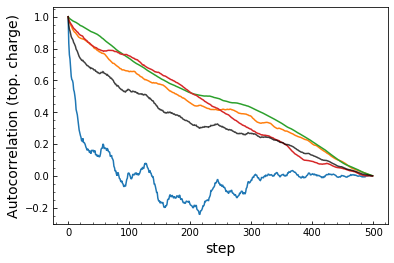

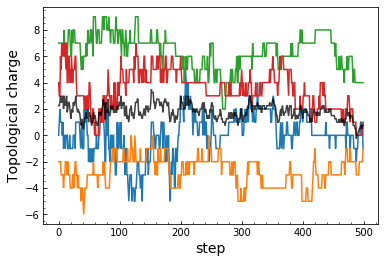

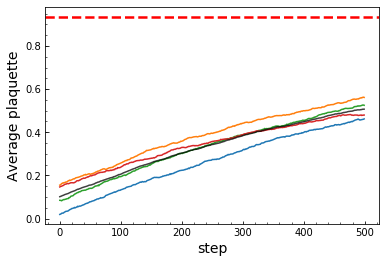

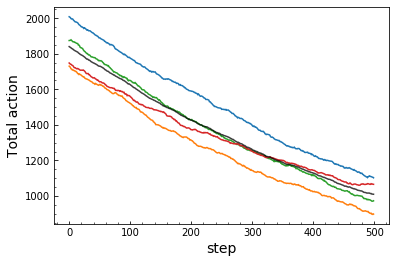

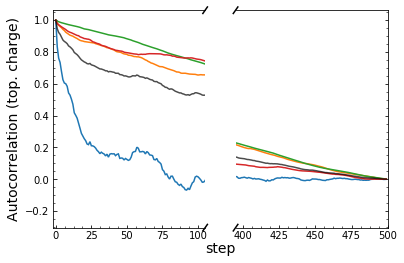

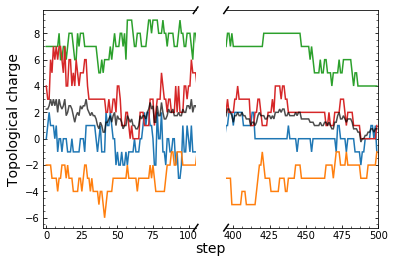

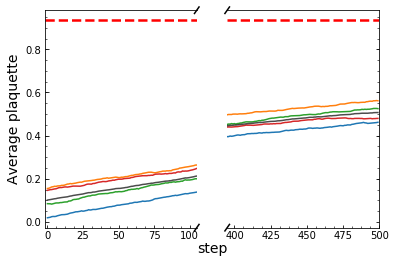

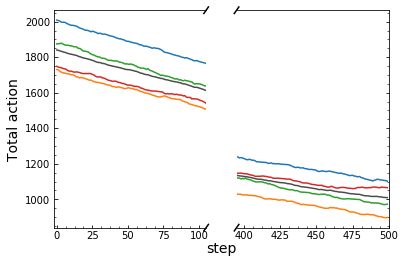

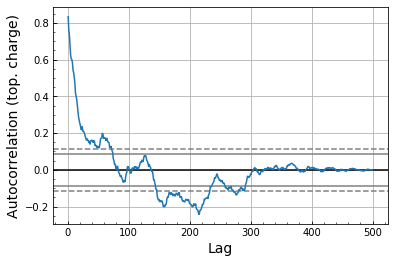

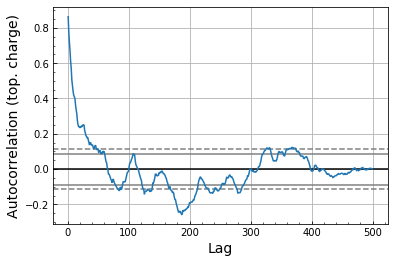

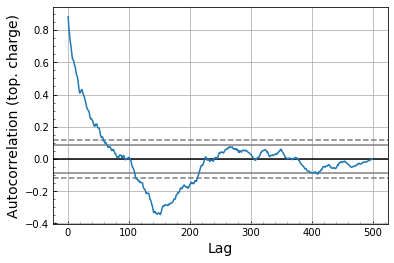

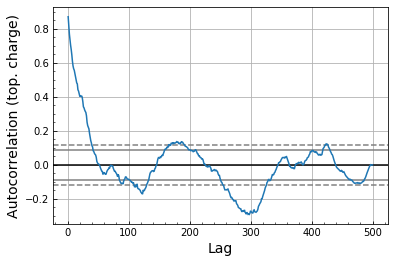

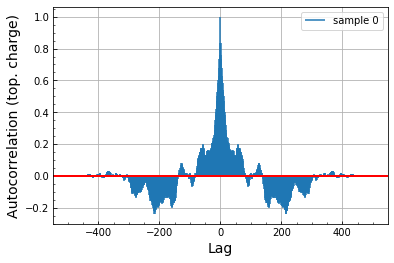

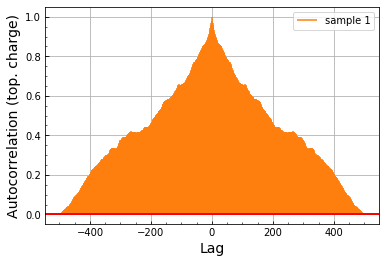

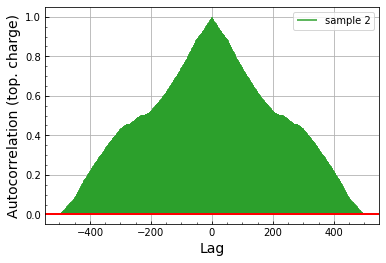

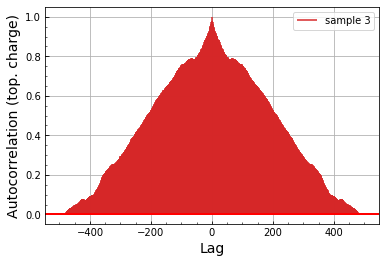

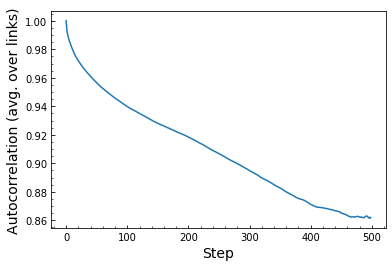

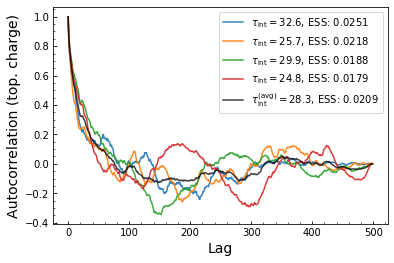

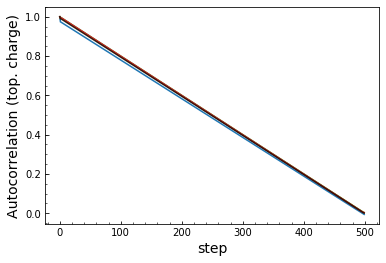

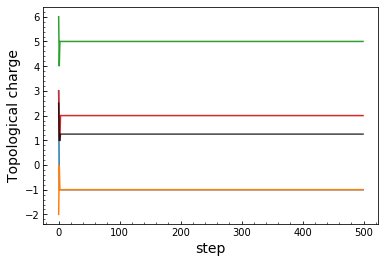

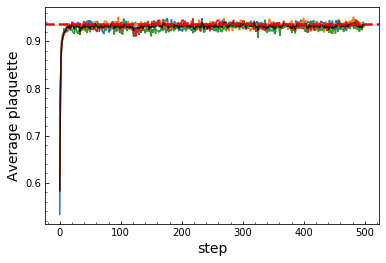

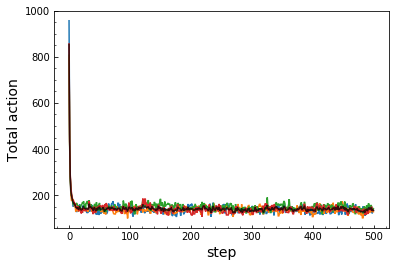

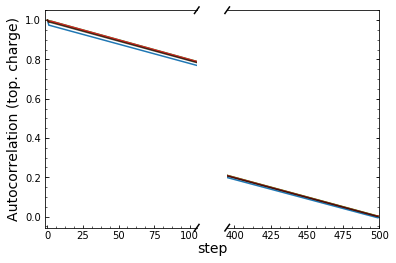

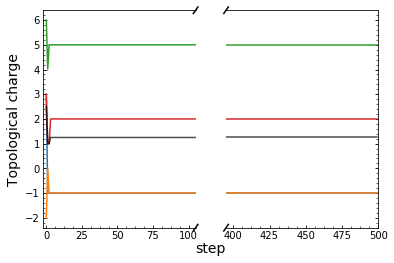

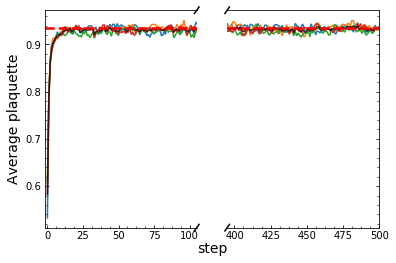

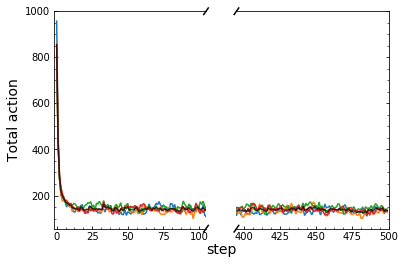

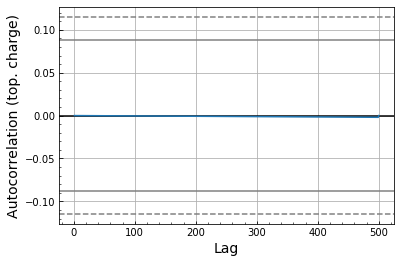

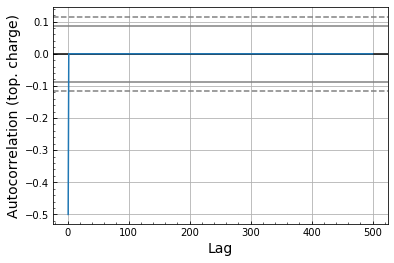

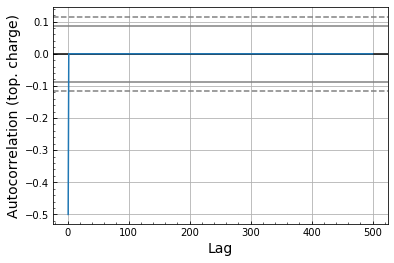

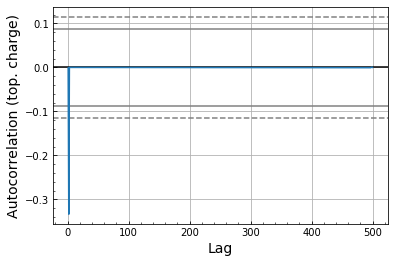

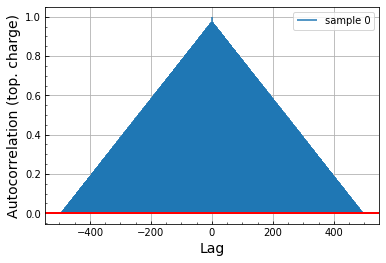

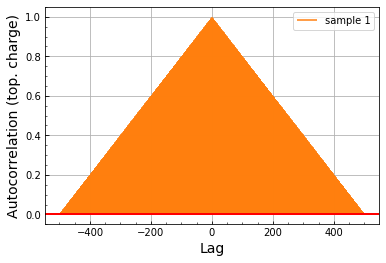

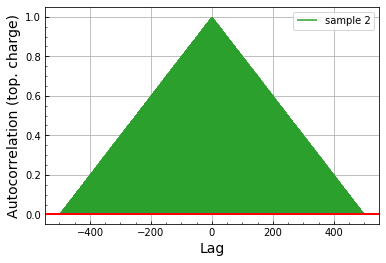

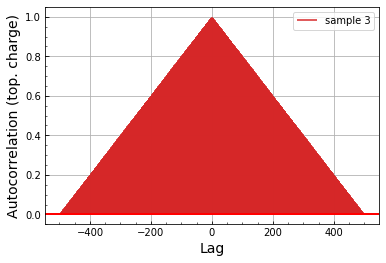

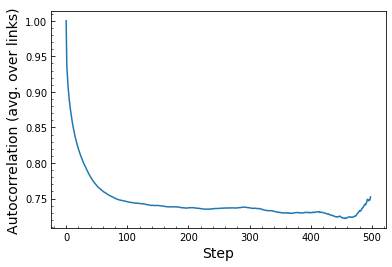

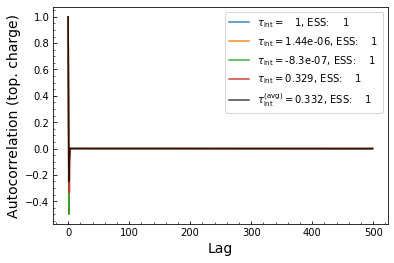

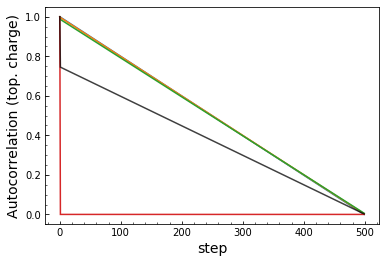

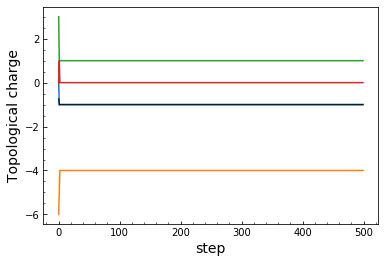

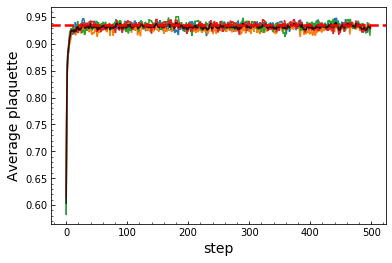

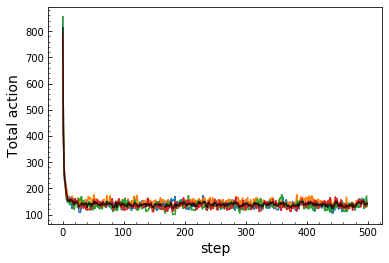

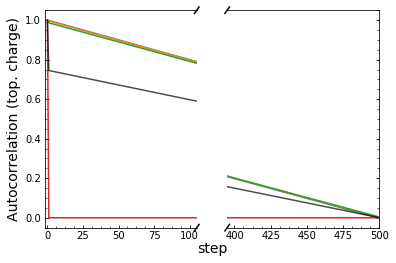

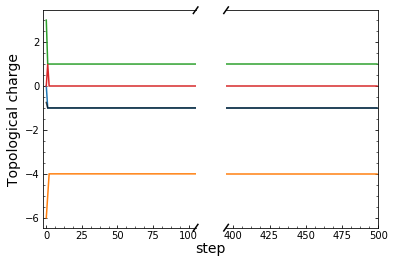

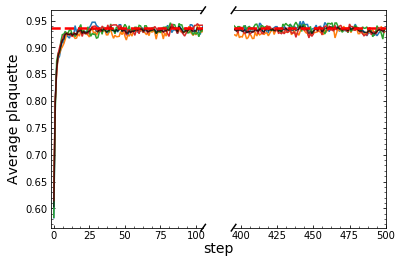

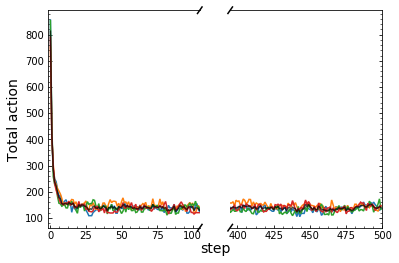

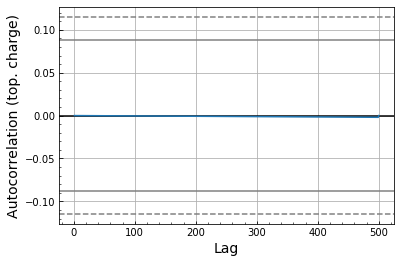

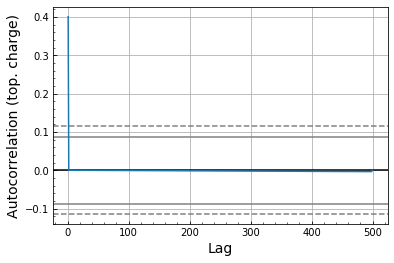

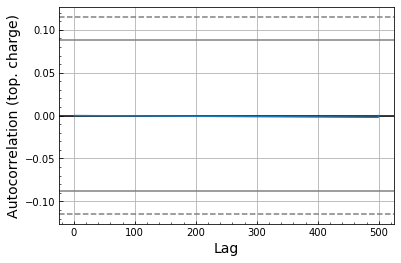

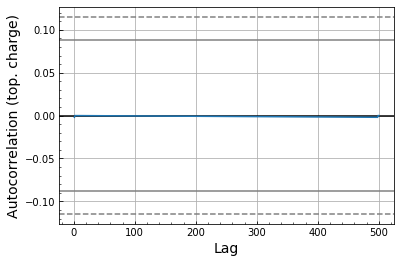

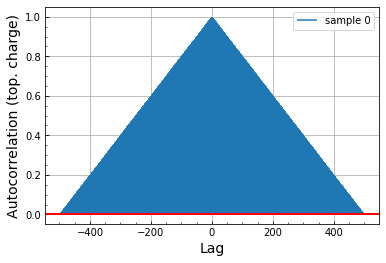

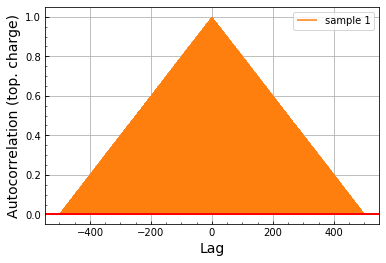

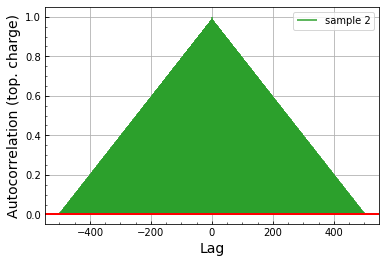

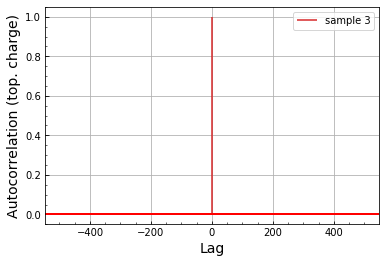

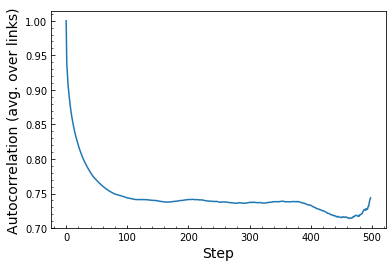

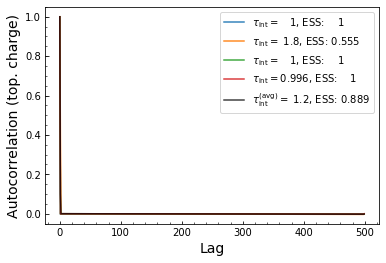

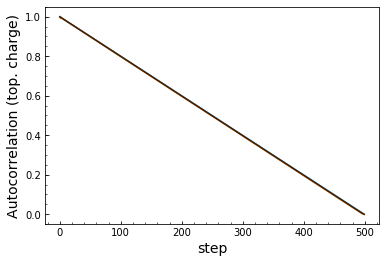

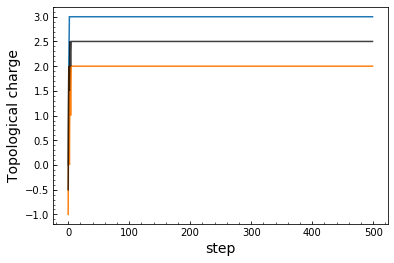

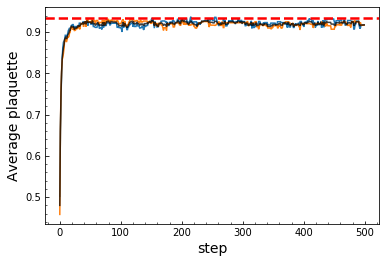

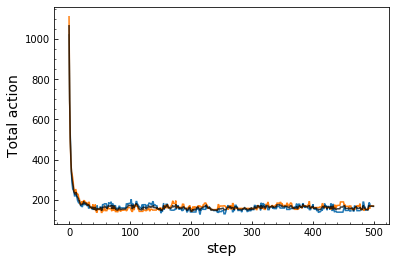

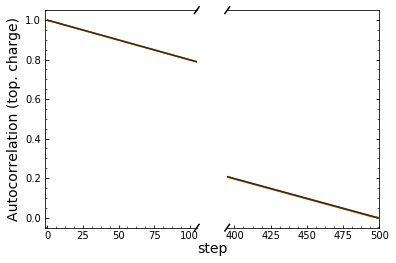

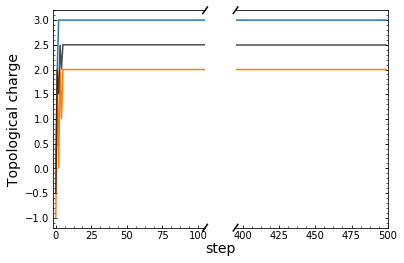

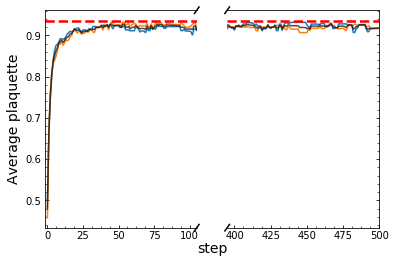

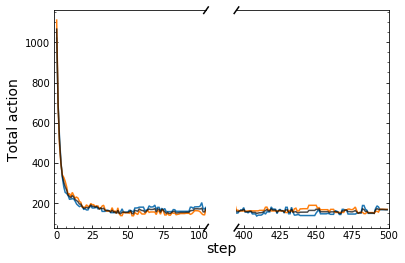

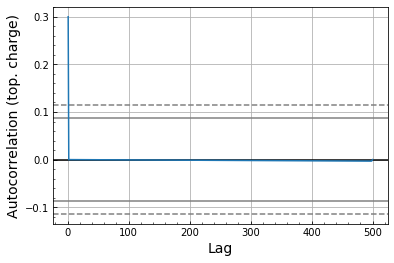

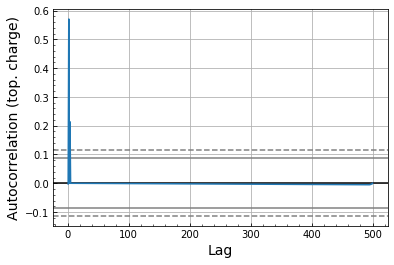

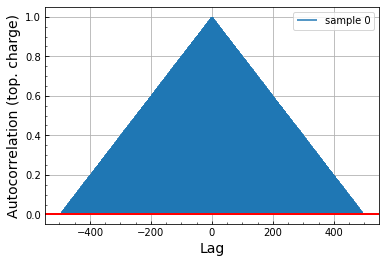

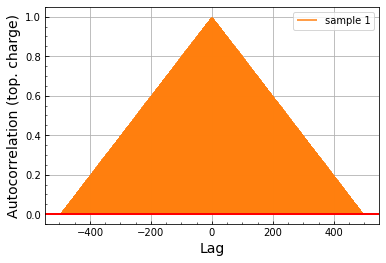

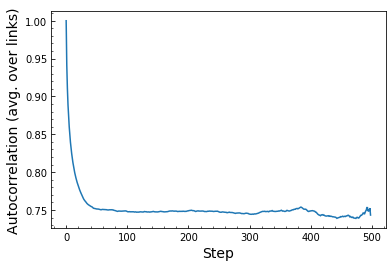

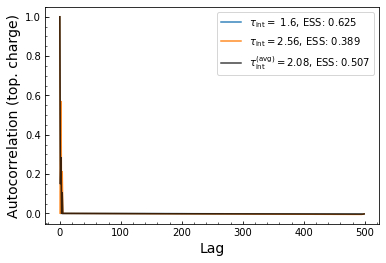

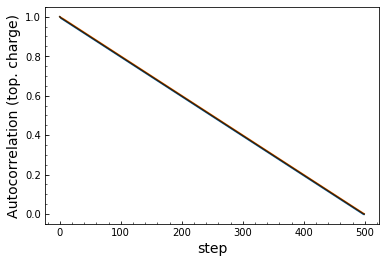

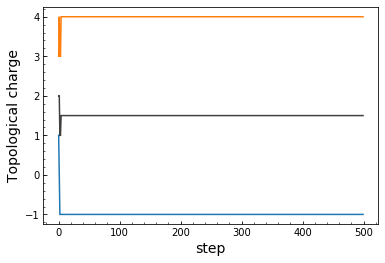

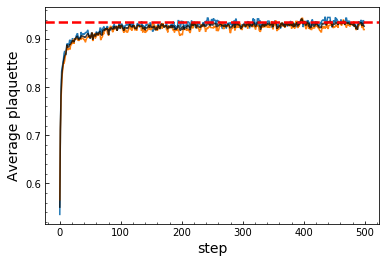

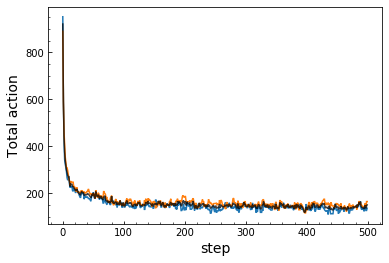

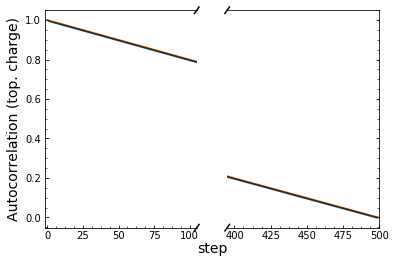

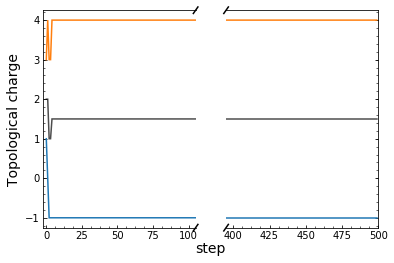

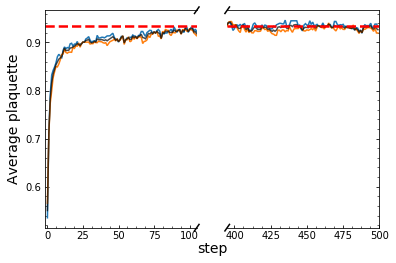

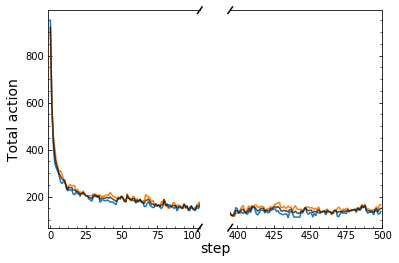

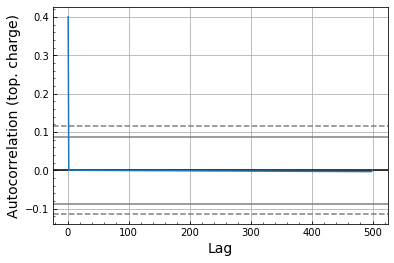

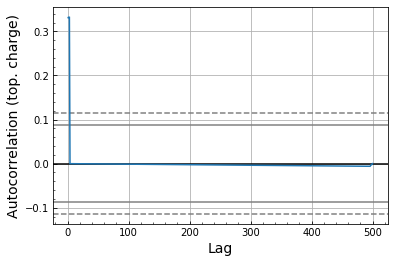

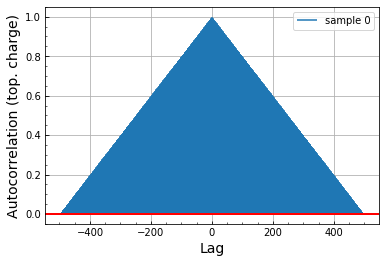

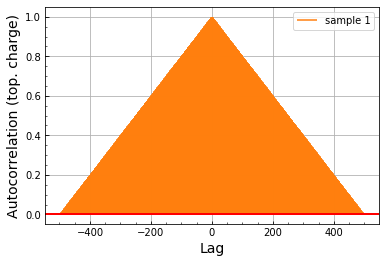

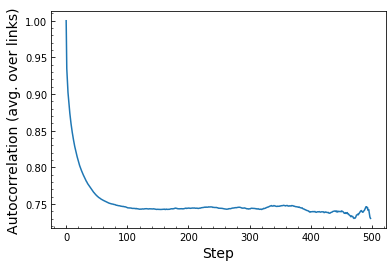

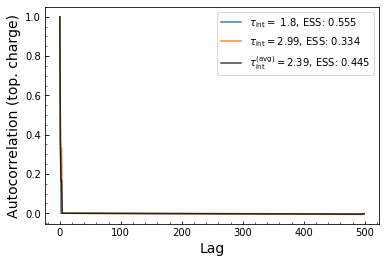

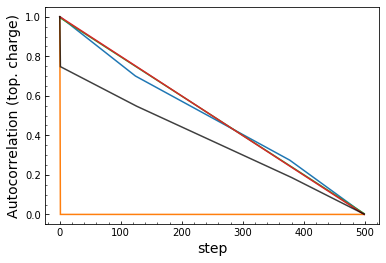

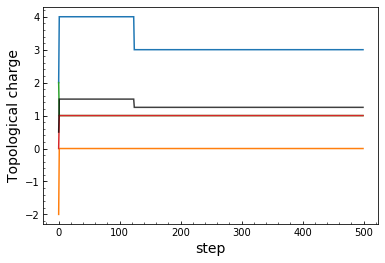

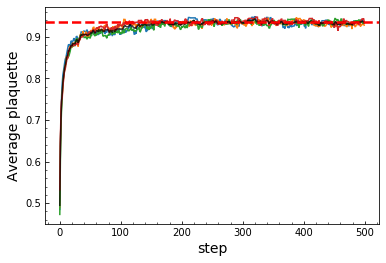

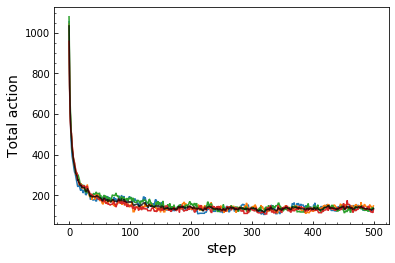

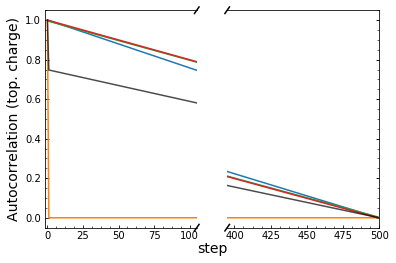

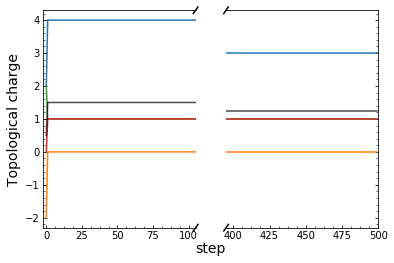

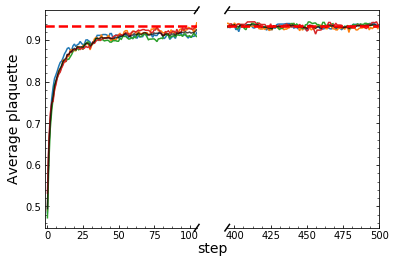

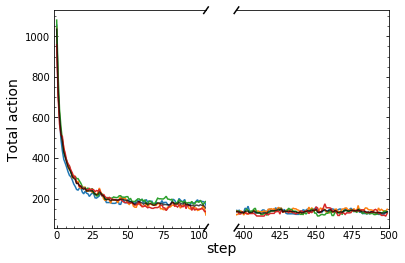

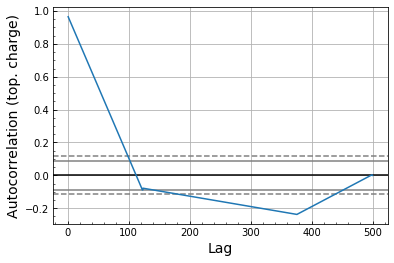

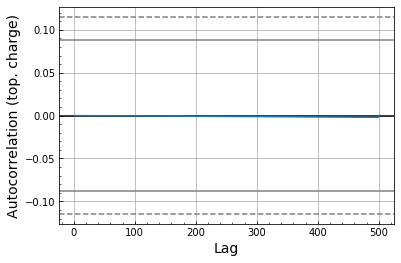

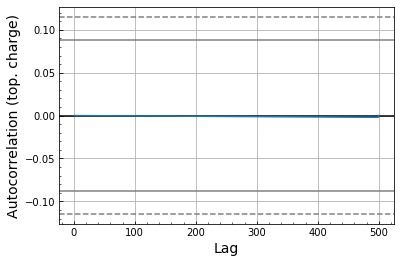

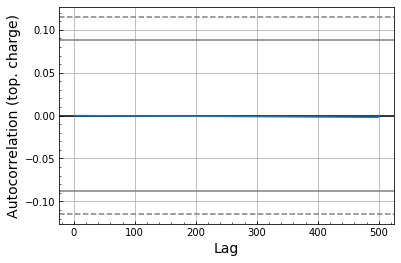

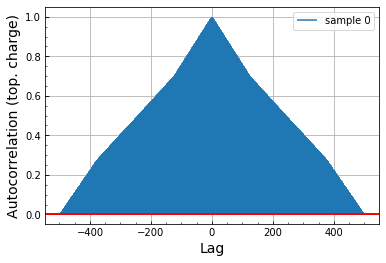

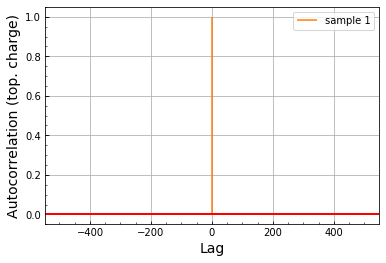

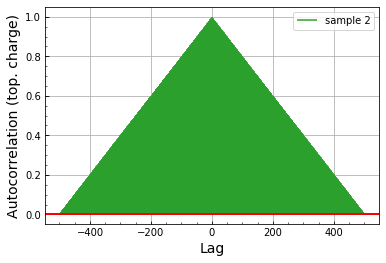

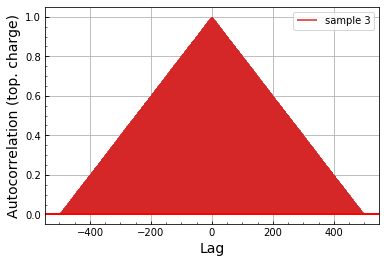

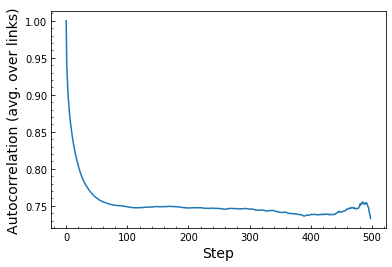

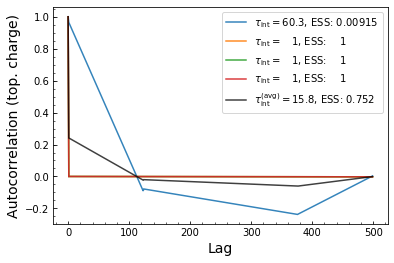

In [8]:
bad_dirs = []
for log_dir in log_dirs:
    try:
        calc_observables_generate_plots(log_dir)
    except:
        bad_dirs.append(log_dir)
        continue

In [6]:
lattice = GaugeLattice(time_size=8, 
                       space_size=8,
                       dim=2, 
                       beta=8., 
                       link_type='U1',
                       num_samples=5,
                       rand=False)

In [7]:
lattice.links.shape

(8, 8, 2)

## Calculate observables and create plots step by step, dir by dir...

In [109]:
log_dir = (
    '../../gauge_logs_graph/run_63/'
)

figs_dir = os.path.join(log_dir, 'figures')
#autocorr_dir = os.path.join(figs_dir, 'autocorrelation_plots')
#check_else_make_dir(autocorr_dir)

### Calculate observables

In [110]:
params, samples, observables = calc_observables_from_log_dir(log_dir)
if isinstance(observables, dict):
    actions = {}
    avg_plaquettes = {}
    top_charges = {}
    for key, val in observables.items():
        _actions, _avg_plaquettes, _top_charges = val
        actions[key] = _actions
        avg_plaquettes[key] = _avg_plaquettes
        top_charges[key] = _top_charges
else:
    actions, avg_plaquettes, top_charges = observables

print('\n' + 80 * '-')
for key, val in params.items():
    print(f'{key}: {val}')
print(80 * '-')

Loading samples history from: ../../gauge_logs_graph/run_63/samples_history/samples_history_100.pkl.
Reading samples from ../../gauge_logs_graph/run_63/samples_history/samples_history_100.pkl.
Loading samples history from: ../../gauge_logs_graph/run_63/samples_history/samples_history_1000.pkl.
Reading samples from ../../gauge_logs_graph/run_63/samples_history/samples_history_1000.pkl.
Loading samples history from: ../../gauge_logs_graph/run_63/samples_history/samples_history_200.pkl.
Reading samples from ../../gauge_logs_graph/run_63/samples_history/samples_history_200.pkl.
Loading samples history from: ../../gauge_logs_graph/run_63/samples_history/samples_history_500.pkl.
Reading samples from ../../gauge_logs_graph/run_63/samples_history/samples_history_500.pkl.
Loading samples history from: ../../gauge_logs_graph/run_63/samples_history/samples_history_5000.pkl.
Reading samples from ../../gauge_logs_graph/run_63/samples_history/samples_history_5000.pkl.
Unable to find ../../gauge_logs

step: 70 time/step: 0.09569 avg action: 123.9  avg plaquette: 0.7581 top charges: 


[-1, 1, 1, 0, 0]


step: 71 time/step: 0.1266 avg action: 123.9  avg plaquette: 0.7581 top charges: 


[-1, 1, 1, 0, 0]


step: 72 time/step: 0.08618 avg action: 123.9  avg plaquette: 0.7581 top charges: 


[-1, 1, 1, 0, 0]


step: 73 time/step: 0.1061 avg action: 123.9  avg plaquette: 0.7581 top charges: 


[-1, 1, 1, 0, 0]


step: 74 time/step: 0.08303 avg action: 123.9  avg plaquette: 0.7581 top charges: 


[-1, 1, 1, 0, 0]


step: 75 time/step: 0.09921 avg action: 123.9  avg plaquette: 0.7581 top charges: 


[-1, 1, 1, 0, 0]


step: 76 time/step: 0.08311 avg action: 123.9  avg plaquette: 0.7581 top charges: 


[-1, 1, 1, 0, 0]


step: 77 time/step: 0.07792 avg action: 123.9  avg plaquette: 0.7581 top charges: 


[-1, 1, 1, 0, 0]


step: 78 time/step: 0.0636 avg action: 123.9  avg plaquette: 0.7581 top charges: 


[-1, 1, 1, 0, 0]


step: 79 time/step: 0.07303 avg action: 123.9  avg plaquette: 0.758

step: 48 time/step: 0.102  avg action: 129.3  avg plaquette: 0.7475 top charges: 


[-1, 1, 1, -1, -1]


step: 49 time/step: 0.09303 avg action: 129.3  avg plaquette: 0.7475 top charges: 


[-1, 1, 1, -1, -1]


step: 50 time/step: 0.07364 avg action: 129.3  avg plaquette: 0.7475 top charges: 


[-1, 1, 1, -1, -1]


step: 51 time/step: 0.07896 avg action: 129.3  avg plaquette: 0.7475 top charges: 


[-1, 1, 1, -1, -1]


step: 52 time/step: 0.08862 avg action: 129.3  avg plaquette: 0.7475 top charges: 


[-1, 1, 1, -1, -1]


step: 53 time/step: 0.07144 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 54 time/step: 0.07321 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 55 time/step: 0.1042 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 56 time/step: 0.09026 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 57 time/step: 0.09176 avg action:  119   a

step: 127 time/step: 0.1284 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 128 time/step: 0.09043 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 129 time/step: 0.09733 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 130 time/step: 0.1709 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 131 time/step: 0.1019 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 132 time/step: 0.08692 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 133 time/step: 0.115  avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 134 time/step: 0.09233 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 135 time/step: 0.08919 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 136 time/step: 0.07567 avg action: 

step: 205 time/step: 0.09001 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 206 time/step: 0.07989 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 207 time/step: 0.07512 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 208 time/step: 0.08096 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 209 time/step: 0.09119 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 210 time/step: 0.07941 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 211 time/step: 0.08779 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 212 time/step: 0.08686 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 213 time/step: 0.07897 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 214 time/step: 0.1143 avg actio

step: 282 time/step: 0.09997 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 283 time/step: 0.09554 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 284 time/step: 0.0914 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 285 time/step: 0.1424 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 286 time/step: 0.07598 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 287 time/step: 0.07423 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 288 time/step: 0.07924 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 289 time/step: 0.095  avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 290 time/step: 0.07409 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 291 time/step: 0.07852 avg action:

step: 360 time/step: 0.08174 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 361 time/step: 0.1267 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 362 time/step: 0.06642 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 363 time/step: 0.05686 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 364 time/step: 0.05642 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 365 time/step: 0.1004 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 366 time/step: 0.09164 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 367 time/step: 0.0645 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 368 time/step: 0.06129 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 369 time/step: 0.05624 avg action:

step: 438 time/step: 0.0614 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 439 time/step: 0.05728 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 440 time/step: 0.05652 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 441 time/step: 0.06058 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 442 time/step: 0.05756 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 443 time/step: 0.06071 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 444 time/step: 0.07162 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 445 time/step: 0.06796 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 446 time/step: 0.0586 avg action:  119   avg plaquette: 0.7676 top charges: 


[-1, 1, 0, -1, -1]


step: 447 time/step: 0.05743 avg action

step: 516 time/step: 0.06112 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 517 time/step: 0.05936 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 518 time/step: 0.2866 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 519 time/step: 0.2034 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 520 time/step: 0.1851 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 521 time/step: 0.123  avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 522 time/step: 0.05873 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 523 time/step: 0.06601 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 524 time/step: 0.059  avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 525 time/step: 0.07426 avg action: 9

step: 593 time/step: 0.09476 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 594 time/step: 0.09895 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 595 time/step: 0.1047 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 596 time/step: 0.08376 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 597 time/step: 0.07942 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 598 time/step: 0.08865 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 599 time/step: 0.08471 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 600 time/step: 0.0826 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 601 time/step: 0.09277 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 602 time/step: 0.08642 avg action

step: 670 time/step: 0.6405 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 671 time/step: 0.6655 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 672 time/step: 0.8346 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 673 time/step: 0.5952 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 674 time/step: 0.6314 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 675 time/step: 0.3355 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 676 time/step: 0.4037 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 677 time/step: 0.415  avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 678 time/step: 0.5966 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 679 time/step: 0.4625 avg action: 91.91 

step: 748 time/step: 0.1597 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 749 time/step: 0.1959 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 750 time/step: 0.1435 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 751 time/step: 0.1951 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 752 time/step: 0.2946 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 753 time/step: 0.1788 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 754 time/step: 0.3414 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 755 time/step: 0.1679 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 756 time/step: 0.2718 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 757 time/step: 0.2076 avg action: 91.91 

step: 826 time/step: 0.2864 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 827 time/step: 0.1632 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 828 time/step: 0.1115 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 829 time/step: 0.119  avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 830 time/step: 0.1343 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 831 time/step: 0.1208 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 832 time/step: 0.0985 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 833 time/step: 0.1161 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 834 time/step: 0.1188 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 835 time/step: 0.4297 avg action: 91.91 

step: 905 time/step: 0.1299 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 906 time/step: 0.1659 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 907 time/step: 0.1649 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 908 time/step: 0.1581 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 909 time/step: 0.1668 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 910 time/step: 0.151  avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 911 time/step: 0.1143 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 912 time/step: 0.1066 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 913 time/step: 0.09741 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 914 time/step: 0.1257 avg action: 91.91

step: 984 time/step: 0.1483 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 985 time/step: 0.1356 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 986 time/step: 0.1501 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 987 time/step: 0.1506 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 988 time/step: 0.1855 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 989 time/step: 0.1393 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 990 time/step: 0.2172 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 991 time/step: 0.1197 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 992 time/step: 0.1227 avg action: 91.91  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, -1, -1]


step: 993 time/step: 0.1993 avg action: 91.91 

step: 64 time/step: 0.1043 avg action: 110.3  avg plaquette: 0.7845 top charges: 


[1, 1, -2, 0, 0]


step: 65 time/step: 0.0892 avg action: 110.3  avg plaquette: 0.7845 top charges: 


[1, 1, -2, 0, 0]


step: 66 time/step: 0.1056 avg action: 110.3  avg plaquette: 0.7845 top charges: 


[1, 1, -2, 0, 0]


step: 67 time/step: 0.1008 avg action: 110.3  avg plaquette: 0.7845 top charges: 


[1, 1, -2, 0, 0]


step: 68 time/step: 0.09438 avg action: 110.3  avg plaquette: 0.7845 top charges: 


[1, 1, -2, 0, 0]


step: 69 time/step: 0.1043 avg action: 110.3  avg plaquette: 0.7845 top charges: 


[1, 1, -2, 0, 0]


step: 70 time/step: 0.1311 avg action: 110.3  avg plaquette: 0.7845 top charges: 


[1, 1, -2, 0, 0]


step: 71 time/step: 0.0969 avg action: 110.3  avg plaquette: 0.7845 top charges: 


[1, 1, -2, 0, 0]


step: 72 time/step: 0.1092 avg action: 110.3  avg plaquette: 0.7845 top charges: 


[1, 1, -2, 0, 0]


step: 73 time/step: 0.1158 avg action: 110.3  avg plaquette: 0.7845 top 

step: 144 time/step: 0.08856 avg action: 110.3  avg plaquette: 0.7845 top charges: 


[1, 1, -2, 0, 0]


step: 145 time/step: 0.1186 avg action: 110.3  avg plaquette: 0.7845 top charges: 


[1, 1, -2, 0, 0]


step: 146 time/step: 0.1005 avg action: 110.3  avg plaquette: 0.7845 top charges: 


[1, 1, -2, 0, 0]


step: 147 time/step: 0.08381 avg action: 110.3  avg plaquette: 0.7845 top charges: 


[1, 1, -2, 0, 0]


step: 148 time/step: 0.08033 avg action: 110.3  avg plaquette: 0.7845 top charges: 


[1, 1, -2, 0, 0]


step: 149 time/step: 0.08175 avg action: 110.3  avg plaquette: 0.7845 top charges: 


[1, 1, -2, 0, 0]


step: 150 time/step: 0.08166 avg action: 110.3  avg plaquette: 0.7845 top charges: 


[1, 1, -2, 0, 0]


step: 151 time/step: 0.08927 avg action: 110.3  avg plaquette: 0.7845 top charges: 


[1, 1, -2, 0, 0]


step: 152 time/step: 0.07806 avg action: 110.3  avg plaquette: 0.7845 top charges: 


[1, 1, -2, 0, 0]


step: 153 time/step: 0.07611 avg action: 110.3  avg plaqu

step: 23 time/step: 0.1387 avg action: 188.1  avg plaquette: 0.6327 top charges: 


[1, -1, -1, 1, 2]


step: 24 time/step: 0.1065 avg action: 188.1  avg plaquette: 0.6327 top charges: 


[1, -1, -1, 1, 2]


step: 25 time/step: 0.2804 avg action: 188.1  avg plaquette: 0.6327 top charges: 


[1, -1, -1, 1, 2]


step: 26 time/step: 0.1748 avg action: 188.1  avg plaquette: 0.6327 top charges: 


[1, -1, -1, 1, 2]


step: 27 time/step: 0.1907 avg action: 188.1  avg plaquette: 0.6327 top charges: 


[1, -1, -1, 1, 2]


step: 28 time/step: 0.2193 avg action: 188.1  avg plaquette: 0.6327 top charges: 


[1, -1, -1, 1, 2]


step: 29 time/step: 0.1526 avg action: 188.1  avg plaquette: 0.6327 top charges: 


[1, -1, -1, 1, 2]


step: 30 time/step: 0.1413 avg action: 188.1  avg plaquette: 0.6327 top charges: 


[1, -1, -1, 1, 2]


step: 31 time/step: 0.1277 avg action: 188.1  avg plaquette: 0.6327 top charges: 


[1, -1, -1, 1, 2]


step: 32 time/step: 0.1382 avg action: 188.1  avg plaquette: 0.6

step: 104 time/step: 0.07721 avg action: 164.8  avg plaquette: 0.6782 top charges: 


[1, -1, -1, 0, 2]


step: 105 time/step: 0.09505 avg action: 164.8  avg plaquette: 0.6782 top charges: 


[1, -1, -1, 0, 2]


step: 106 time/step: 0.1008 avg action: 164.8  avg plaquette: 0.6782 top charges: 


[1, -1, -1, 0, 2]


step: 107 time/step: 0.08802 avg action: 164.8  avg plaquette: 0.6782 top charges: 


[1, -1, -1, 0, 2]


step: 108 time/step: 0.09366 avg action: 157.1  avg plaquette: 0.6931 top charges: 


[1, -1, -1, -1, 2]


step: 109 time/step:  0.12  avg action: 157.1  avg plaquette: 0.6931 top charges: 


[1, -1, -1, -1, 2]


step: 110 time/step: 0.1007 avg action: 157.1  avg plaquette: 0.6931 top charges: 


[1, -1, -1, -1, 2]


step: 111 time/step: 0.09712 avg action: 157.1  avg plaquette: 0.6931 top charges: 


[1, -1, -1, -1, 2]


step: 112 time/step: 0.1153 avg action: 157.1  avg plaquette: 0.6931 top charges: 


[1, -1, -1, -1, 2]


step: 113 time/step: 0.09547 avg action: 157.

step: 181 time/step: 0.09019 avg action: 157.1  avg plaquette: 0.6931 top charges: 


[1, -1, -1, -1, 2]


step: 182 time/step: 0.09112 avg action: 157.1  avg plaquette: 0.6931 top charges: 


[1, -1, -1, -1, 2]


step: 183 time/step: 0.08562 avg action: 157.1  avg plaquette: 0.6931 top charges: 


[1, -1, -1, -1, 2]


step: 184 time/step: 0.0806 avg action: 157.1  avg plaquette: 0.6931 top charges: 


[1, -1, -1, -1, 2]


step: 185 time/step: 0.08816 avg action: 157.1  avg plaquette: 0.6931 top charges: 


[1, -1, -1, -1, 2]


step: 186 time/step: 0.08157 avg action: 157.1  avg plaquette: 0.6931 top charges: 


[1, -1, -1, -1, 2]


step: 187 time/step: 0.07568 avg action: 157.1  avg plaquette: 0.6931 top charges: 


[1, -1, -1, -1, 2]


step: 188 time/step: 0.0771 avg action: 157.1  avg plaquette: 0.6931 top charges: 


[1, -1, -1, -1, 2]


step: 189 time/step: 0.07469 avg action: 157.1  avg plaquette: 0.6931 top charges: 


[1, -1, -1, -1, 2]


step: 190 time/step: 0.1082 avg action:

step: 259 time/step: 0.0763 avg action: 157.1  avg plaquette: 0.6931 top charges: 


[1, -1, -1, -1, 2]


step: 260 time/step: 0.09538 avg action: 157.1  avg plaquette: 0.6931 top charges: 


[1, -1, -1, -1, 2]


step: 261 time/step: 0.07931 avg action: 157.1  avg plaquette: 0.6931 top charges: 


[1, -1, -1, -1, 2]


step: 262 time/step: 0.07659 avg action: 157.1  avg plaquette: 0.6931 top charges: 


[1, -1, -1, -1, 2]


step: 263 time/step: 0.07865 avg action: 157.1  avg plaquette: 0.6931 top charges: 


[1, -1, -1, -1, 2]


step: 264 time/step: 0.08014 avg action: 147.5  avg plaquette: 0.7119 top charges: 


[1, -1, -1, -1, 2]


step: 265 time/step: 0.1009 avg action: 147.5  avg plaquette: 0.7119 top charges: 


[1, -1, -1, -1, 2]


step: 266 time/step: 0.1363 avg action: 147.5  avg plaquette: 0.7119 top charges: 


[1, -1, -1, -1, 2]


step: 267 time/step: 0.09853 avg action: 147.5  avg plaquette: 0.7119 top charges: 


[1, -1, -1, -1, 2]


step: 268 time/step: 0.1013 avg action: 

step: 338 time/step: 0.1388 avg action: 147.5  avg plaquette: 0.7119 top charges: 


[1, -1, -1, -1, 2]


step: 339 time/step: 0.147  avg action: 147.5  avg plaquette: 0.7119 top charges: 


[1, -1, -1, -1, 2]


step: 340 time/step: 0.4022 avg action: 147.5  avg plaquette: 0.7119 top charges: 


[1, -1, -1, -1, 2]


step: 341 time/step: 0.248  avg action: 147.5  avg plaquette: 0.7119 top charges: 


[1, -1, -1, -1, 2]


step: 342 time/step: 0.2163 avg action: 147.5  avg plaquette: 0.7119 top charges: 


[1, -1, -1, -1, 2]


step: 343 time/step: 0.1168 avg action: 147.5  avg plaquette: 0.7119 top charges: 


[1, -1, -1, -1, 2]


step: 344 time/step: 0.09569 avg action: 147.5  avg plaquette: 0.7119 top charges: 


[1, -1, -1, -1, 2]


step: 345 time/step: 0.09721 avg action: 147.5  avg plaquette: 0.7119 top charges: 


[1, -1, -1, -1, 2]


step: 346 time/step: 0.1402 avg action: 147.5  avg plaquette: 0.7119 top charges: 


[1, -1, -1, -1, 2]


step: 347 time/step: 0.1031 avg action: 132.

step: 416 time/step: 0.1806 avg action: 132.9  avg plaquette: 0.7403 top charges: 


[3, -1, -1, -1, 2]


step: 417 time/step: 0.1141 avg action: 132.9  avg plaquette: 0.7403 top charges: 


[3, -1, -1, -1, 2]


step: 418 time/step: 0.099  avg action: 132.9  avg plaquette: 0.7403 top charges: 


[3, -1, -1, -1, 2]


step: 419 time/step: 0.0974 avg action: 132.9  avg plaquette: 0.7403 top charges: 


[3, -1, -1, -1, 2]


step: 420 time/step: 0.09686 avg action: 132.9  avg plaquette: 0.7403 top charges: 


[3, -1, -1, -1, 2]


step: 421 time/step: 0.1544 avg action: 132.9  avg plaquette: 0.7403 top charges: 


[3, -1, -1, -1, 2]


step: 422 time/step: 0.1349 avg action: 132.9  avg plaquette: 0.7403 top charges: 


[3, -1, -1, -1, 2]


step: 423 time/step: 0.1083 avg action: 132.9  avg plaquette: 0.7403 top charges: 


[3, -1, -1, -1, 2]


step: 424 time/step: 0.1457 avg action: 132.9  avg plaquette: 0.7403 top charges: 


[3, -1, -1, -1, 2]


step: 425 time/step: 0.1075 avg action: 132.9

step: 494 time/step: 0.1175 avg action: 132.9  avg plaquette: 0.7403 top charges: 


[3, -1, -1, -1, 2]


step: 495 time/step: 0.1165 avg action: 132.9  avg plaquette: 0.7403 top charges: 


[3, -1, -1, -1, 2]


step: 496 time/step: 0.1238 avg action: 132.9  avg plaquette: 0.7403 top charges: 


[3, -1, -1, -1, 2]


step: 497 time/step: 0.1343 avg action: 132.9  avg plaquette: 0.7403 top charges: 


[3, -1, -1, -1, 2]


step: 498 time/step: 0.1163 avg action: 132.9  avg plaquette: 0.7403 top charges: 


[3, -1, -1, -1, 2]


step: 499 time/step: 0.152  avg action: 132.9  avg plaquette: 0.7403 top charges: 


[3, -1, -1, -1, 2]


Saving calculated observables to: ../../gauge_logs_graph/run_63/observables/observables_500.pkl.
done.
step: 0 time/step: 0.147  avg action:  216   avg plaquette: 0.578  top charges: 


[4, -3, 3, 1, -3]


step: 1 time/step:  0.14  avg action:  216   avg plaquette: 0.578  top charges: 


[4, -3, 3, 1, -3]


step: 2 time/step: 0.1344 avg action: 198.2  avg plaque

step: 74 time/step:  0.21  avg action: 167.5  avg plaquette: 0.6728 top charges: 


[0, -3, 3, 1, 0]


step: 75 time/step: 0.1266 avg action: 167.5  avg plaquette: 0.6728 top charges: 


[0, -3, 3, 1, 0]


step: 76 time/step: 0.2086 avg action: 167.5  avg plaquette: 0.6728 top charges: 


[0, -3, 3, 1, 0]


step: 77 time/step: 0.2194 avg action: 167.5  avg plaquette: 0.6728 top charges: 


[0, -3, 3, 1, 0]


step: 78 time/step:  0.16  avg action: 167.5  avg plaquette: 0.6728 top charges: 


[0, -3, 3, 1, 0]


step: 79 time/step: 0.1485 avg action: 167.5  avg plaquette: 0.6728 top charges: 


[0, -3, 3, 1, 0]


step: 80 time/step: 0.3113 avg action: 167.5  avg plaquette: 0.6728 top charges: 


[0, -3, 3, 1, 0]


step: 81 time/step: 0.2065 avg action: 167.5  avg plaquette: 0.6728 top charges: 


[0, -3, 3, 1, 0]


step: 82 time/step: 0.316  avg action: 167.5  avg plaquette: 0.6728 top charges: 


[0, -3, 3, 1, 0]


step: 83 time/step: 0.3563 avg action: 167.5  avg plaquette: 0.6728 top c

step: 154 time/step: 0.1045 avg action: 124.8  avg plaquette: 0.7563 top charges: 


[2, -2, 3, 1, 0]


step: 155 time/step: 0.1459 avg action: 124.8  avg plaquette: 0.7563 top charges: 


[2, -2, 3, 1, 0]


step: 156 time/step: 0.1417 avg action: 124.8  avg plaquette: 0.7563 top charges: 


[2, -2, 3, 1, 0]


step: 157 time/step: 0.1204 avg action: 124.8  avg plaquette: 0.7563 top charges: 


[2, -2, 3, 1, 0]


step: 158 time/step: 0.09619 avg action: 124.8  avg plaquette: 0.7563 top charges: 


[2, -2, 3, 1, 0]


step: 159 time/step: 0.1062 avg action: 124.8  avg plaquette: 0.7563 top charges: 


[2, -2, 3, 1, 0]


step: 160 time/step: 0.1181 avg action: 124.8  avg plaquette: 0.7563 top charges: 


[2, -2, 3, 1, 0]


step: 161 time/step: 0.09927 avg action: 124.8  avg plaquette: 0.7563 top charges: 


[2, -2, 3, 1, 0]


step: 162 time/step: 0.1701 avg action: 124.8  avg plaquette: 0.7563 top charges: 


[2, -2, 3, 1, 0]


step: 163 time/step: 0.6822 avg action: 124.8  avg plaquette: 

step: 234 time/step: 0.2878 avg action: 104.4  avg plaquette: 0.7962 top charges: 


[2, -2, 3, 0, 0]


step: 235 time/step: 0.1771 avg action: 104.4  avg plaquette: 0.7962 top charges: 


[2, -2, 3, 0, 0]


step: 236 time/step: 0.2685 avg action: 104.4  avg plaquette: 0.7962 top charges: 


[2, -2, 3, 0, 0]


step: 237 time/step: 0.3349 avg action: 104.4  avg plaquette: 0.7962 top charges: 


[2, -2, 3, 0, 0]


step: 238 time/step: 0.401  avg action: 104.4  avg plaquette: 0.7962 top charges: 


[2, -2, 3, 0, 0]


step: 239 time/step: 0.2299 avg action: 104.4  avg plaquette: 0.7962 top charges: 


[2, -2, 3, 0, 0]


step: 240 time/step: 0.2191 avg action: 104.4  avg plaquette: 0.7962 top charges: 


[2, -2, 3, 0, 0]


step: 241 time/step: 0.1827 avg action: 104.4  avg plaquette: 0.7962 top charges: 


[2, -2, 3, 0, 0]


step: 242 time/step: 0.3677 avg action: 104.4  avg plaquette: 0.7962 top charges: 


[2, -2, 3, 0, 0]


step: 243 time/step: 0.1929 avg action: 104.4  avg plaquette: 0.

step: 313 time/step: 0.1787 avg action: 79.04  avg plaquette: 0.8456 top charges: 


[2, -2, 2, 0, 0]


step: 314 time/step: 0.2675 avg action: 79.04  avg plaquette: 0.8456 top charges: 


[2, -2, 2, 0, 0]


step: 315 time/step: 0.3661 avg action: 79.04  avg plaquette: 0.8456 top charges: 


[2, -2, 2, 0, 0]


step: 316 time/step: 0.1589 avg action: 79.04  avg plaquette: 0.8456 top charges: 


[2, -2, 2, 0, 0]


step: 317 time/step: 0.2801 avg action: 79.04  avg plaquette: 0.8456 top charges: 


[2, -2, 2, 0, 0]


step: 318 time/step: 0.4402 avg action: 79.04  avg plaquette: 0.8456 top charges: 


[2, -2, 2, 0, 0]


step: 319 time/step: 0.2758 avg action: 79.04  avg plaquette: 0.8456 top charges: 


[2, -2, 2, 0, 0]


step: 320 time/step: 0.3211 avg action: 79.04  avg plaquette: 0.8456 top charges: 


[2, -2, 2, 0, 0]


step: 321 time/step: 0.3918 avg action: 79.04  avg plaquette: 0.8456 top charges: 


[2, -2, 2, 0, 0]


step: 322 time/step: 0.2372 avg action: 79.04  avg plaquette: 0.

step: 393 time/step: 0.255  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 394 time/step: 0.2061 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 395 time/step: 0.1845 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 396 time/step: 0.2008 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 397 time/step: 0.1929 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 398 time/step: 0.2498 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 399 time/step: 0.243  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 400 time/step: 0.4241 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 401 time/step: 0.3929 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 402 time/step: 0.1481 avg action: 77.29  avg plaquette: 0.

step: 472 time/step: 0.1121 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 473 time/step: 0.1354 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 474 time/step: 0.1374 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 475 time/step: 0.1941 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 476 time/step: 0.1971 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 477 time/step: 0.1277 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 478 time/step: 0.1347 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 479 time/step: 0.1023 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 480 time/step: 0.1084 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 481 time/step: 0.1391 avg action: 77.29  avg plaquette: 0.

step: 552 time/step: 0.1746 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 553 time/step: 0.1746 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 554 time/step: 0.1644 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 555 time/step: 0.1519 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 556 time/step: 0.2002 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 557 time/step: 0.1252 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 558 time/step: 0.1258 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 559 time/step: 0.1236 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 560 time/step: 0.1163 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 561 time/step: 0.1744 avg action: 77.29  avg plaquette: 0.

step: 631 time/step: 0.1369 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 632 time/step: 0.1422 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 633 time/step: 0.1825 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 634 time/step: 0.1469 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 635 time/step: 0.125  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 636 time/step: 0.1353 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 637 time/step: 0.1385 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 638 time/step: 0.118  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 639 time/step: 0.1077 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 640 time/step: 0.1202 avg action: 77.29  avg plaquette: 0.

step: 711 time/step: 0.1228 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 712 time/step: 0.09906 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 713 time/step: 0.1025 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 714 time/step: 0.1011 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 715 time/step: 0.1258 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 716 time/step: 0.1218 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 717 time/step: 0.1221 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 718 time/step: 0.1614 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 719 time/step: 0.1208 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 720 time/step: 0.1169 avg action: 77.29  avg plaquette: 0

step: 791 time/step: 0.2446 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 792 time/step: 0.2148 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 793 time/step: 0.201  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 794 time/step: 0.475  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 795 time/step: 0.4143 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 796 time/step: 0.5551 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 797 time/step: 0.2683 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 798 time/step: 0.1931 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 799 time/step: 0.2843 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 800 time/step: 0.5987 avg action: 77.29  avg plaquette: 0.

step: 870 time/step: 0.1359 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 871 time/step: 0.1818 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 872 time/step: 0.1511 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 873 time/step: 0.1701 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 874 time/step: 0.1971 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 875 time/step: 0.2005 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 876 time/step: 0.1165 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 877 time/step: 0.1416 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 878 time/step:  0.14  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 879 time/step: 0.1598 avg action: 77.29  avg plaquette: 0.

step: 949 time/step: 0.3247 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 950 time/step: 0.3899 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 951 time/step: 0.7695 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 952 time/step: 0.3482 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 953 time/step: 0.1907 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 954 time/step: 0.1662 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 955 time/step: 0.1896 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 956 time/step: 0.1375 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 957 time/step: 0.1231 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 958 time/step: 0.1096 avg action: 77.29  avg plaquette: 0.

step: 1029 time/step: 0.2149 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1030 time/step: 0.172  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1031 time/step: 0.1409 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1032 time/step: 0.1825 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1033 time/step: 0.1576 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1034 time/step: 0.1544 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1035 time/step: 0.1305 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1036 time/step: 0.1628 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1037 time/step: 0.2192 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1038 time/step: 0.1244 avg action: 77.29  avg pla

step: 1108 time/step: 0.1878 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1109 time/step: 0.2468 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1110 time/step: 0.1474 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1111 time/step: 0.1885 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1112 time/step: 0.1595 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1113 time/step: 0.2055 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1114 time/step: 0.3129 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1115 time/step: 0.2028 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1116 time/step: 0.2083 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1117 time/step: 0.3495 avg action: 77.29  avg pla

step: 1187 time/step: 0.2155 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1188 time/step: 0.1509 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1189 time/step: 0.1969 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1190 time/step: 0.1686 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1191 time/step: 0.1385 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1192 time/step: 0.1597 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1193 time/step: 0.1947 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1194 time/step: 0.1836 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1195 time/step: 0.1313 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1196 time/step: 0.116  avg action: 77.29  avg pla

step: 1266 time/step: 0.1604 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1267 time/step: 0.1642 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1268 time/step: 0.1587 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1269 time/step: 0.3176 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1270 time/step: 0.1541 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1271 time/step: 0.2206 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1272 time/step: 0.3296 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1273 time/step: 0.424  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1274 time/step: 0.2205 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1275 time/step: 0.3401 avg action: 77.29  avg pla

step: 1345 time/step: 0.1334 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1346 time/step: 0.1521 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1347 time/step: 0.319  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1348 time/step: 0.3587 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1349 time/step: 0.3366 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1350 time/step: 0.2346 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1351 time/step: 0.1238 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1352 time/step: 0.1328 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1353 time/step: 0.1191 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1354 time/step: 0.1264 avg action: 77.29  avg pla

step: 1423 time/step: 0.2287 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1424 time/step: 0.1245 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1425 time/step: 0.09493 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1426 time/step:  0.18  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1427 time/step: 0.1216 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1428 time/step: 0.3972 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1429 time/step: 0.274  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1430 time/step: 0.1628 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1431 time/step: 0.1501 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1432 time/step: 0.2817 avg action: 77.29  avg pl

step: 1502 time/step: 0.2702 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1503 time/step: 0.1374 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1504 time/step: 0.1326 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1505 time/step: 0.142  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1506 time/step: 0.1362 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1507 time/step: 0.3608 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1508 time/step: 0.1652 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1509 time/step: 0.2858 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1510 time/step: 0.1849 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1511 time/step: 0.2508 avg action: 77.29  avg pla

step: 1582 time/step: 0.1529 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1583 time/step: 0.1535 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1584 time/step: 0.246  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1585 time/step: 0.1717 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1586 time/step: 0.1817 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1587 time/step: 0.5259 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1588 time/step: 0.203  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1589 time/step: 0.1725 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1590 time/step: 0.1494 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1591 time/step: 0.1241 avg action: 77.29  avg pla

step: 1661 time/step: 0.202  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1662 time/step: 0.2208 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1663 time/step: 0.1858 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1664 time/step: 0.2259 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1665 time/step: 0.1231 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1666 time/step: 0.1526 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1667 time/step: 0.1449 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1668 time/step: 0.1846 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1669 time/step: 0.172  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1670 time/step: 0.1761 avg action: 77.29  avg pla

step: 1740 time/step: 0.1204 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1741 time/step: 0.1177 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1742 time/step: 0.1286 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1743 time/step: 0.1076 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1744 time/step: 0.1418 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1745 time/step: 0.1424 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1746 time/step: 0.1438 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1747 time/step: 0.1767 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1748 time/step: 0.1952 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1749 time/step: 0.1683 avg action: 77.29  avg pla

step: 1820 time/step: 0.1171 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1821 time/step: 0.1146 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1822 time/step: 0.1206 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1823 time/step: 0.1264 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1824 time/step: 0.1611 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1825 time/step: 0.1811 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1826 time/step: 0.3191 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1827 time/step: 0.1784 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1828 time/step: 0.1728 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1829 time/step: 0.1952 avg action: 77.29  avg pla

step: 1899 time/step: 0.1585 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1900 time/step: 0.2123 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1901 time/step: 0.163  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1902 time/step: 0.1363 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1903 time/step: 0.1306 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1904 time/step: 0.1342 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1905 time/step: 0.139  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1906 time/step: 0.207  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1907 time/step: 0.1356 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1908 time/step: 0.1441 avg action: 77.29  avg pla

step: 1979 time/step: 0.1513 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1980 time/step: 0.1212 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1981 time/step: 0.1727 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1982 time/step: 0.1382 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1983 time/step: 0.1136 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1984 time/step: 0.09984 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1985 time/step: 0.1341 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1986 time/step: 0.1036 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1987 time/step: 0.1622 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 1988 time/step: 0.3515 avg action: 77.29  avg pl

step: 2057 time/step: 0.3631 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2058 time/step: 0.257  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2059 time/step:  0.21  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2060 time/step: 0.142  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2061 time/step: 0.1825 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2062 time/step: 0.1906 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2063 time/step: 0.1261 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2064 time/step: 0.1454 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2065 time/step: 0.1788 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2066 time/step: 0.2062 avg action: 77.29  avg pla

step: 2136 time/step: 0.1853 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2137 time/step: 0.1633 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2138 time/step: 0.1879 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2139 time/step: 0.1428 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2140 time/step: 0.1661 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2141 time/step: 0.1633 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2142 time/step: 0.2091 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2143 time/step: 0.1738 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2144 time/step: 0.2359 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2145 time/step: 0.244  avg action: 77.29  avg pla

step: 2216 time/step: 0.1382 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2217 time/step: 0.1475 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2218 time/step: 0.1367 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2219 time/step: 0.1328 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2220 time/step: 0.1834 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2221 time/step: 0.1085 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2222 time/step: 0.1007 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2223 time/step: 0.1052 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2224 time/step: 0.1389 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2225 time/step: 0.1387 avg action: 77.29  avg pla

step: 2296 time/step: 0.1697 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2297 time/step: 0.1643 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2298 time/step: 0.1873 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2299 time/step: 0.1778 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2300 time/step: 0.1675 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2301 time/step: 0.1651 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2302 time/step: 0.3748 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2303 time/step: 0.2996 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2304 time/step: 0.3408 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2305 time/step: 0.2328 avg action: 77.29  avg pla

step: 2375 time/step: 0.1782 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2376 time/step: 0.1338 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2377 time/step: 0.1505 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2378 time/step: 0.1675 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2379 time/step: 0.1745 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2380 time/step: 0.3416 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2381 time/step: 0.1447 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2382 time/step: 0.159  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2383 time/step: 0.1918 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2384 time/step: 0.2851 avg action: 77.29  avg pla

step: 2455 time/step: 0.158  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2456 time/step: 0.1414 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2457 time/step: 0.1336 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2458 time/step: 0.2293 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2459 time/step: 0.1718 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2460 time/step: 0.1862 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2461 time/step: 0.1363 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2462 time/step: 0.1724 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2463 time/step: 0.2851 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2464 time/step: 0.2272 avg action: 77.29  avg pla

step: 2534 time/step: 0.1031 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2535 time/step:  0.21  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2536 time/step: 0.2411 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2537 time/step: 0.2443 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2538 time/step: 0.1717 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2539 time/step: 0.1886 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2540 time/step: 0.3386 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2541 time/step: 0.2071 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2542 time/step: 0.1611 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2543 time/step: 0.1227 avg action: 77.29  avg pla

step: 2614 time/step: 0.131  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2615 time/step: 0.1333 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2616 time/step: 0.1229 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2617 time/step: 0.1251 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2618 time/step: 0.1205 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2619 time/step: 0.1348 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2620 time/step: 0.153  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2621 time/step: 0.1942 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2622 time/step: 0.2199 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2623 time/step: 0.2578 avg action: 77.29  avg pla

step: 2693 time/step: 0.1354 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2694 time/step: 0.1248 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2695 time/step: 0.1743 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2696 time/step: 0.1371 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2697 time/step:  0.16  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2698 time/step:  0.16  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2699 time/step: 0.1521 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2700 time/step: 0.1295 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2701 time/step: 0.1599 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2702 time/step: 0.1288 avg action: 77.29  avg pla

step: 2771 time/step: 0.106  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2772 time/step: 0.1257 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2773 time/step: 0.1408 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2774 time/step: 0.103  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2775 time/step: 0.1197 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2776 time/step: 0.1159 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2777 time/step: 0.1244 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2778 time/step: 0.1102 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2779 time/step: 0.1177 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2780 time/step: 0.1344 avg action: 77.29  avg pla

step: 2850 time/step: 0.1699 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2851 time/step: 0.1721 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2852 time/step: 0.2792 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2853 time/step: 0.4045 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2854 time/step: 0.3105 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2855 time/step: 0.1767 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2856 time/step: 0.1494 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2857 time/step: 0.1825 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2858 time/step: 0.183  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2859 time/step: 0.1592 avg action: 77.29  avg pla

step: 2930 time/step: 0.1028 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2931 time/step: 0.09592 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2932 time/step: 0.09603 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2933 time/step: 0.09487 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2934 time/step: 0.09632 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2935 time/step: 0.09269 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2936 time/step: 0.09669 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2937 time/step: 0.1294 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2938 time/step: 0.09599 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 2939 time/step: 0.09886 avg action: 77.29 

step: 3010 time/step: 0.1065 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3011 time/step: 0.1316 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3012 time/step: 0.1952 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3013 time/step: 0.156  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3014 time/step: 0.1068 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3015 time/step: 0.09242 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3016 time/step: 0.118  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3017 time/step: 0.09756 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3018 time/step: 0.0981 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3019 time/step: 0.1009 avg action: 77.29  avg p

step: 3088 time/step: 0.1288 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3089 time/step: 0.1408 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3090 time/step: 0.1955 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3091 time/step: 0.1035 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3092 time/step: 0.1114 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3093 time/step: 0.1129 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3094 time/step: 0.1117 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3095 time/step: 0.1204 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3096 time/step: 0.1152 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3097 time/step: 0.1268 avg action: 77.29  avg pla

step: 3166 time/step: 0.118  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3167 time/step: 0.1586 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3168 time/step: 0.1386 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3169 time/step: 0.1031 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3170 time/step: 0.1337 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3171 time/step: 0.1005 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3172 time/step: 0.09806 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3173 time/step: 0.09345 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3174 time/step: 0.09296 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3175 time/step: 0.08998 avg action: 77.29  avg

step: 3244 time/step: 0.09988 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3245 time/step: 0.1086 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3246 time/step: 0.1028 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3247 time/step: 0.1175 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3248 time/step: 0.1542 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3249 time/step: 0.1373 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3250 time/step: 0.1328 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3251 time/step: 0.1084 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3252 time/step: 0.1051 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3253 time/step: 0.1106 avg action: 77.29  avg pl

step: 3323 time/step: 0.1979 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3324 time/step: 0.1488 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3325 time/step: 0.221  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3326 time/step: 0.1488 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3327 time/step: 0.1471 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3328 time/step: 0.1562 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3329 time/step: 0.2129 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3330 time/step: 0.1548 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3331 time/step: 0.1634 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3332 time/step: 0.1801 avg action: 77.29  avg pla

step: 3402 time/step: 0.1218 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3403 time/step: 0.142  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3404 time/step: 0.1822 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3405 time/step: 0.1379 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3406 time/step: 0.1467 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3407 time/step: 0.1649 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3408 time/step: 0.1462 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3409 time/step: 0.1254 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3410 time/step: 0.1016 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3411 time/step: 0.2035 avg action: 77.29  avg pla

step: 3480 time/step: 0.1283 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3481 time/step: 0.1337 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3482 time/step: 0.1448 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3483 time/step: 0.1955 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3484 time/step: 0.1497 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3485 time/step: 0.162  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3486 time/step: 0.1912 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3487 time/step: 0.3022 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3488 time/step: 0.1949 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3489 time/step: 0.1782 avg action: 77.29  avg pla

step: 3559 time/step: 0.1735 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3560 time/step: 0.1432 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3561 time/step: 0.147  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3562 time/step: 0.131  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3563 time/step: 0.1624 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3564 time/step: 0.1617 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3565 time/step: 0.1618 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3566 time/step: 0.1695 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3567 time/step:  0.17  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3568 time/step: 0.1811 avg action: 77.29  avg pla

step: 3639 time/step: 0.1197 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3640 time/step: 0.1613 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3641 time/step: 0.1493 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3642 time/step: 0.1598 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3643 time/step: 0.2007 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3644 time/step: 0.253  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3645 time/step: 0.1854 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3646 time/step: 0.1459 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3647 time/step: 0.1458 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3648 time/step: 0.1553 avg action: 77.29  avg pla

step: 3718 time/step: 0.1554 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3719 time/step: 0.1741 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3720 time/step: 0.2063 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3721 time/step: 0.1737 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3722 time/step: 0.1995 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3723 time/step: 0.1359 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3724 time/step: 0.1649 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3725 time/step: 0.2219 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3726 time/step: 0.4199 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3727 time/step: 0.5129 avg action: 77.29  avg pla

step: 3797 time/step: 0.1153 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3798 time/step: 0.1059 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3799 time/step: 0.1093 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3800 time/step: 0.1179 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3801 time/step: 0.179  avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3802 time/step: 0.08749 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3803 time/step: 0.09835 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3804 time/step: 0.09958 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3805 time/step: 0.1129 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3806 time/step: 0.1072 avg action: 77.29  avg 

step: 3875 time/step: 0.07122 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3876 time/step: 0.07123 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3877 time/step: 0.08522 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3878 time/step: 0.1173 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3879 time/step: 0.0809 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3880 time/step: 0.07579 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3881 time/step: 0.07815 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3882 time/step: 0.07759 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3883 time/step: 0.07859 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3884 time/step: 0.07748 avg action: 77.29 

step: 3954 time/step: 0.1819 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3955 time/step: 0.2797 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3956 time/step: 0.1846 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3957 time/step: 0.1381 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3958 time/step: 0.1411 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3959 time/step: 0.3749 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3960 time/step: 0.2957 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3961 time/step: 0.2004 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3962 time/step: 0.2267 avg action: 77.29  avg plaquette: 0.849  top charges: 


[2, -2, 2, 0, 0]


step: 3963 time/step: 0.2305 avg action: 77.29  avg pla

step: 4033 time/step: 0.1194 avg action:  75.6  avg plaquette: 0.8523 top charges: 


[2, -2, 2, 0, 0]


step: 4034 time/step: 0.1056 avg action:  75.6  avg plaquette: 0.8523 top charges: 


[2, -2, 2, 0, 0]


step: 4035 time/step: 0.1132 avg action:  75.6  avg plaquette: 0.8523 top charges: 


[2, -2, 2, 0, 0]


step: 4036 time/step: 0.137  avg action:  75.6  avg plaquette: 0.8523 top charges: 


[2, -2, 2, 0, 0]


step: 4037 time/step: 0.1094 avg action:  75.6  avg plaquette: 0.8523 top charges: 


[2, -2, 2, 0, 0]


step: 4038 time/step: 0.09149 avg action:  75.6  avg plaquette: 0.8523 top charges: 


[2, -2, 2, 0, 0]


step: 4039 time/step: 0.0913 avg action:  75.6  avg plaquette: 0.8523 top charges: 


[2, -2, 2, 0, 0]


step: 4040 time/step: 0.1032 avg action:  75.6  avg plaquette: 0.8523 top charges: 


[2, -2, 2, 0, 0]


step: 4041 time/step: 0.09529 avg action:  75.6  avg plaquette: 0.8523 top charges: 


[2, -2, 2, 0, 0]


step: 4042 time/step: 0.07893 avg action:  75.6  avg 

step: 4111 time/step: 0.2491 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4112 time/step: 0.1024 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4113 time/step: 0.1064 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4114 time/step: 0.1292 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4115 time/step: 0.1348 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4116 time/step: 0.1641 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4117 time/step: 0.1713 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4118 time/step: 0.2016 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4119 time/step: 0.1633 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4120 time/step: 0.1755 avg action:  74.7  avg pla

step: 4190 time/step: 0.1575 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4191 time/step: 0.1321 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4192 time/step: 0.0896 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4193 time/step: 0.09923 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4194 time/step: 0.1999 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4195 time/step: 0.1326 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4196 time/step: 0.1531 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4197 time/step: 0.1492 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4198 time/step: 0.1933 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4199 time/step: 0.2017 avg action:  74.7  avg pl

step: 4270 time/step: 0.1075 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4271 time/step: 0.1276 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4272 time/step: 0.1329 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4273 time/step: 0.09248 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4274 time/step: 0.1817 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4275 time/step: 0.1297 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4276 time/step: 0.1266 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4277 time/step: 0.1116 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4278 time/step: 0.1135 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4279 time/step: 0.09414 avg action:  74.7  avg p

step: 4349 time/step: 0.1022 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4350 time/step: 0.08434 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4351 time/step: 0.1003 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4352 time/step: 0.1105 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4353 time/step: 0.1198 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4354 time/step: 0.2049 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4355 time/step: 0.1242 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4356 time/step: 0.1163 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4357 time/step: 0.1009 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4358 time/step: 0.09214 avg action:  74.7  avg p

step: 4429 time/step: 0.09059 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4430 time/step: 0.08736 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4431 time/step: 0.1118 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4432 time/step: 0.1181 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4433 time/step: 0.2448 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4434 time/step: 0.1225 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4435 time/step: 0.1085 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4436 time/step: 0.0999 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4437 time/step: 0.08937 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4438 time/step: 0.08767 avg action:  74.7  avg

step: 4509 time/step: 0.08872 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4510 time/step: 0.08923 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4511 time/step: 0.08614 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4512 time/step: 0.08806 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4513 time/step: 0.09068 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4514 time/step: 0.096  avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4515 time/step: 0.1033 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4516 time/step: 0.1254 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4517 time/step: 0.09693 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4518 time/step: 0.08594 avg action:  74.7  

step: 4589 time/step: 0.09833 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4590 time/step: 0.08222 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4591 time/step: 0.08981 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4592 time/step: 0.08986 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4593 time/step: 0.09996 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4594 time/step: 0.1462 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4595 time/step: 0.107  avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4596 time/step: 0.1127 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4597 time/step: 0.1095 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4598 time/step: 0.1122 avg action:  74.7  av

step: 4668 time/step: 0.09813 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4669 time/step: 0.09114 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4670 time/step: 0.1003 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4671 time/step: 0.08652 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4672 time/step: 0.09039 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4673 time/step: 0.08747 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4674 time/step: 0.08551 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4675 time/step: 0.1043 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4676 time/step: 0.1431 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4677 time/step: 0.1168 avg action:  74.7  a

step: 4747 time/step: 0.183  avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4748 time/step: 0.141  avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4749 time/step: 0.1715 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4750 time/step: 0.3318 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4751 time/step: 0.3769 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4752 time/step: 0.2019 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4753 time/step: 0.094  avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4754 time/step: 0.08982 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4755 time/step: 0.09213 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4756 time/step: 0.09036 avg action:  74.7  avg 

step: 4825 time/step: 0.1118 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4826 time/step: 0.198  avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4827 time/step: 0.1256 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4828 time/step: 0.09195 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4829 time/step: 0.08693 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4830 time/step: 0.1272 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4831 time/step: 0.1365 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4832 time/step: 0.1298 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4833 time/step: 0.1055 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4834 time/step: 0.162  avg action:  74.7  avg p

step: 4905 time/step: 0.09868 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4906 time/step: 0.07983 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4907 time/step: 0.09176 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4908 time/step: 0.1538 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4909 time/step: 0.1175 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4910 time/step: 0.09534 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4911 time/step: 0.09255 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4912 time/step: 0.1046 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4913 time/step: 0.1068 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4914 time/step: 0.1021 avg action:  74.7  av

step: 4984 time/step: 0.1091 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4985 time/step: 0.08885 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4986 time/step: 0.07991 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4987 time/step: 0.09235 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4988 time/step: 0.1229 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4989 time/step: 0.129  avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4990 time/step: 0.09043 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4991 time/step: 0.1548 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4992 time/step: 0.1629 avg action:  74.7  avg plaquette: 0.8541 top charges: 


[2, -2, 1, 0, 0]


step: 4993 time/step: 0.158  avg action:  74.7  avg

### Calculate autocorr fns, integrated autocorr times (IAT $ = \tau$), and expected sample size (ESS)

In [111]:
if isinstance(top_charges, dict):
    top_charges_autocorr = {}
    top_charges_autocorr_avg = {}
    acf_dict = {}
    iat_dict = {}
    ess_dict = {}
    for key, val in top_charges.items():
        # Previous (naive) method for calculating the top. charges autocorr fn
        _autocorr, _avg = calc_top_charges_autocorr(val)
        top_charges_autocorr[key] = _autocorr
        top_charges_autocorr_avg[key] = _avg
        
        # New (better) method for calculating the top. charges autocorr fn and 
        # integrated autocorrelation time
        acf_arr, iat_arr = calc_integrated_autocorr_time(val)
        
        ess_arr = []
        for acf in acf_arr:
            ess_arr.append(calc_ESS(acf))
            
        acf_dict[key] = acf_arr
        iat_dict[key] = iat_arr
        ess_dict[key] = ess_arr
        
else:
    output = calc_top_charges_autocorr(top_charges)
    top_charges_autocorr, top_charges_autocorr_avg = output

    # New (better) method for calculating the top. charges autocorr fn and 
    # integrated autocorrelation time:
    acf_arr, iat_arr = calc_integrated_autocorr_time(top_charges)

    ESS_arr = []
    for acf in acf_arr:
        ESS_arr.append(calc_ESS(acf))

# Use naive method for calculating autocorr fn. of invidiual links in samples 
if isinstance(samples, dict):
    samples_autocorr_dict = {}
    samples_autocorr_avg_dict = {}
    for key, val in samples.items():
        samples_autocorr, samples_autocorr_avg = calc_samples_autocorr(val)
        
        samples_autocorr_dict[key] = samples_autocorr
        samples_autocorr_avg_dict[key] = samples_autocorr_avg
else:
    samples_autocorr, samples_autocorr_avg = calc_samples_autocorr(samples)

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [127.806]

 Failed on idx: 1

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [40.69256124]

 Failed on idx: 2

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4;
tau: [7.6190656]

 Failed on idx: 0

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [63.54394236]

 Failed on idx: 0

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [58.61888097]

 Failed on idx: 3

The chain is shorter than 5

### Create plots

In [112]:
figs_dir_dict = {}
for key in observables.keys():
    new_figs_dir = os.path.join(figs_dir, f'figures_{key}')
    if not os.path.isdir(new_figs_dir):
        print(f'Creating directory: {new_figs_dir}.')
        os.makedirs(new_figs_dir)
        
    figs_dir_dict[key] = new_figs_dir

Creating directory: ../../gauge_logs_graph/run_63/figures/figures_100.
Creating directory: ../../gauge_logs_graph/run_63/figures/figures_1000.
Creating directory: ../../gauge_logs_graph/run_63/figures/figures_200.
Creating directory: ../../gauge_logs_graph/run_63/figures/figures_500.
Creating directory: ../../gauge_logs_graph/run_63/figures/figures_5000.


Saving figure to ../../gauge_logs_graph/run_63/figures/figures_100/average_plaquette_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_63/figures/figures_100/average_action_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_63/figures/figures_100/integrated_autocorrelation_time_plot.pdf.
Saving figure to ../../gauge_logs_graph/run_63/figures/figures_1000/average_plaquette_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_63/figures/figures_1000/average_action_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_63/figures/figures_1000/integrated_autocorrelation_time_plot.pdf.
Saving figure to ../../gauge_logs_graph/run_63/figures/figures_200/average_plaquette_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_63/figures/figures_200/average_action_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_63/figures/figures_200/integrated_autocorrelation_time_plot.pdf.
Saving figure to ../../gauge_logs_graph/run_63/figures/figures_500/average_plaquette_vs_

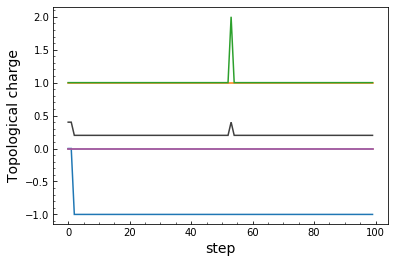

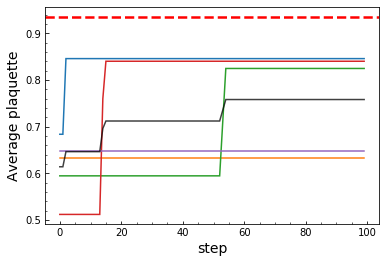

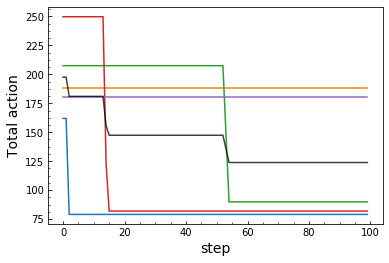

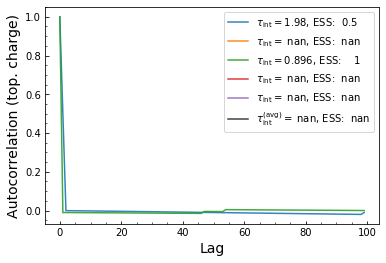

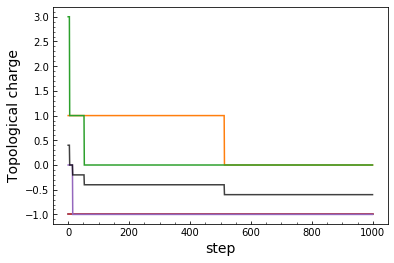

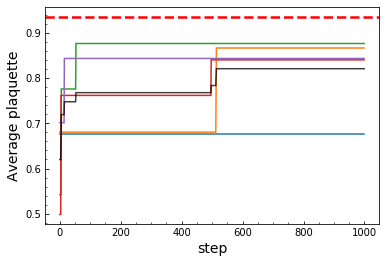

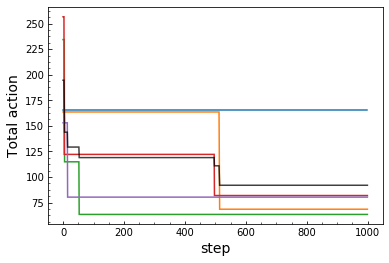

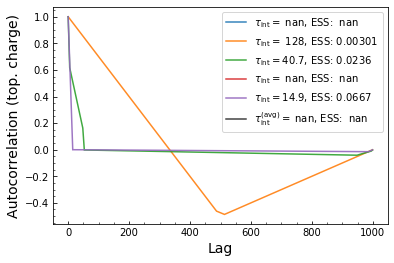

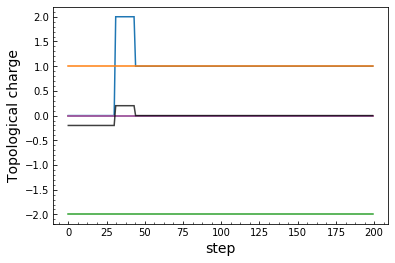

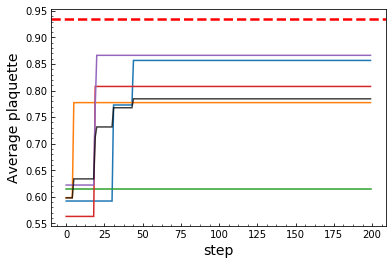

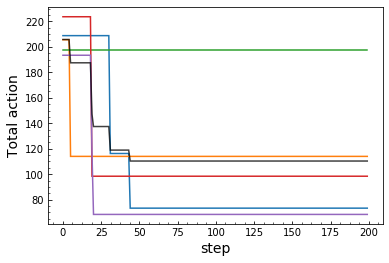

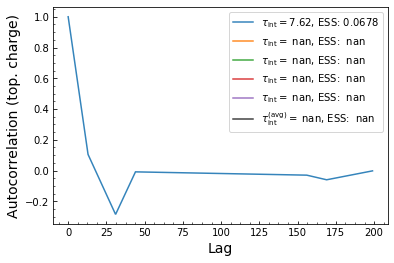

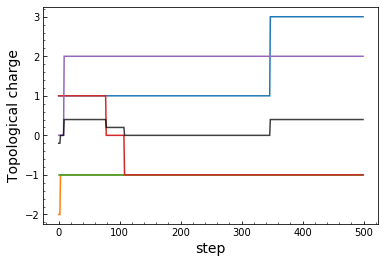

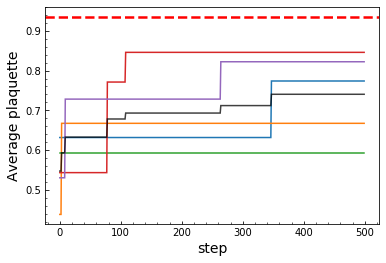

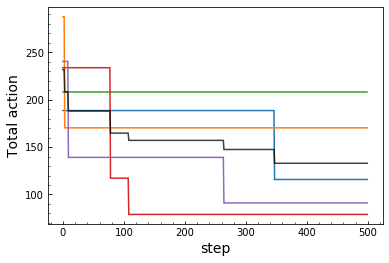

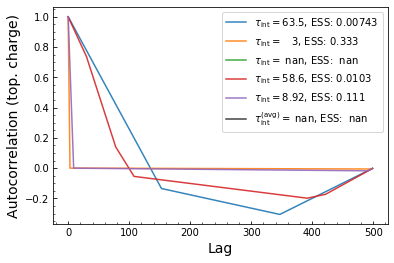

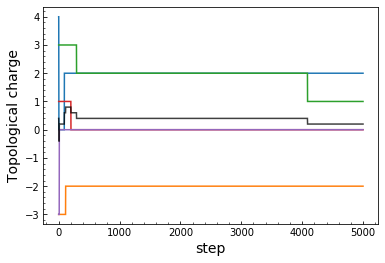

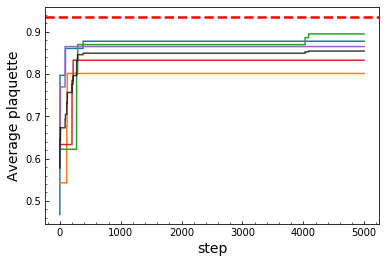

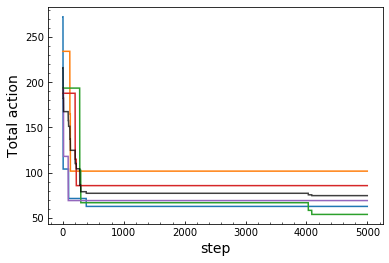

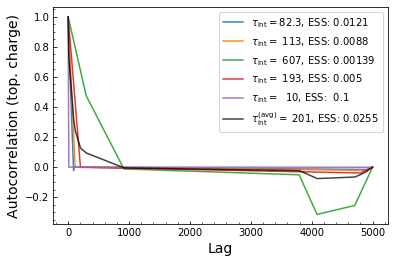

In [113]:
for key in observables.keys():
    _figs_dir = figs_dir_dict[key]
    _actions = actions[key]
    _avg_plaquettes = avg_plaquettes[key]
    _top_charges = top_charges[key]
    _top_charges_autocorr = top_charges_autocorr[key]
    _observables = (_actions, _avg_plaquettes, _top_charges)
    
    kwargs = {
        'figs_dir': _figs_dir
    }
    
    figs_axes = make_multiple_lines_plots(
        params['beta_final'], 
        _observables,
        **kwargs
    )
    
    _acf_arr = acf_dict[key]
    _iat_arr = iat_dict[key]
    _ess_arr = ess_dict[key]
    fig, ax = _plot_individual_acf_iat(_acf_arr, _iat_arr, _ess_arr, _figs_dir)

#### Topological charge history

Making directory: ../../gauge_logs_graph/run_63/figures/figures_100/top_charges_figs
Saving figure to: ../../gauge_logs_graph/run_63/figures/figures_100/top_charges_figs/top_charge_history_sample_0.pdf.
Saving figure to: ../../gauge_logs_graph/run_63/figures/figures_100/top_charges_figs/top_charge_history_sample_1.pdf.
Saving figure to: ../../gauge_logs_graph/run_63/figures/figures_100/top_charges_figs/top_charge_history_sample_2.pdf.
Saving figure to: ../../gauge_logs_graph/run_63/figures/figures_100/top_charges_figs/top_charge_history_sample_3.pdf.
Saving figure to: ../../gauge_logs_graph/run_63/figures/figures_100/top_charges_figs/top_charge_history_sample_4.pdf.
Making directory: ../../gauge_logs_graph/run_63/figures/figures_1000/top_charges_figs
Saving figure to: ../../gauge_logs_graph/run_63/figures/figures_1000/top_charges_figs/top_charge_history_sample_0.pdf.
Saving figure to: ../../gauge_logs_graph/run_63/figures/figures_1000/top_charges_figs/top_charge_history_sample_1.pdf.
S

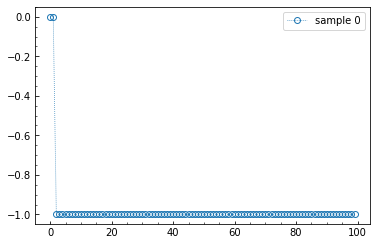

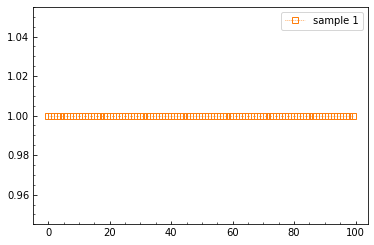

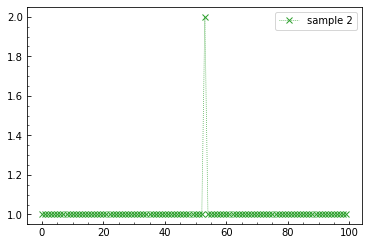

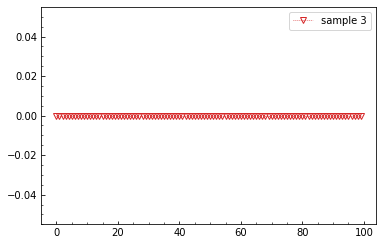

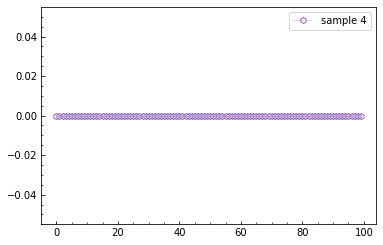

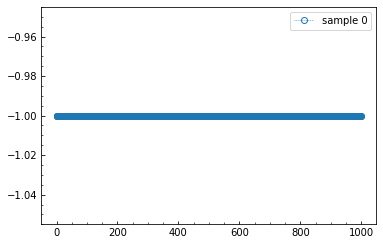

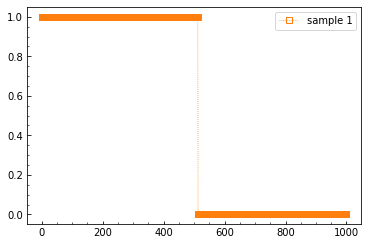

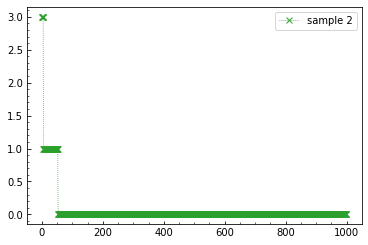

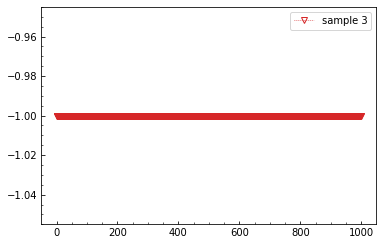

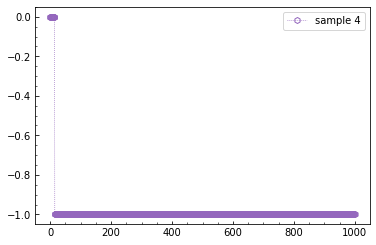

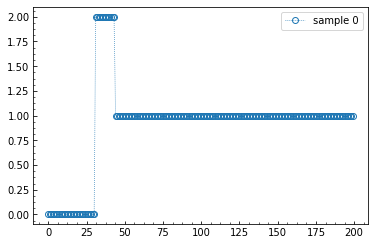

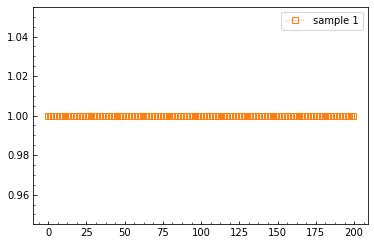

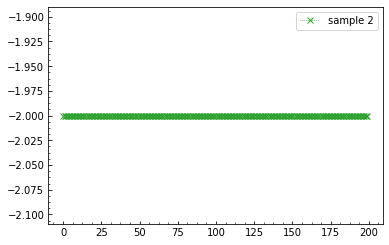

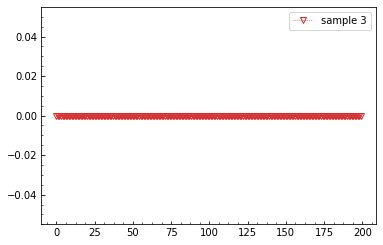

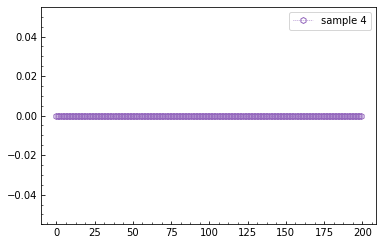

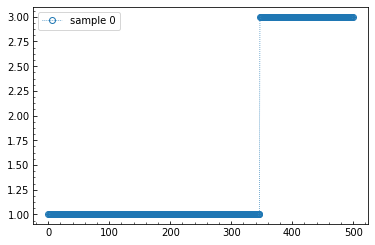

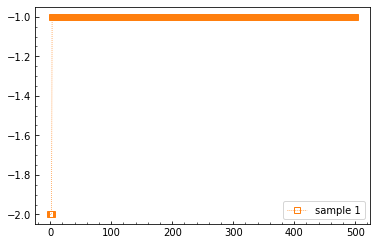

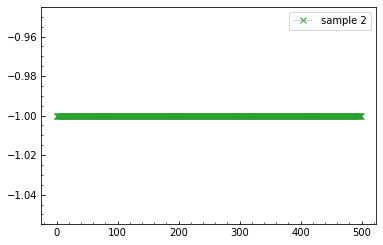

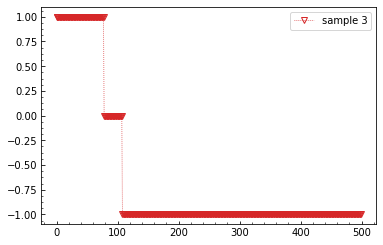

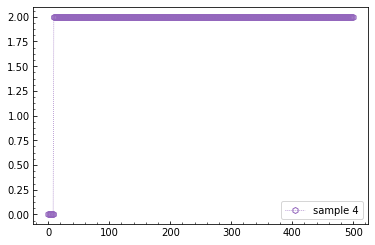

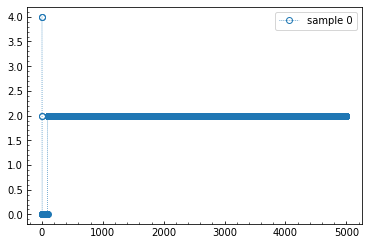

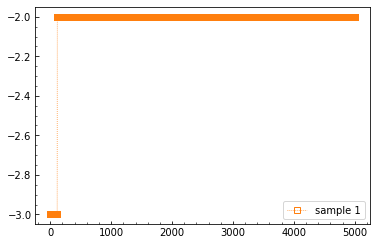

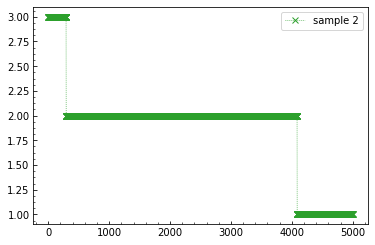

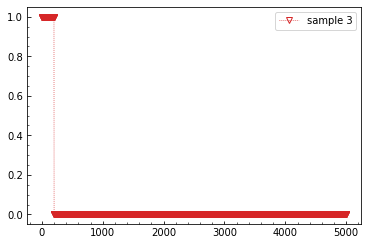

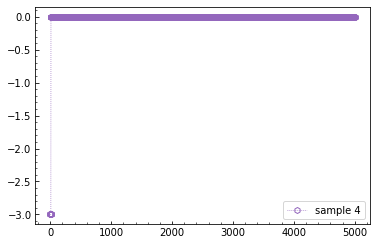

In [114]:
for key, val in top_charges.items():
    root_dir = figs_dir_dict[key]
    fig_dir = os.path.join(root_dir, 'top_charges_figs')
    check_else_make_dir(fig_dir)
    for idx in range(val.shape[1]):
        fig, ax = plt.subplots()
        _ = ax.plot(val[:, idx], label=f'sample {idx}', 
                    color=COLORS[idx], marker=MARKERS[idx], fillstyle='none', 
                    ls=':', lw=0.75)
        _ = ax.legend(loc='best')
        out_file = os.path.join(fig_dir, 
                                f'top_charge_history_sample_{idx}.pdf')
        print(f'Saving figure to: {out_file}.')
        _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')

#### Histograms for topological charge

Making directory: ../../gauge_logs_graph/run_63/figures/figures_100/top_charges_histograms
Saving figure to: ../../gauge_logs_graph/run_63/figures/figures_100/top_charges_histograms/top_charge_history_sample_0_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_63/figures/figures_100/top_charges_histograms/top_charge_history_sample_1_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_63/figures/figures_100/top_charges_histograms/top_charge_history_sample_2_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_63/figures/figures_100/top_charges_histograms/top_charge_history_sample_3_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_63/figures/figures_100/top_charges_histograms/top_charge_history_sample_4_histogram.pdf
Making directory: ../../gauge_logs_graph/run_63/figures/figures_1000/top_charges_histograms
Saving figure to: ../../gauge_logs_graph/run_63/figures/figures_1000/top_charges_histograms/top_charge_history_sample_0_histogram.pdf
Saving figure to: 

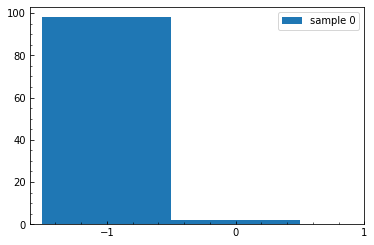

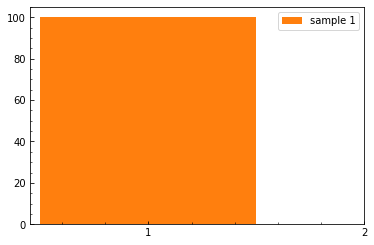

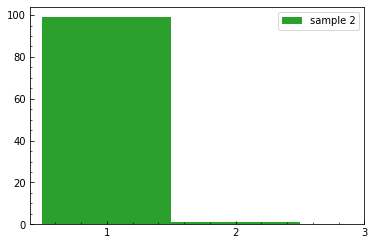

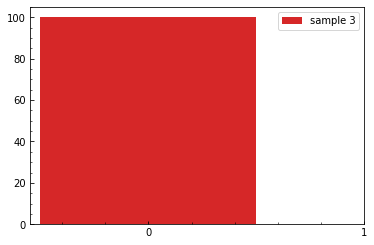

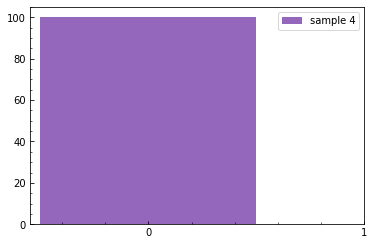

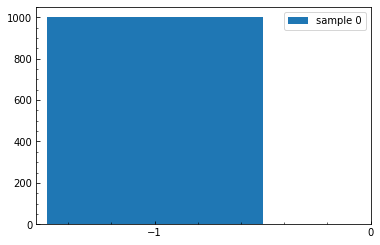

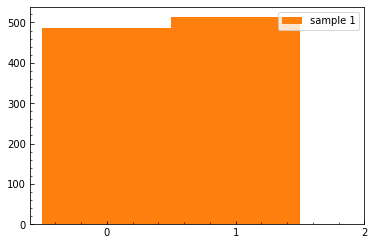

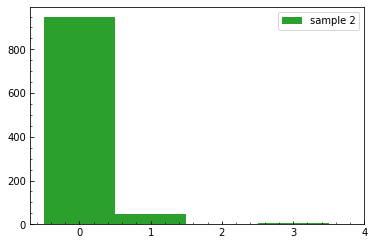

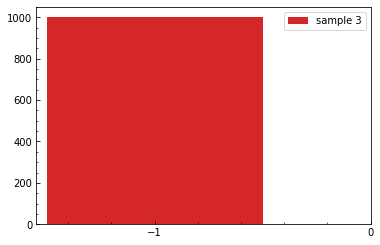

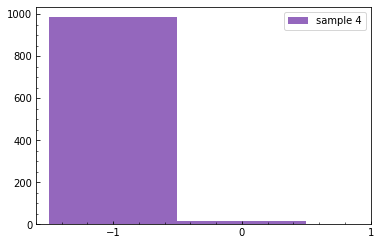

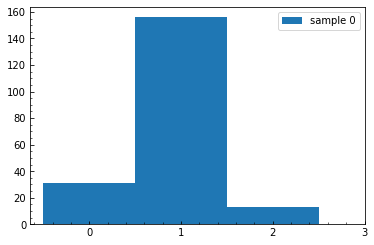

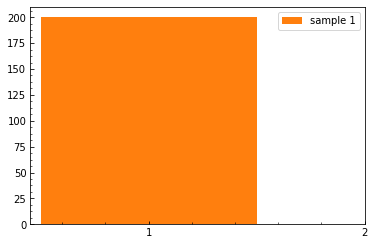

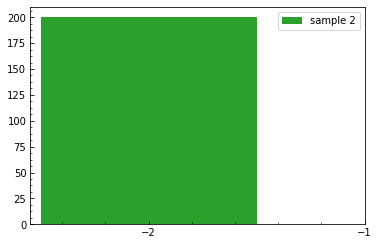

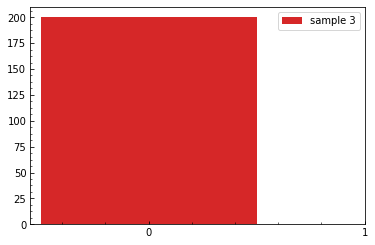

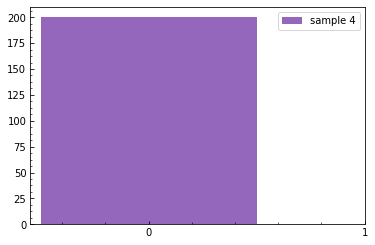

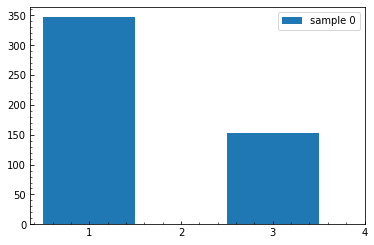

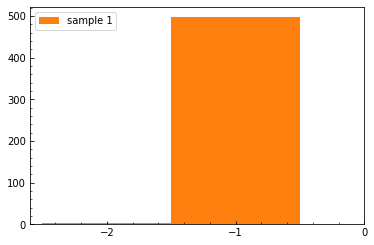

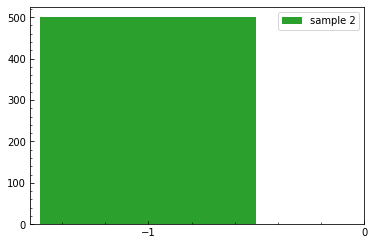

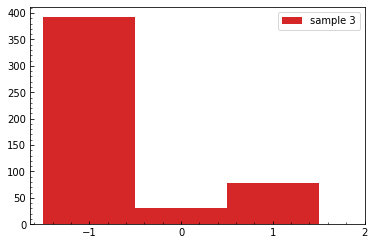

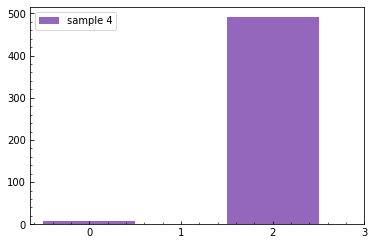

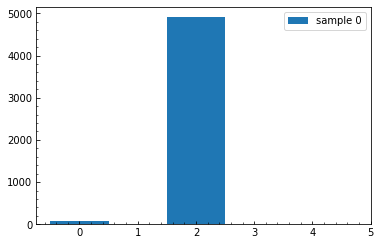

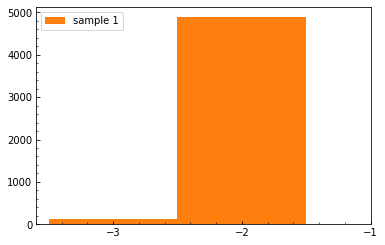

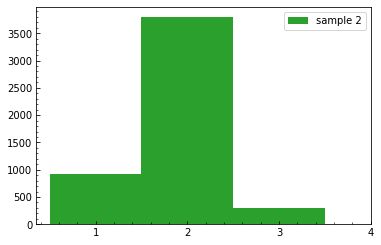

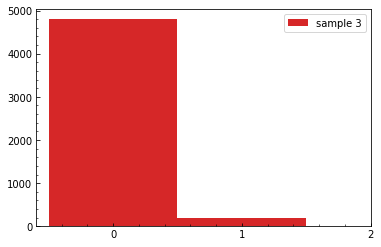

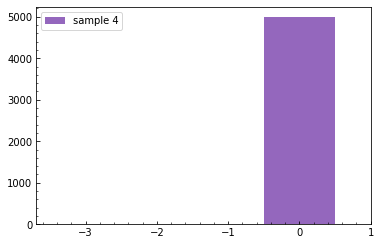

In [115]:
plt.close('all')
for key, val in top_charges.items():
    root_dir = figs_dir_dict[key]
    fig_dir = os.path.join(root_dir, 'top_charges_histograms')
    check_else_make_dir(fig_dir)
    for idx in range(val.shape[1]):
        fig, ax = plt.subplots()
        # the trick is to set up the bins centered on the integers, i.e.
        # -0.5, 0.5, 1,5, 2.5, ... up to max(data) + 1.5. 
        # Then you substract -0.5 to # eliminate the extra bin at the end.
        bins = np.arange(val[:, idx].min(), val[:, idx].max() + 1.5) - 0.5
        _ = ax.hist(
            val[:, idx], 
            bins, 
            color=COLORS[idx], 
            label=f'sample {idx}'
        )
        _ = ax.set_xticks(bins + 0.5)
        #ax.hist(val[:, idx])
        _ = ax.legend(loc='best')
        out_file = os.path.join(
            fig_dir, 
            f'top_charge_history_sample_{idx}_histogram.pdf'
        )
        print(f'Saving figure to: {out_file}')
        _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [13]:
plt.close('all')

In [14]:
from scipy.optimize import curve_fit

In [52]:
def exp_fn(x, a, b, c, d):
    return a * np.exp(-b * (x - c))

In [65]:
def fit_exp_linear(t, y, C=0):
    y = y - C
    y = np.log(y)
    K, A_log = np.polyfit(t, y, 1)
    A = np.exp(A_log)
    return A, K

In [66]:
def model_func(t, A, K, C):
    return A * np.exp(K * t) + C

In [62]:
ydata = actions[200][:, 0]
xdata = np.arange(len(ydata))

In [68]:
A, K = fit_exp_linear(xdata, ydata, C=0)
#fit_y = model_func(t, A, K, C0)
plot(ax2, t, y, noisy_y, fit_y, (A0, K0, C0), (A, K, 0))
ax2.set_title('Linear Fit')

In [69]:
popt, pcov = curve_fit(exp_fn, xdata, ydata)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Text(0.5, 0, 'Step')

Text(0, 0.5, 'Total action')

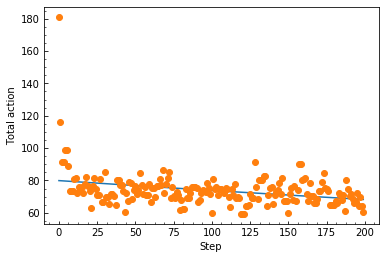

In [64]:
fig, ax = plt.subplots()
ax.plot(xdata, exp_fn(xdata, *popt), ls='-',
        label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
ax.plot(xdata, ydata, marker='o', ls='', label='Sample 0')
ax.set_xlabel('Step')
ax.set_ylabel('Total action')
plt.show()

## Look at observables from samples generated during training 

In [70]:
from utils.gauge_observables import (
    _load_samples_from_file, _load_params, _calc_observables,
)

In [107]:
params = {
    'time_size': 8,
    'space_size': 8,
    'link_type': 'U1',
    'dim': 2,
    'beta': 1.,
    'beta_init': 1.,
    'beta_final': 8.,
    'num_samples': 5,
    'num_steps': 5,
    'eps': 0.1,
    'loss_scale': 0.1,
    'loss_eps': 1e-4,
    'learning_rate_init': 1e-3,
    'learning_rate_decay_steps': 100,
    'learning_rate_decay_rate': 0.98,
    'train_steps': 10000,
    'save_steps': 1000,
    'logging_steps': 50,
    'annealing_steps': 50,
    'annealing_factor': 0.97,
    'clip_value': 10.,
    'rand': False,
    'metric': 'euc2',
    'training_samples_steps': 500,
    'training_samples_length': 100
}

save_params_to_pkl_file(params, info_dir)

Saving params to: ../../gauge_logs_graph/run_62/run_info/parameters.pkl.


In [108]:
log_dir = '../../gauge_logs_graph/run_63/'
samples_dir = os.path.join(log_dir, 'samples_history/')
train_samples_dir = os.path.join(samples_dir, 'training/')
info_dir = os.path.join(log_dir, 'run_info/')

params = {
    'time_size': 8,
    'space_size': 8,
    'link_type': 'U1',
    'dim': 2,
    'beta': 1.,
    'beta_init': 1.,
    'beta_final': 8.,
    'num_samples': 5,
    'num_steps': 5,
    'eps': 0.1,
    'loss_scale': 0.1,
    'loss_eps': 1e-4,
    'learning_rate_init': 1e-4,
    'learning_rate_decay_steps': 1000,
    'learning_rate_decay_rate': 0.98,
    'train_steps': 10000,
    'save_steps': 1000,
    'logging_steps': 50,
    'annealing_steps': 100,
    'annealing_factor': 0.97,
    'clip_value': 10.,
    'rand': False,
    'metric': 'euc2',
    'training_samples_steps': 500,
    'training_samples_length': 100
}

save_params_to_pkl_file(params, info_dir)

Saving params to: ../../gauge_logs_graph/run_63/run_info/parameters.pkl.


In [100]:
log_dir = '../../gauge_logs_graph/run_63/'
samples_dir = os.path.join(log_dir, 'samples_history/')
train_samples_dir = os.path.join(samples_dir, 'training/')
info_dir = os.path.join(log_dir, 'run_info/')

#save_params_to_pkl_file(params, info_dir)

params = _load_params(log_dir)

figs_dir = os.path.join(log_dir, 'figures')
samples_dict, actions_dict, plaqs_dict, charges_dict = {}, {}, {}, {}

In [101]:
train_samples_files = [train_samples_dir + i 
                       for i in os.listdir(train_samples_dir) 
                       if i.endswith('.pkl')]
train_samples_files

['../../gauge_logs_graph/run_62/samples_history/training/samples_history_1000_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_62/samples_history/training/samples_history_1500_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_62/samples_history/training/samples_history_2000_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_62/samples_history/training/samples_history_2500_TRAIN_100.pkl',
 '../../gauge_logs_graph/run_62/samples_history/training/samples_history_500_TRAIN_100.pkl']

In [102]:
step_keys = sorted(
    [int(i.split('/')[-1].split('_')[2]) for i in train_samples_files]
)
step_keys

[500, 1000, 1500, 2000, 2500]

In [103]:
training_figs_dir = os.path.join(figs_dir, 'training/')
check_else_make_dir(training_figs_dir)
training_steps_figs_dir = {}

for key in step_keys:
    _dir = os.path.join(training_figs_dir, f'{key}_train_steps/')
    check_else_make_dir(_dir)
    training_steps_figs_dir[key] = _dir

Making directory: ../../gauge_logs_graph/run_62/figures/training/1500_train_steps/
Making directory: ../../gauge_logs_graph/run_62/figures/training/2000_train_steps/
Making directory: ../../gauge_logs_graph/run_62/figures/training/2500_train_steps/


In [104]:
for idx, sample_file in enumerate(train_samples_files):
    step = step_keys[idx]
    if step not in charges_dict.keys():
        print(f"Calculating observables for {step}...")
        with open(sample_file, 'rb') as f:
            samples = pickle.load(f)

        actions, plaqs, charges = _calc_observables(samples, params)

        actions_dict[step] = actions
        plaqs_dict[step] = plaqs
        charges_dict[step] = charges

Calculating observables for 500...
step: 0 time/step: 0.3882 avg action: 317.4  avg plaquette: 0.3802 top charges: 


[0, 1, 1, -4, 0]


step: 1 time/step: 0.3808 avg action:  232   avg plaquette: 0.5469 top charges: 


[0, 0, -1, 0, 0]


step: 2 time/step: 0.4501 avg action: 188.4  avg plaquette: 0.6321 top charges: 


[0, 0, 0, 0, 0]


step: 3 time/step: 0.2425 avg action:  149   avg plaquette: 0.7091 top charges: 


[1, 0, -1, 0, 0]


step: 4 time/step: 0.2962 avg action:  130   avg plaquette: 0.746  top charges: 


[0, 0, 0, 0, 0]


step: 5 time/step: 0.2705 avg action: 122.1  avg plaquette: 0.7616 top charges: 


[0, 0, -1, 0, 0]


step: 6 time/step: 0.3589 avg action: 111.3  avg plaquette: 0.7826 top charges: 


[0, 0, 0, 0, 0]


step: 7 time/step: 0.2356 avg action:  104   avg plaquette: 0.797  top charges: 


[0, 0, 0, 1, 0]


step: 8 time/step: 0.2954 avg action: 90.18  avg plaquette: 0.8239 top charges: 


[0, 0, -1, 0, 0]


step: 9 time/step: 0.4013 avg action: 82.92  avg pl

step: 80 time/step:  0.28  avg action: 46.01  avg plaquette: 0.9101 top charges: 


[1, 1, 0, 0, 0]


step: 81 time/step: 0.285  avg action:  45.4  avg plaquette: 0.9113 top charges: 


[1, 1, 0, 1, 0]


step: 82 time/step: 0.2879 avg action: 48.19  avg plaquette: 0.9059 top charges: 


[0, 1, 0, 0, 0]


step: 83 time/step: 0.2345 avg action: 46.68  avg plaquette: 0.9088 top charges: 


[0, 1, -1, 0, 0]


step: 84 time/step: 0.234  avg action:   46   avg plaquette: 0.9102 top charges: 


[0, 1, -1, 0, 0]


step: 85 time/step: 0.2888 avg action: 47.57  avg plaquette: 0.9071 top charges: 


[0, 1, -1, 0, 0]


step: 86 time/step: 0.2351 avg action: 47.01  avg plaquette: 0.9082 top charges: 


[0, 1, 0, 0, 0]


step: 87 time/step: 0.2401 avg action: 47.01  avg plaquette: 0.9082 top charges: 


[0, 1, 0, 0, 0]


step: 88 time/step: 0.2456 avg action: 47.01  avg plaquette: 0.9082 top charges: 


[0, 1, 0, 0, 0]


step: 89 time/step: 0.3045 avg action: 46.28  avg plaquette: 0.9096 top charges

step: 60 time/step: 0.3592 avg action: 44.54  avg plaquette: 0.913  top charges: 


[0, 1, 0, 0, 0]


step: 61 time/step: 0.3455 avg action: 43.44  avg plaquette: 0.9152 top charges: 


[0, 1, 0, 0, 0]


step: 62 time/step: 0.4187 avg action: 43.44  avg plaquette: 0.9152 top charges: 


[0, 1, 0, 0, 0]


step: 63 time/step: 0.3503 avg action:  43.2  avg plaquette: 0.9156 top charges: 


[0, 0, 0, 0, 0]


step: 64 time/step: 0.5131 avg action: 44.63  avg plaquette: 0.9128 top charges: 


[0, 0, 0, 0, 0]


step: 65 time/step: 0.3165 avg action: 43.72  avg plaquette: 0.9146 top charges: 


[0, 0, 0, 0, -1]


step: 66 time/step: 0.2564 avg action: 44.69  avg plaquette: 0.9127 top charges: 


[0, 1, 0, 0, -1]


step: 67 time/step: 0.3412 avg action: 45.02  avg plaquette: 0.9121 top charges: 


[0, 1, 0, 0, -1]


step: 68 time/step: 0.2109 avg action: 45.02  avg plaquette: 0.9121 top charges: 


[0, 1, 0, 0, -1]


step: 69 time/step: 0.3415 avg action: 42.71  avg plaquette: 0.9166 top charge

step: 40 time/step: 0.3562 avg action: 50.44  avg plaquette: 0.9015 top charges: 


[0, 0, 0, 1, 0]


step: 41 time/step: 0.4757 avg action: 49.45  avg plaquette: 0.9034 top charges: 


[0, 0, 0, 1, 0]


step: 42 time/step: 0.2977 avg action: 49.45  avg plaquette: 0.9034 top charges: 


[0, 0, 0, 1, 0]


step: 43 time/step: 0.3695 avg action: 49.45  avg plaquette: 0.9034 top charges: 


[0, 0, 0, 1, 0]


step: 44 time/step: 0.4101 avg action: 49.45  avg plaquette: 0.9034 top charges: 


[0, 0, 0, 1, 0]


step: 45 time/step: 0.3571 avg action: 49.45  avg plaquette: 0.9034 top charges: 


[0, 0, 0, 1, 0]


step: 46 time/step: 0.4092 avg action: 48.21  avg plaquette: 0.9058 top charges: 


[0, 0, 0, 0, 0]


step: 47 time/step: 0.376  avg action: 49.54  avg plaquette: 0.9032 top charges: 


[0, 0, 0, 0, 0]


step: 48 time/step: 0.3375 avg action: 50.29  avg plaquette: 0.9018 top charges: 


[0, 0, 0, 0, 0]


step: 49 time/step: 0.5095 avg action: 50.29  avg plaquette: 0.9018 top charges: 


step: 20 time/step: 0.6819 avg action: 61.07  avg plaquette: 0.8807 top charges: 


[-1, 0, -1, 0, 0]


step: 21 time/step: 0.2564 avg action: 61.07  avg plaquette: 0.8807 top charges: 


[-1, 0, -1, 0, 0]


step: 22 time/step: 1.367  avg action: 61.07  avg plaquette: 0.8807 top charges: 


[-1, 0, -1, 0, 0]


step: 23 time/step: 0.6471 avg action: 58.49  avg plaquette: 0.8858 top charges: 


[-1, 0, 0, 0, 0]


step: 24 time/step: 0.4706 avg action: 57.85  avg plaquette: 0.887  top charges: 


[-1, 0, 0, 0, 0]


step: 25 time/step: 0.7237 avg action: 57.85  avg plaquette: 0.887  top charges: 


[-1, 0, 0, 0, 0]


step: 26 time/step: 1.134  avg action:   57   avg plaquette: 0.8887 top charges: 


[-1, 0, 0, 0, 0]


step: 27 time/step: 0.6558 avg action: 55.93  avg plaquette: 0.8908 top charges: 


[-1, 0, 0, 0, 0]


step: 28 time/step: 0.4718 avg action: 55.93  avg plaquette: 0.8908 top charges: 


[-1, 0, 0, 0, 0]


step: 29 time/step: 0.251  avg action: 55.93  avg plaquette: 0.8908 to

step: 1 time/step: 0.2416 avg action: 221.8  avg plaquette: 0.5668 top charges: 


[0, 1, -1, -1, 0]


step: 2 time/step: 0.1526 avg action: 199.4  avg plaquette: 0.6106 top charges: 


[0, 2, -1, -1, 0]


step: 3 time/step: 0.1403 avg action: 185.9  avg plaquette: 0.637  top charges: 


[0, 1, 0, -1, 0]


step: 4 time/step: 0.1564 avg action:  162   avg plaquette: 0.6836 top charges: 


[0, 1, 0, -1, 0]


step: 5 time/step: 0.1497 avg action: 153.7  avg plaquette: 0.6999 top charges: 


[0, 1, 0, -1, 0]


step: 6 time/step: 0.1508 avg action: 143.7  avg plaquette: 0.7194 top charges: 


[0, 2, 0, -1, 0]


step: 7 time/step: 0.09695 avg action: 132.1  avg plaquette: 0.7421 top charges: 


[0, 2, 0, -1, 0]


step: 8 time/step: 0.09946 avg action: 127.5  avg plaquette: 0.751  top charges: 


[0, 1, 0, -1, 0]


step: 9 time/step: 0.1115 avg action: 122.7  avg plaquette: 0.7603 top charges: 


[0, 1, 0, -1, 0]


step: 10 time/step: 0.1109 avg action: 112.1  avg plaquette: 0.781  top charge

step: 81 time/step: 0.1281 avg action: 43.65  avg plaquette: 0.9148 top charges: 


[0, 0, 0, -1, 0]


step: 82 time/step: 0.1595 avg action: 43.06  avg plaquette: 0.9159 top charges: 


[0, 0, 0, -1, 0]


step: 83 time/step: 0.1384 avg action: 43.56  avg plaquette: 0.9149 top charges: 


[0, 0, 0, -1, 0]


step: 84 time/step: 0.1875 avg action: 43.56  avg plaquette: 0.9149 top charges: 


[0, 0, 0, -1, 0]


step: 85 time/step: 0.2072 avg action: 43.44  avg plaquette: 0.9152 top charges: 


[0, 0, 0, -1, 0]


step: 86 time/step: 0.166  avg action: 44.55  avg plaquette: 0.913  top charges: 


[0, 0, 0, -1, 0]


step: 87 time/step: 0.1564 avg action: 46.38  avg plaquette: 0.9094 top charges: 


[0, 1, 0, -1, 0]


step: 88 time/step: 0.1413 avg action: 43.29  avg plaquette: 0.9154 top charges: 


[0, 0, 0, -1, 0]


step: 89 time/step: 0.1503 avg action:  42.9  avg plaquette: 0.9162 top charges: 


[0, 0, 0, -1, 0]


step: 90 time/step: 0.1961 avg action: 45.87  avg plaquette: 0.9104 top c

Saving figure to ../../gauge_logs_graph/run_62/figures/training/500_train_steps/average_plaquette_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_62/figures/training/500_train_steps/average_action_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_62/figures/training/1000_train_steps/average_plaquette_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_62/figures/training/1000_train_steps/average_action_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_62/figures/training/1500_train_steps/average_plaquette_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_62/figures/training/1500_train_steps/average_action_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_62/figures/training/2000_train_steps/average_plaquette_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_62/figures/training/2000_train_steps/average_action_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_62/figures/training/2500_train_steps/average_plaquette_vs_step.pdf.
Saving

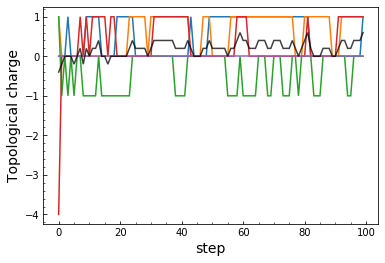

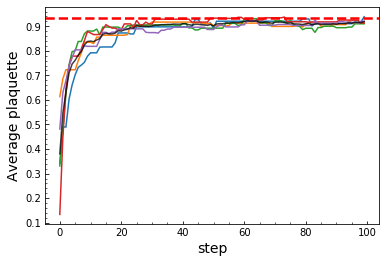

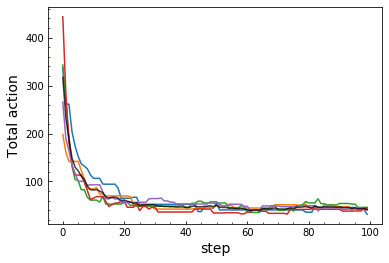

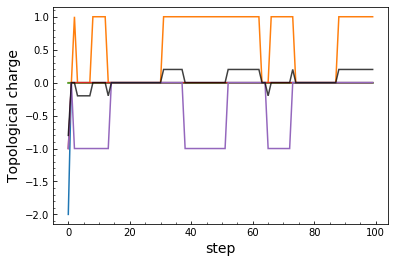

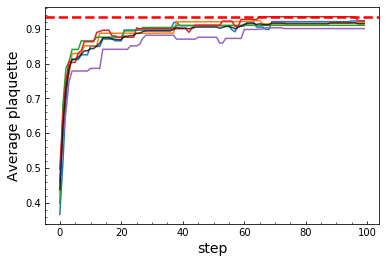

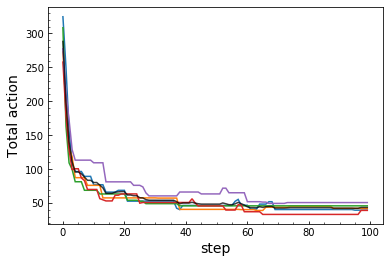

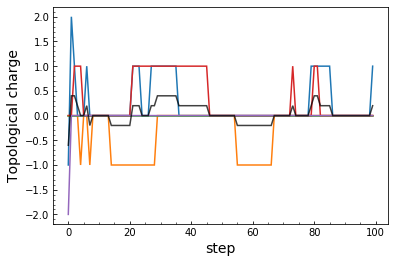

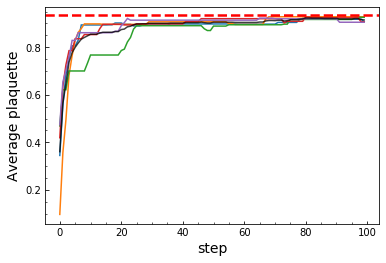

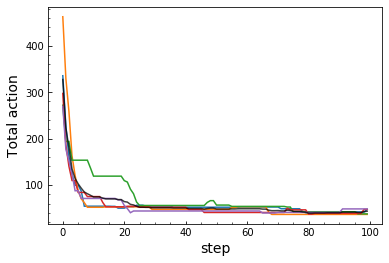

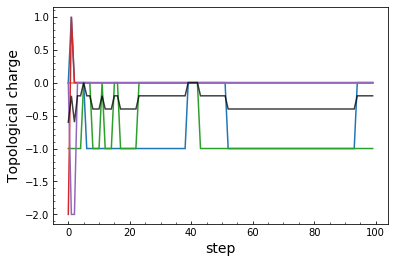

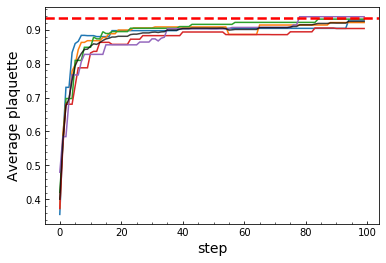

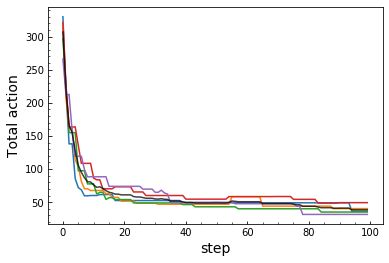

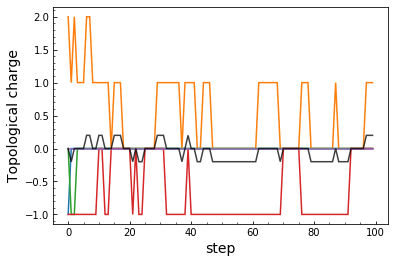

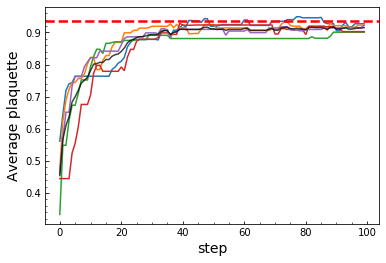

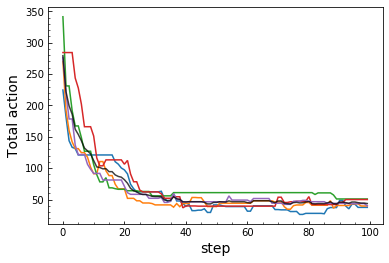

In [105]:
for key in charges_dict.keys():
    actions = actions_dict[key]
    plaqs = plaqs_dict[key]
    charges = charges_dict[key]
    observables = (actions, plaqs, charges)
    
    figs_axes = make_multiple_lines_plots(
        params['beta_final'],  
        observables, 
        figs_dir=training_steps_figs_dir[key]
    )

Saving figure to: ../../gauge_logs_graph/run_62/figures/training/500_train_steps/topological_charge_history_sample_0.pdf.
Saving figure to: ../../gauge_logs_graph/run_62/figures/training/500_train_steps/topological_charge_history_sample_1.pdf.
Saving figure to: ../../gauge_logs_graph/run_62/figures/training/500_train_steps/topological_charge_history_sample_2.pdf.
Saving figure to: ../../gauge_logs_graph/run_62/figures/training/500_train_steps/topological_charge_history_sample_3.pdf.
Saving figure to: ../../gauge_logs_graph/run_62/figures/training/500_train_steps/topological_charge_history_sample_4.pdf.
Saving figure to: ../../gauge_logs_graph/run_62/figures/training/1000_train_steps/topological_charge_history_sample_0.pdf.
Saving figure to: ../../gauge_logs_graph/run_62/figures/training/1000_train_steps/topological_charge_history_sample_1.pdf.
Saving figure to: ../../gauge_logs_graph/run_62/figures/training/1000_train_steps/topological_charge_history_sample_2.pdf.
Saving figure to: ../

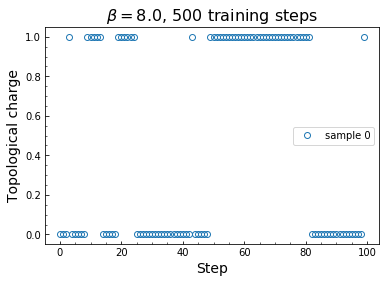

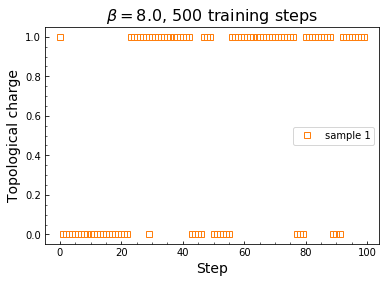

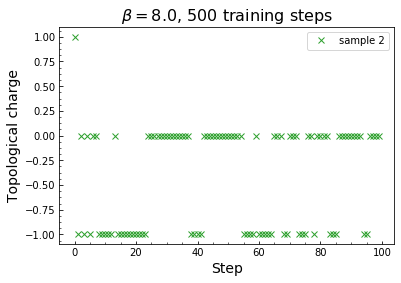

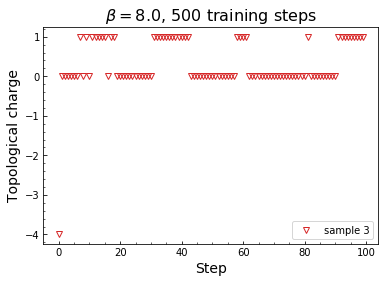

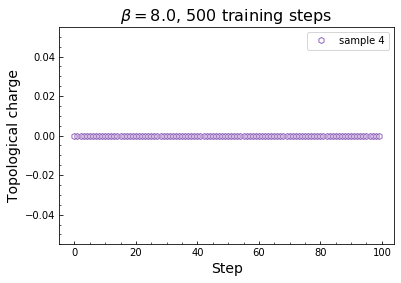

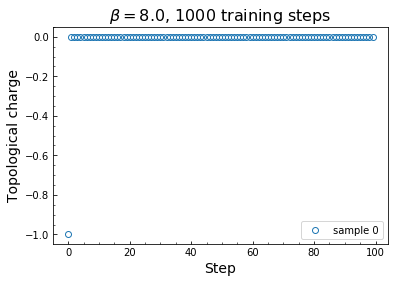

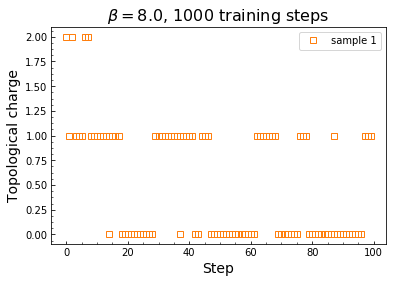

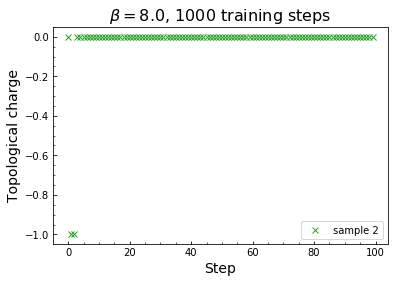

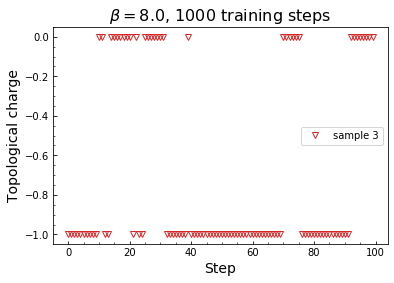

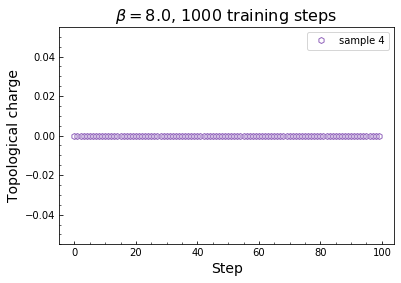

In [95]:
plt.close('all')
for key, val in charges_dict.items():
    for idx in range(val.shape[1]):
        fig, ax = plt.subplots()
        _ = ax.plot(val[:, idx], 
                    marker=MARKERS[idx], color=COLORS[idx], 
                    ls='', fillstyle='none', label=f'sample {idx}')
        _ = ax.legend(loc='best')
        _ = ax.set_xlabel('Step', fontsize=14)
        _ = ax.set_ylabel('Topological charge', fontsize=14)
        title_str = (r"$\beta =$"
                     + f"{params['beta_final']}, {key} training steps")
        _ = ax.set_title(title_str, fontsize=16)
        out_file = os.path.join(training_steps_figs_dir[key],
                                f'topological_charge_history_sample_{idx}.pdf')
        if not os.path.isfile(out_file):
            print(f"Saving figure to: {out_file}.")
            _ = fig.savefig(out_file, dpi=400, bbox_inches='tight')
        
        #_ = ax.set_title(fr"""$\beta =$ {params['beta_final']},"""
        #                 fr""" {key} training steps""")
                         

## OLD PLOTS

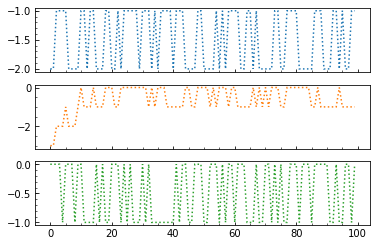

In [28]:
ax1 = plt.subplot(311)
_ = plt.plot(top_charges[100][:, 0], label=f'sample 1', color='C0', ls=':')
             #markersize=2.5, marker=MARKERS[0], ls=':')
_ = plt.setp(ax1.get_xticklabels(), visible=False)

# share x only
_ = ax2 = plt.subplot(312, sharex=ax1)
_ = plt.plot(top_charges[100][:, 1], label=f'sample 2', color='C1', ls=':')
             #markersize=2.5, marker=MARKERS[1], ls=':')
_ = plt.setp(ax2.get_xticklabels(), visible=False)

_ = ax3 = plt.subplot(313, sharex=ax1)
_ = plt.plot(top_charges[100][:, 2], label=f'sample 3', color='C2', ls=':')
             #markersize=2.5, marker=MARKERS[2], ls=':')
#_ = plt.setp(ax3.get_xticklabels(), visible=False)

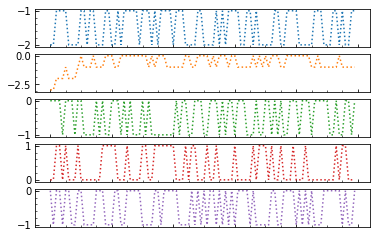

In [27]:
MARKERS = ['o', 's', 'x', 'v', 'h', '^', 'p', '<', 'd', '>', 'o']
LINESTYLES = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']

ax1 = plt.subplot(511)

_ = plt.plot(top_charges[100][:, 0], label=f'sample 1', color='C0', ls=':')
             #markersize=2.5, marker=MARKERS[0], ls=':')
_ = plt.setp(ax1.get_xticklabels(), visible=False)

# share x only
_ = ax2 = plt.subplot(512, sharex=ax1)
_ = plt.plot(top_charges[100][:, 1], label=f'sample 2', color='C1', ls=':')
             #markersize=2.5, marker=MARKERS[1], ls=':')
_ = plt.setp(ax2.get_xticklabels(), visible=False)

_ = ax3 = plt.subplot(513, sharex=ax1)
_ = plt.plot(top_charges[100][:, 2], label=f'sample 3', color='C2', ls=':')
             #markersize=2.5, marker=MARKERS[2], ls=':')
_ = plt.setp(ax3.get_xticklabels(), visible=False)

_ = ax4 = plt.subplot(514, sharex=ax1)
_ = plt.plot(top_charges[100][:, 3], label=f'sample 4', color='C3', ls=':')
             #markersize=2.5, marker=MARKERS[3], ls=':')
_ = plt.setp(ax4.get_xticklabels(), visible=False)

_ = ax5 = plt.subplot(515, sharex=ax1)
_ = plt.plot(top_charges[100][:, 4], label=f'sample 5', color='C4', ls=':')
             #markersize=2.5, marker=MARKERS[4], ls=':')
_ = plt.setp(ax5.get_xticklabels(), visible=False)

out_file = os.path.join(figs_dir_dict[100], 'top_charges_sharedx.pdf')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [116]:
plt.close('all')

In [ ]:
# Create plots for observables.
multiple_lines_figs_axes = make_multiple_lines_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Create plots for observables with broken x-axes.
broken_xaxis_figs_axes = make_broken_xaxis_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Plot lag k autocorrelation function of topological charge
# Plot topological charges autocorrelation function using the 
# built-in `pandas.plotting.autocorrelation_plot` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        pandas_autocorr_dir, 
        f'top_charges_autocorr_pandas_{idx}.pdf'
    )
    fig, ax = make_pandas_autocorrelation_plot(
        top_charges[:, idx],
        x_label='Lag',
        y_label='Autocorrelation (top. charge)',
        out_file=out_file
    )
    
# Plot topological charges autocorrelation function using the 
# built-in matplotlib `acorr` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        matplotlib_autocorr_dir, 
        f'top_charges_autocorr_matplotlib_{idx}.pdf'
    )
    kwargs = {'x_label': 'Lag',
              'y_label': 'Autocorrelation (top. charge)',
              'label': f'sample {idx}',
              'out_file': out_file,
              'color': COLORS[idx]}
    output = make_matplotlib_autocorrelation_plot(
        top_charges[:, idx],
        **kwargs
    )
    
# Compute and plot the samples autocorrelation spectrum.
# This is done by computing the autocorrelation function of each 
# individual link and then averaging over all links in the sample.
out_file = os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf')
fig, ax = make_samples_acl_spectrum_plot(samples, out_file=out_file)

    
# Compute the integrated autocorrelation time (IAT) 
# from top. charges data using `tau` from `utils/gauge_observables`
out_file = os.path.join(figs_dir, 'integrated_autocorrelation_time_plot.pdf')
kwargs = {
    'x_label': 'Lag',
    'y_label': 'Autocorrelation (top. charge)',
    'legend': True,
    'out_file': out_file
}
fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ESS_arr, **kwargs)
#fig, ax = calc_integrated_autocorr_time_with_plots(top_charges, **kwargs)
#_ = ax.legend(bbox_to_anchor=(1, 0), loc="lower left",
#              bbox_transform=ax.transAxes, columnspacing=0.5, ncol=1)
#print(f"Saving figure to: {out_file}")
#plt.savefig(out_file, dpi=400, bbox_inches='tight')

Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/topological_charge_autocorr_fn.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/topological_charge_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/average_action_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/topological_charge_autocorr_fn_broken_xaxis.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/average_action_vs_step_broken_xaxis.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/autocorrelation_plots/pandas_autocorrel

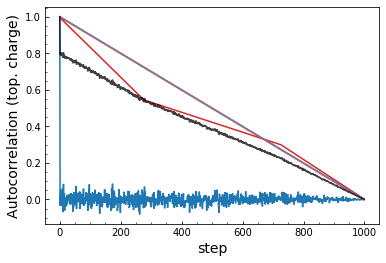

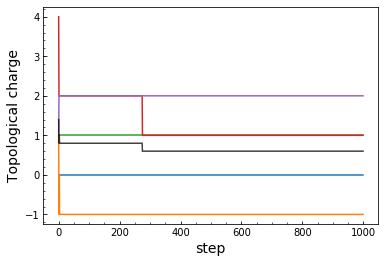

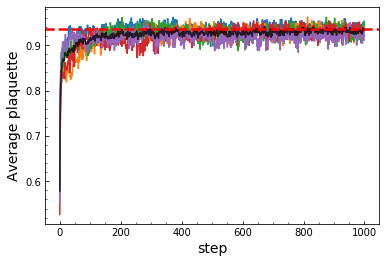

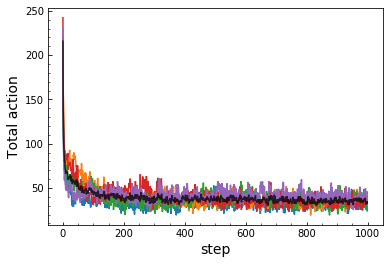

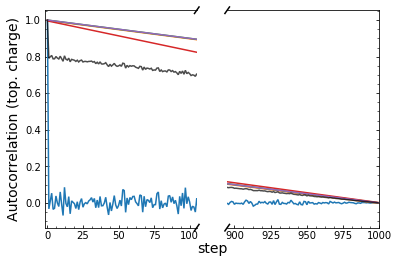

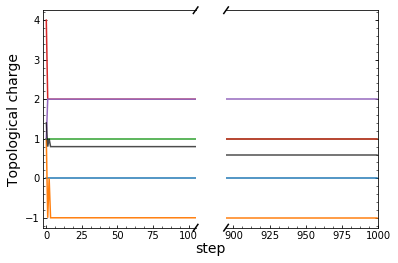

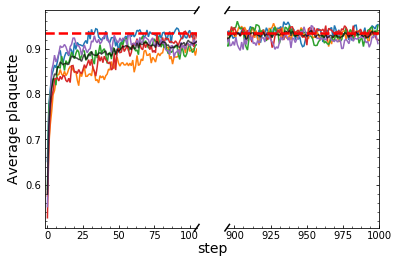

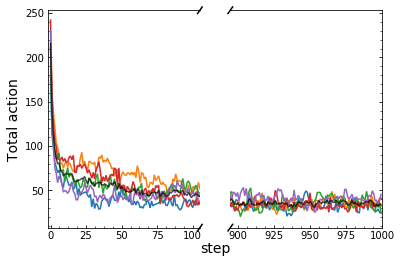

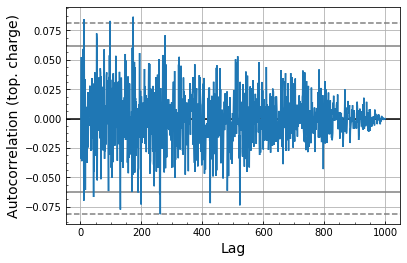

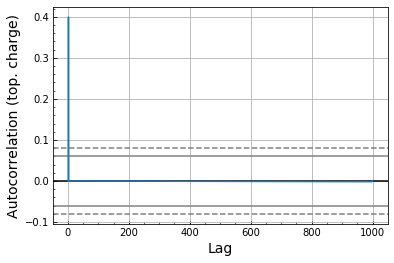

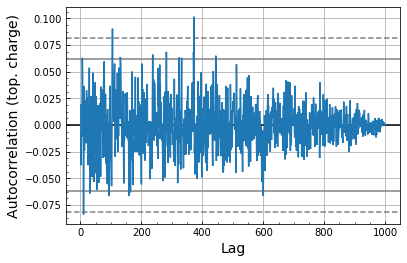

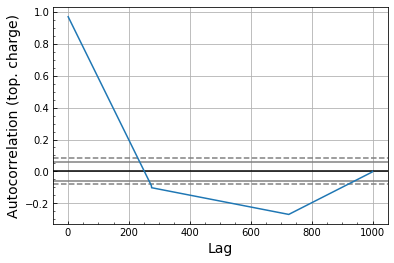

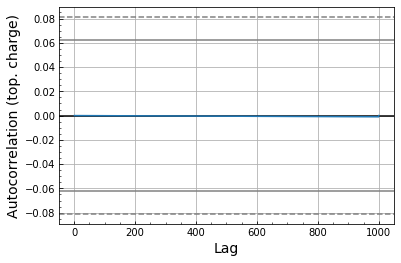

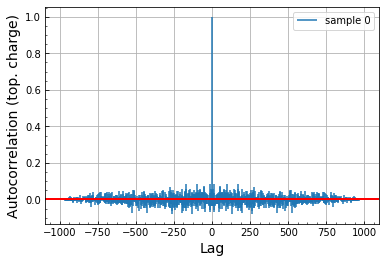

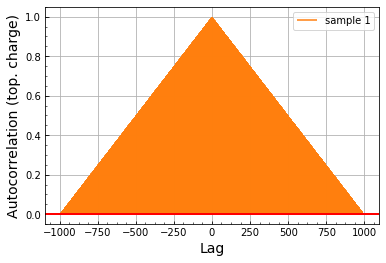

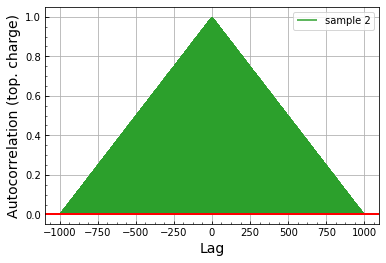

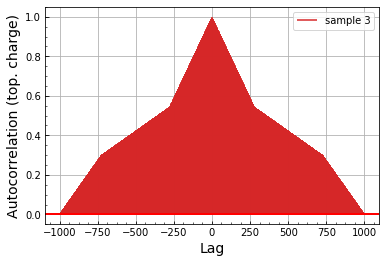

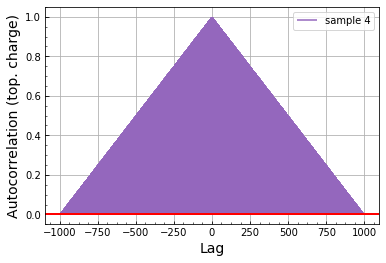

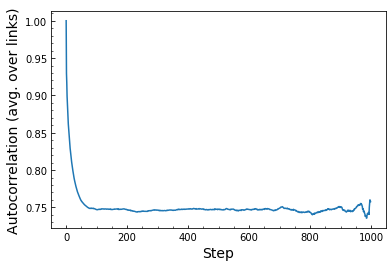

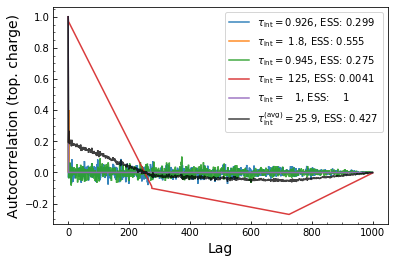

In [8]:
# Create plots for observables.

multiple_lines_figs_axes = make_multiple_lines_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Create plots for observables with broken x-axes.
broken_xaxis_figs_axes = make_broken_xaxis_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Plot lag k autocorrelation function of topological charge
# Plot topological charges autocorrelation function using the 
# built-in `pandas.plotting.autocorrelation_plot` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        pandas_autocorr_dir, 
        f'top_charges_autocorr_pandas_{idx}.pdf'
    )
    fig, ax = make_pandas_autocorrelation_plot(
        top_charges[:, idx],
        x_label='Lag',
        y_label='Autocorrelation (top. charge)',
        out_file=out_file
    )
    
# Plot topological charges autocorrelation function using the 
# built-in matplotlib `acorr` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        matplotlib_autocorr_dir, 
        f'top_charges_autocorr_matplotlib_{idx}.pdf'
    )
    kwargs = {'x_label': 'Lag',
              'y_label': 'Autocorrelation (top. charge)',
              'label': f'sample {idx}',
              'out_file': out_file,
              'color': COLORS[idx]}
    output = make_matplotlib_autocorrelation_plot(
        top_charges[:, idx],
        **kwargs
    )
    
# Compute and plot the samples autocorrelation spectrum.
# This is done by computing the autocorrelation function of each 
# individual link and then averaging over all links in the sample.
out_file = os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf')
fig, ax = make_samples_acl_spectrum_plot(samples, out_file=out_file)

# Compute the integrated autocorrelation time (IAT) 
# from top. charges data using `tau` from `utils/gauge_observables`
out_file = os.path.join(figs_dir, 'integrated_autocorrelation_time_plot.pdf')
kwargs = {
    'x_label': 'Lag',
    'y_label': 'Autocorrelation (top. charge)',
    'legend': True,
    'out_file': out_file
}
fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ESS_arr, **kwargs)
#fig, ax = calc_integrated_autocorr_time_with_plots(top_charges, **kwargs)
#_ = ax.legend(bbox_to_anchor=(1, 0), loc="lower left",
#              bbox_transform=ax.transAxes, columnspacing=0.5, ncol=1)
#print(f"Saving figure to: {out_file}")
#plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [81]:
plt.close('all')

Saving figure to: ../../gauge_logs_graph/run_19/figures/integrated_autocorrelation_time_plot.pdf.


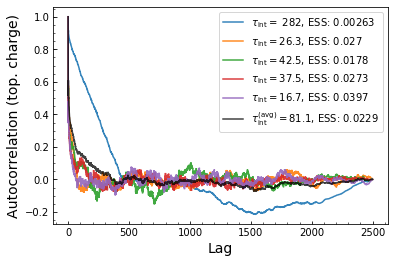

In [24]:
out_file = os.path.join(figs_dir, 'integrated_autocorrelation_time_plot.pdf')
kwargs = {
    'x_label': 'Lag',
    'y_label': 'Autocorrelation (top. charge)',
    'legend': True,
    'out_file': out_file
}
fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ESS_arr, **kwargs)

# OLD

In [ ]:
np.mean(ESS_arr)

Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/autocorrelation_plots/matplotlib_autocorrelation_plots/top_charges_autocorr_matplotlib.pdf.


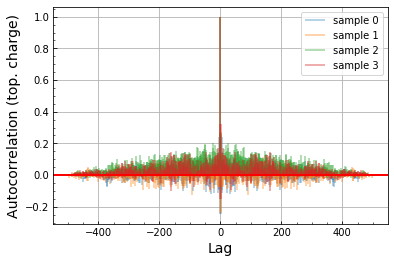

In [224]:
alphas = [0.3, 0.275, 0.25, 0.225, 0.2, 0.175, 
          0.15, 0.125, 0.1, 0.075, 0.05, 0.025][::-1]
out_file = os.path.join(matplotlib_autocorr_dir, 
                        'top_charges_autocorr_matplotlib.pdf')
fig, ax = plt.subplots()
for idx in range(top_charges.shape[1]):
    output = ax.acorr(top_charges[:, idx], usevlines=True, color=COLORS[idx],
                      normed=True, maxlags=None,
                      alpha=alphas[idx]+0.4, #zorder=zorders[idx],
                      label=f'sample {idx}')

_ = ax.axhline(0, color='r', lw=2)
_ = ax.grid(True)
_ = ax.legend(loc='best')
    
_ = ax.set_xlabel("Lag", fontsize=14)
_ = ax.set_ylabel("Autocorrelation (top. charge)", fontsize=14)
print(f'Saving figure to: {out_file}.')
_ = plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [300]:
lattice = GaugeLattice(8, 8, 2, 8., 'U1', 5, False)

In [301]:
lattice.num_links

128

##### Old approach (unsure of validity)

In [25]:
len_by_4 = len(top_charges) // 4
len_by_2 = len(top_charges) // 2
len_by_10 = len(top_charges) // 10
kappa4 = len(top_charges) - len_by_4
kappa2 = len(top_charges) - len_by_2
kappa10 = len(top_charges) - len_by_10
iac2, autocorr2 = calc_iat(top_charges.mean(axis=1), kappa=kappa2)
iac4, autocorr4 = calc_iat(top_charges.mean(axis=1), kappa=kappa4)
iac10, autocorr10 = calc_iat(top_charges.mean(axis=1), kappa=kappa10)

In [26]:
iac2, iac4, iac10

(2.1520862694468614, 1.5014179402207577, 1.9374474465140532)

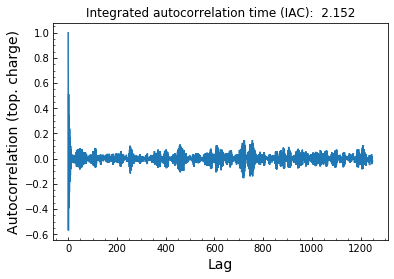

In [27]:
out_file = os.path.join(autocorr_dir, 
                        f'integrated_autocorrelation_time_plot_{kappa2}.pdf')

fig, ax = plt.subplots()
_ = ax.plot(np.arange(len(autocorr2)), autocorr2, ls='-')
_ = ax.set_xlabel('Lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
_ = ax.set_title(f'Integrated autocorrelation time (IAC): {iac2:6.4g}')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

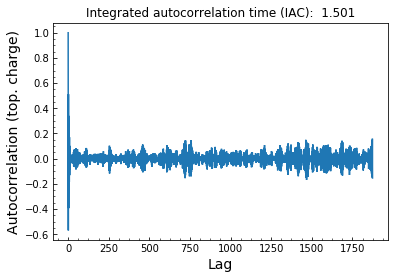

In [28]:
out_file = os.path.join(figs_dir, 
                        f'integrated_autocorrelation_time_plot_{kappa4}.pdf')

fig, ax = plt.subplots()
_ = ax.plot(np.arange(len(autocorr4)), autocorr4, ls='-')
_ = ax.set_xlabel('Lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
_ = ax.set_title(f'Integrated autocorrelation time (IAC): {iac4:6.4g}')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

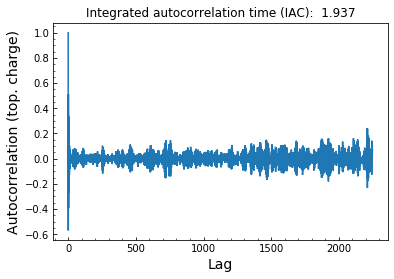

In [29]:
out_file = os.path.join(figs_dir, 
                        f'integrated_autocorrelation_time_plot_{kappa10}.pdf')

fig, ax = plt.subplots()
_ = ax.plot(np.arange(len(autocorr10)), autocorr10, ls='-')
_ = ax.set_xlabel('Lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
_ = ax.set_title(f'Integrated autocorrelation time (IAC): {iac10:6.4g}')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

## Old method (make each plot by hand)

### Specify run directory containing parameters and samples 

In [ ]:
log_dir = '../../gauge_logs_graph/run_2/'
info_dir = os.path.join(log_dir, 'run_info')
figs_dir = os.path.join(log_dir, 'figures')
params_file = os.path.join(info_dir, 'parameters.pkl')
with open(params_file, 'rb') as f:
    params = pickle.load(f)

In [ ]:
# Create lattice with same parameters to use for calculating observables
lattice = GaugeLattice(params['time_size'],
                       params['space_size'],
                       params['dim'],
                       params['beta'],
                       params['link_type'],
                       params['num_samples'],
                       params['rand'])

In [ ]:
# Load samples from `info_dir/samples_history.pkl` file
# Note that samples_history will be an array of shape:
#    [num_samples, num_eval_steps]
# where num_samples is the number of samples in each batch
# and num_eval steps is the number of steps the (trained) L2HMC simulation 
# was ran for.
samples_history_file = os.path.join(info_dir, 'samples_history.pkl')
with open(samples_history_file, 'rb') as f:
    samples_history = pickle.load(f)

In [ ]:
np.array(samples_history).shape

In [ ]:
# Iterate over samples history and calculate observables for each sample.
# `lattice.calc_plaq_observables(samples)` calculates observables for each of
# the samples in the mini-batch.
actions_history = []
avg_plaquettes_history = []
top_charges_history = []
for idx, samples in enumerate(samples_history):
    t0 = time.time()
    observables = np.array(lattice.calc_plaq_observables(samples))
    actions, plaqs, charges = observables
    
    actions_history.append(actions)
    avg_plaquettes_history.append(plaqs)
    top_charges_history.append(charges)
    
    print(f'step: {idx}  '
          f'time / step: {time.time() - t0:^6.4g}  '
          f'avg action: {np.mean(actions):^6.4g}  '
          f'avg plaquette: {np.mean(plaqs):^6.4g} '
          f'top charge: {np.mean(charges):^6.4g}')

In [ ]:
samples_history = np.array(samples_history)
actions_history = np.array(actions_history)
avg_plaquettes_history = np.array(avg_plaquettes_history)
top_charges_history = np.array(top_charges_history)
steps = np.arange(len(actions_history))

In [ ]:
len(samples_history[0].shape)

In [ ]:
# Compute the autocorrelation function using the topological charges
top_charges_autocorr_arr = []
num_samples = top_charges_history.shape[1]
for i in range(num_samples):
    top_charges_autocorr_arr.append(autocorr(top_charges_history[:, i]))
top_charges_autocorr_arr = np.array(top_charges_autocorr_arr)
top_charges_autocorr_avg = np.mean(top_charges_autocorr_arr, axis=0)

In [ ]:
top_charges_autocorr_arr.shape

In [ ]:
top_charges_autocorr_avg.shape

In [ ]:
samples_history = np.array(samples_history)
_shape = samples_history.shape
samples_history = samples_history.reshape(_shape[0], _shape[1], -1)
num_samples = samples_history.shape[1]
num_links  = samples_history.shape[-1]
samples_autocorr_arr = []
for n in range(num_samples):
    links_autocorr_arr = []
    for l in range(num_links):
        links_autocorr_arr.append(autocorr(samples_history[:, n, l]))
    samples_autocorr_arr.append(links_autocorr_arr)
samples_autocorr_arr = np.array(samples_autocorr_arr)
samples_autocorr_arr_avg = samples_autocorr_arr.mean(axis=1)

In [ ]:
samples_history.shape

In [ ]:
samples_autocorr_arr.shape

In [ ]:
samples_autocorr_arr_avg.shape

In [ ]:
out_file = os.path.join(figs_dir, 'topological_charge_autocorr_fn.pdf')
fig, ax = plot_multiple_lines(steps, top_charges_autocorr_arr,
                              x_label='step', 
                              y_label='Autocorrelation (top. charge)',
                              legend=True,
                              out_file=out_file)

In [ ]:
len(steps)

In [ ]:
out_file = os.path.join(figs_dir, 
                        'topological_charge_autocorr_fn_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, top_charges_autocorr_arr.T,
                                 xlabel='step',
                                 ylabel='Autocorrelation (top. charge)',
                                 #xlim1=(-2, 50), xlim2=(395, 500),
                                 output_file=out_file)

In [ ]:
out_file = os.path.join(figs_dir, 'topological_charge_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, top_charges_history.T,
                              x_label='step', y_label='Topological charge',
                              out_file=out_file)

In [ ]:
out_file = os.path.join(figs_dir, 
                        'topological_charge_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, top_charges_history,
                                 xlabel='step', ylabel='Topological charge',
                                 xlim1=(-2, 100), xlim2=(895, 1000),
                                 output_file=None)
ax2.legend(loc='lower right')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
from lattice.gauge_lattice import u1_plaq_exact

In [ ]:
out_file = os.path.join(figs_dir, 'average_plaquette_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, avg_plaquettes_history.T,
                              x_label='step', y_label='Average plaquette')
_ = ax.axhline(y=u1_plaq_exact(params['beta']), 
           color='r', ls='--', lw=2.5, label='exact')
fig.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 'average_plaquette_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, avg_plaquettes_history,
                                 xlabel='step', ylabel='Average plaquette',
                                 xlim1=(-2, 65), xlim2=(895, 1000),
                                 output_file=None)

_ = ax.axhline(y=u1_plaq_exact(params['beta']), 
           color='r', ls='--', lw=2.5, label='exact')

_ = ax2.axhline(y=u1_plaq_exact(params['beta']), 
                color='r', ls='--', lw=2.5, label='exact')
leg = ax2.legend(loc='lower right', fontsize=10)

plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 'average_action_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, actions_history.T,
                              x_label='step', y_label='Average plaquette')
fig.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 'average_action_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, actions_history,
                                 xlabel='step', ylabel='Total action',
                                 xlim1=(-2, 55), xlim2=(895, 1000),
                                 output_file=out_file)

In [ ]:
samples_acl_spectrum = acl_spectrum(samples_history, scale=1)

In [ ]:
samples_acl_spectrum = acl_spectrum(samples_history, scale=1)
acl_steps = np.arange(len(samples_acl_spectrum))
fig, ax = plt.subplots()
ax.plot(acl_steps, samples_acl_spectrum/samples_acl_spectrum[0])
ax.set_xlabel('step', fontsize=14)
ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
plt.savefig(os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf'),
            dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
from utils.gauge_observables import *

In [ ]:
log_dir = '../../gauge_logs_graph/run_2/'

In [ ]:
params, samples, observables = calc_observables_from_log_dir(log_dir)

In [ ]:
actions, avg_plaquettes, top_charges = observables

beta = params['beta']
figs_dir = os.path.join(log_dir, 'figures')

In [ ]:
top_charges_autocorr, _ = calc_top_charges_autocorr(top_charges)
samples_autocorr, _ = calc_samples_autocorr(samples)

In [ ]:
from utils.gauge_observables import _make_plots

In [ ]:
multiple_lines_figs_axes, broken_xaxis_figs_axes = _make_plots(
    figs_dir, 
    beta, 
    samples, 
    observables,
    top_charges_autocorr, 
    samples_autocorr
)

In [ ]:
make_plots_from_log_dir(log_dir)

## Compare Sample Autocorrelation across runs

In [ ]:
_dir = '../../gauge_logs_graph/'
dirs = [
    os.path.join(_dir, i) for i in os.listdir(_dir) if i .startswith('run')
]

In [ ]:
samples_dict = {}
params_dict = {}
lattice_dict = {}
for d in dirs:
    key = d.split('/')[-1]
    info_dir = os.path.join(d, 'run_info')
    samples_file = os.path.join(info_dir, 'samples_history.pkl')
    parameters_file = os.path.join(info_dir, 'parameters.pkl')
    try:
        with open(samples_file, 'rb') as f:
            samples_dict[key] = pickle.load(f)
        with open(parameters_file, 'rb') as f:
            params_dict[key] = pickle.load(f)
        lattice_dict[key] = GaugeLattice(time_size=params['time_size'],
                                         space_size=params['space_size'],
                                         dim=params['dim'],
                                         beta=params['beta'],
                                         link_type=params['link_type'],
                                         num_samples=params['num_samples'],
                                         rand=params['rand'])
    except FileNotFoundError:
        continue

In [ ]:
samples_autocorr_dict = {}
samples_autocorr_avg_dict = {}
samples_acl_spectrum_dict = {}
for key, samples_history in samples_dict.items():
    samples_history = np.array(samples_history)
    _shape = samples_history.shape
    samples_history = samples_history.reshape(_shape[0], _shape[1], -1)
    num_samples = samples_history.shape[1]
    num_links  = samples_history.shape[-1]
    samples_autocorr_arr = []
    for n in range(num_samples):
        links_autocorr_arr = []
        for l in range(num_links):
            links_autocorr_arr.append(autocorr(samples_history[:, n, l]))
        samples_autocorr_arr.append(links_autocorr_arr)
    samples_autocorr_arr = np.array(samples_autocorr_arr)
    samples_autocorr_arr_avg = samples_autocorr_arr.mean(axis=1)
    samples_autocorr_dict[key] = samples_autocorr_arr
    samples_autocorr_avg_dict[key] = samples_autocorr_arr_avg
    samples_acl_spectrum_dict[key] = acl_spectrum(samples_history, scale=1)

In [ ]:
samples_autocorr_avg_dict['run_37'].mean(axis=0).shape

In [ ]:
fig, ax = plt.subplots()
for key, samples_autocorr_avg in samples_autocorr_avg_dict.items():
    autocorr_avg_over_samples = samples_autocorr_avg.mean(axis=0)
    steps = np.arange(len(autocorr_avg_over_samples))
    _ = ax.plot(steps, autocorr_avg_over_samples, label=f'{key}')
_ = ax.set_xlabel('step', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
_ = ax.legend(loc='best')
_ = plt.show()

In [ ]:
fig, ax = plt.subplots()
for key, samples_acl_spectrum in samples_acl_spectrum_dict.items():
    acl_steps = np.arange(len(samples_acl_spectrum))
    _ = ax.plot(acl_steps, samples_acl_spectrum/samples_acl_spectrum[0], 
                label=f'{key}')
_ = ax.set_xlabel('step', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
_ = ax.legend(loc='best')
#plt.savefig(os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf'),
#            dpi=400, bbox_inches='tight')
plt.show()

### Incorrect

In [ ]:
out_file = os.path.join(figs_dir, 'samples_acl_spectrum.pdf')
fig, ax = plot_multiple_lines(x_data=steps, 
                              y_data=samples_autocorr_arr[0, 0:20],
                              x_label='step',
                              y_label='Autocorrelation (links)',
                              legend=False,
                              out_file=out_file)

In [ ]:
out_file = os.path.join(figs_dir, 'samples_acl_spectrum_avg.pdf')
fig, ax = plot_multiple_lines(x_data=steps,
                              y_data=samples_autocorr_arr_avg,
                              x_label='step',
                              y_label='Autocorrelation (avg. over links)',
                              semilogy=False,
                              legend=True,
                              out_file=out_file)

## OLD

In [ ]:
tf.InteractiveSession.close

In [ ]:
tf.Session().close()

In [ ]:
#sess = tf.InteractiveSession()

In [ ]:
tf.reset_default_graph()

In [ ]:
lattice = GaugeLattice(8, 8, 2, 8., 'U1', 2, rand=False)

In [ ]:
samples = tf.convert_to_tensor(lattice.samples, dtype=tf.float32)
potential_fn = lattice.get_energy_function(samples)

In [ ]:
dynamics = gde.GaugeDynamicsEager(
    lattice=lattice,
    num_steps=5,
    eps=0.1,
    minus_loglikelihood_fn=potential_fn,
    conv_net=True,
    hmc=False,
    eps_trainable=True
)

In [ ]:
# Define training and validation datasets with the same structure.
training_dataset = tf.data.Dataset.range(100).map(
    lambda x: x + tf.random_uniform([], -10, 10, tf.int64))
validation_dataset = tf.data.Dataset.range(50)

In [ ]:
# A reinitializable iterator is defined by its structure. We could use the
# `output_types` and `output_shapes` properties of either `training_dataset`
# or `validation_dataset` here, because they are compatible.
iterator = tf.data.Iterator.from_structure(training_dataset.output_types,
                                           training_dataset.output_shapes)
next_element = iterator.get_next()

In [ ]:
training_init_op = iterator.make_initializer(training_dataset)
validation_init_op = iterator.make_initializer(validation_dataset)

In [ ]:
# Run 20 epochs in which the training dataset is traversed, followed by the
# validation dataset.
for _ in range(20):
  # Initialize an iterator over the training dataset.
  sess.run(training_init_op)
  for _ in range(10):
    sess.run(next_element)

  # Initialize an iterator over the validation dataset.
  sess.run(validation_init_op)
  for _ in range(5):
    sess.run(next_element)

In [ ]:
dataset = tf.data.Dataset.range(5)
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Typically `result` will be the output of a model, or an optimizer's
# training operation.
result = tf.add(next_element, next_element)

sess.run(iterator.initializer)
print(sess.run(result))  # ==> "0"
print(sess.run(result))  # ==> "2"
print(sess.run(result))  # ==> "4"
print(sess.run(result))  # ==> "6"
print(sess.run(result))  # ==> "8"
try:
  sess.run(result)
except tf.errors.OutOfRangeError:
  print("End of dataset")  # ==> "End of dataset"

In [ ]:
samples_placeholder = tf.placeholder(samples.dtype, samples.shape)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(samples_placeholder).batch(2)

In [ ]:
dataset.output_shapes

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(dynamics.apply_transition(samples_placeholder))

In [ ]:
dataset.apply(dynamics.apply_transition)

In [ ]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

In [ ]:
sess.run(iterator.initializer, feed_dict={samples_placeholder: samples})

In [ ]:
max_value = tf.placeholder(tf.int64, shape=[])
dataset = tf.data.Dataset.range(max_value)    # Take a placeholder to create a dataset
iterator = dataset.make_initializable_iterator()      # Create an initializable iterator
next_element = iterator.get_next()

with tf.Session() as sess:
    # Initialize an iterator over a dataset with 10 elements using placeholder.
    sess.run(iterator.initializer, feed_dict={max_value: 10}) 

    for i in range(10):
        value = sess.run(next_element)
        print(f"{value} ", end=" ")    # 0 1 2 3 ... 9

In [ ]:
dataset = tf.data.Dataset.from_tensors(samples_placeholder)

In [ ]:
dataset

In [ ]:
dataset.apply(dynamics.apply_transition)
dataset = dataset.map(dynamics.apply_transition)

In [ ]:
iterator = dataset.make_initializable_iterator()

In [ ]:
sess.run(iterator.initializer, 
         feed_dict={samples_placeholder: lattice.samples})

In [ ]:
next_element = iterator.get_next()

In [ ]:
result = dynamics.apply_transition(next_element)

In [ ]:
sess.run(result)

In [ ]:
result = dynamics.apply_transition(next_element)

In [ ]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Typically `result` will be the output of a model, or an optimizer's
# training operation.
result = tf.add(next_element, next_element)

In [ ]:
features_placeholder = tf.placeholder(features.dtype, features.shape)
labels_placeholder = tf.placeholder(labels.dtype, labels.shape)

dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
# [Other transformations on `dataset`...]
dataset = ...
iterator = dataset.make_initializable_iterator()

sess.run(iterator.initializer, feed_dict={features_placeholder: features,
                                          labels_placeholder: labels})